# Data Recovery Demo Usecase 

This notebook attempts to show a usecase of this table wrapper: that is quickly and easily collecting data stored in tabular format in pdf documents. Here we are using old IBM w-10 documents as a use case, and taking a look at revenue from their systems division over the past ten years. 

This notebook goes through the process of extracting the relevant tables, and constructing a dataset using information over all of the years, as well as reconstructing all of the tables extracted from the pdf over those years. 

This is done in the following steps: 
1. Initialize the notebook and load the files 

Note for the sake of simplicity, we have pre-run the w-10 pdf's through the watson table understanding api, and and are loading cached versions of the outputs. Otherwise you would query the api, and save the 08
1. 

In [1]:
# INITIALIZATION BOILERPLATE

# The Jupyter kernel for this notebook usually starts up inside the notebooks
# directory, but the text_extensions_for_pandas package code is in the parent
# directory. Add that parent directory to the front of the Python include path.
import sys
if (sys.path[0] != ".."):
    sys.path[0] = ".."

import json
import os

import pandas as pd 
import text_extensions_for_pandas as tp
from IPython.core.display import HTML
from timeit import default_timer as timer

pd.set_option('display.html.use_mathjax',False)

responses_dict ={}

In [2]:
base_path = "../../Table_understanding_fintabnet/tu_results/IBM/batch_000/"
excludes = [2011, 2014,2005]
file_names = [str(yr) for yr in range(2010,2020) if yr not in excludes]
print(file_names)


['2010', '2012', '2013', '2015', '2016', '2017', '2018', '2019']


In [3]:
# this replaces the code you would use to query watson table understanding api 
# we have already run this and cached the outputs, for simplicity and time saving

responses_dict ={}
for file_name in file_names:
    with open(f"{base_path}{file_name}.html.json", 'r') as archive_file:
        temp = {}
        temp["raw"] = json.load(archive_file)
        responses_dict[file_name] = temp

In [4]:
show_output= False

#construct the data from all overview "systems" tables. also reconstruct the tables and display them 
# as well as the corresponding html table 
all_overviews = pd.DataFrame()
for fname in file_names:
    response = responses_dict[fname]["raw"]
    parsed= tp.watson_tables_parse_response(response, select_table="Systems")
    exp_1 = tp.make_exploded_df(parsed, col_explode_by="concat")
    all_overviews = exp_1[0] if all_overviews.empty else all_overviews.append(exp_1[0],ignore_index=True)

    #display parsed table, shredded table, and html table
    if show_output:
        print(f'\n\nYear: {fname}\n\n\n')
        #display( exp_1[0] )
        display(tp.make_table(parsed))
        display(HTML(tp.get_raw_html(response,parsed)))


In [5]:
# really we have 4 categories, but the exact terms have changed from one year to the next
# so we want to consolidate the categoies into:["Systems revenue", "Z systems revenue", "external revenue"]
external = ["Systems and Technology external revenue:", "Systems external revenue","Systems and Technology external revenue"]
Systems = ["SyStemS and technoloGy revenue:","Systems and Technology revenue:"]
hardware = ["Systems Hardware"]
Z_systems = ["Systems Hardware external revenue z Systems","Systems Hardware z Systems"]
#make a 1 liner     
convert_systems = (lambda x: "External revenue" if x in external else "Systems Revenue" if x in Systems else ("hardware revenue" if x in hardware else ("Z systems" if x in Z_systems else x)))

text row_header_texts_0 column_header_texts attributes.type
0    $16,190   External revenue                2009      [Currency]
1    $19,287   External revenue                2008      [Currency]
36   $17,667   External revenue                          [Currency]
72   $14,371   External revenue                2013      [Currency]
73   $17,667   External revenue                2012      [Currency]
108   $7,581          Z systems                2015      [Currency]
109   $9,996          Z systems                2014      [Currency]
124   $7,714   External revenue                2016      [Currency]
125   $9,547   External revenue                2015      [Currency]
128   $5,926          Z systems                2016      [Currency]
148   $8,194   External revenue                2017      [Currency]
152   $6,494   hardware revenue                2017      [Currency]
153   $5,926   hardware revenue                2016      [Currency]
172   $8,034   External revenue                2018      [Currency]
176   $6,363   hardware revenue                2018      [Currency]
196   $7,604   External revenue                2019      [Currency]
200   $5,918   hardware revenue                2019      [Currency]

External revenue  Z systems  hardware revenue
               17667.0        NaN               NaN
2008           19287.0        NaN               NaN
2009           16190.0        NaN               NaN
2012           17667.0        NaN               NaN
2013           14371.0        NaN               NaN
2014               NaN     9996.0               NaN
2015            9547.0     7581.0               NaN
2016            7714.0     5926.0            5926.0
2017            8194.0        NaN            6494.0
2018            8034.0        NaN            6363.0
2019            7604.0        NaN            5918.0

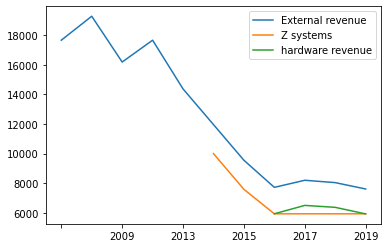

In [6]:
# rename similarly named items
all_overviews.row_header_texts_0 = all_overviews.row_header_texts_0.apply(convert_systems)
#Remove duplicate entries ( many tables referenced the previous years' numbers)
all_overviews.drop_duplicates(["row_header_texts_0", "column_header_texts"],inplace=True)
#select only dollar amounts
all_overviews = all_overviews[all_overviews["attributes.type"] == "Currency"]
display(all_overviews)

#convert to table, then to numeric values
table = tp.make_table_from_exploded_df(all_overviews,["column_header_texts"],["row_header_texts_0"])
table_num = tp.convert_cols_to_numeric(table)
#then plot
table_num.interpolate(method='linear').plot()
table_num

In [7]:
start = timer()
for file_name in file_names: 
    response = responses_dict[file_name]["raw"]
    num_tables =  len(response["tables"])
    responses_dict[file_name]["num_tabs"] = num_tables
    parsed_tables = {}
    for i in range(num_tables):
        parsed = tp.watson_tables_parse_response(response,select_table=i)
        parsed_tables[i] = parsed
    responses_dict[file_name]["parsed_tables"] = parsed_tables
    print(len(responses_dict[file_name]["parsed_tables"]))
end = timer()
print(end-start)

112
130
118
138
133
125
137
113
7.031235847


In [11]:
start = timer()
for year in  file_names[-2:]:
    document = responses_dict[year]
    tables = {}
    for i in range(document["num_tabs"]): 
        print(f"year: {year}, making table # {i}")
        parsed = document["parsed_tables"][i]
#         if i==3 and year =="2019": 
#                 print(document["parsed_tables"][i])
#                 display(tp.make_table(document["parsed_tables"][i],convert_numeric_items =False))
        table = tp.make_table(parsed,convert_numeric_items =True)
        display(table)
        display(HTML(tp.get_raw_html(document["raw"],parsed)))
        print("\n\n\n")
        tables[i] = table
    document["tables"] = tables
end = timer()
print(end-start)

year: 2018, making table # 0
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018  \
($ in millions except per share amounts)                                                                           
Assuming dilution                                  Earnings per share of common stock-continuing o...  $   9.51*   
At December 31:                                                                                             2018   
Basic                                              Earnings per share of common stock-continuing o...  $   9.56*   
Capital expenditures, net                                                                               $  3,716   
Cash dividends paid on common stock                                                                     $  5,666   
Cash, cash equivalents, restricted cash and mar...                                                      $ 12,222   
Common shares outstanding (in millions)                                                                      892   
Diluted operating (non-GAAP)**                     Earnings per share of common stock-continuing o...   $  13.81   
Earnings per share of common stock-continuing o...                                                                 
Income from continuing operations                  ($ in millions except per share amounts)            $  8,723*   
Net Income                                         ($ in millions except per share amounts)            $  8,728*   
Net cash provided by operating activities                                                               $ 15,247   
Operating (non-GAAP) earnings**                    ($ in millions except per share amounts)             $ 12,657   
Per share of common stock                                                                               $   6.21   
Revenue                                            ($ in millions except per share amounts)             $ 79,591   
Share repurchases                                                                                       $  4,443   
Stock price per common share                                                                            $ 113.67   
Total assets                                                                                            $123,382   
Total debt                                                                                              $ 45,812   
Total equity                                                                                            $ 16,929   
Working capital                                                                                         $ 10,918   

                                                                                                                 2017  
($ in millions except per share amounts)                                                                               
Assuming dilution                                  Earnings per share of common stock-continuing o...     $     6.14*  
At December 31:                                                                                                  2017  
Basic                                              Earnings per share of common stock-continuing o...     $     6.17*  
Capital expenditures, net                                                                                  $    3,312  
Cash dividends paid on common stock                                                                        $    5,506  
Cash, cash equivalents, restricted cash and mar...                                                     $   12,842****  
Common shares outstanding (in millions)                                                                           922  
Diluted operating (non-GAAP)**                     Earnings per share of common stock-continuing o...   $    13.66***  
Earnings per share of common stock-continuing o...                                                                     
Income from continuing operations                  ($ in millions except per share amounts)               $    5,758*  





year: 2018, making table # 1
['row_index'] ['column_header_texts_0']


\
1                                  NaN   
2                                        
3                                        
4                                        
5                                        
6                                        
7                                        
8                                        
9                                        
10                                       
11                                       
12                                       
13                                       
14                                       
15  Report of Independent Registered    
16  Report of Independent Registered    
17                                       
18                                       
19                                       
20                                       
21                                       
22                                       
23                                       

                         MANAGEMENT DISCUSSION  \
1                                    Overview   
2   Forward-Looking and Cautionary Statements   
3              Management Discussion Snapshot   
4                     Description of Business   
5                              Year in Review   
6                        Prior Year in Review   
7                          Other Information    
8                             Looking Forward   
9             Liquidity and Capital Resources   
10              Critical Accounting Estimates   
11                 Currency Rate Fluctuations   
12                                Market Risk   
13                              Cybersecurity   
14            Employees and Related Workforce   
15                      Report of Management    
16                    Public Accounting Firm    
17           CONSOLIDATED FINANCIAL STATEMENTS   
18                                   Earnings   
19                       Comprehensive Income   
20                         Financial Position   
21                                 Cash Flows   
22                          Changes in Equity   
23                                               

           NOTES TO CONSOLIDATED FINANCIAL STATEMENTS  
1            18\nA | Significant Accounting Policies  
2                         19\nB | Accounting Changes  
3                  19\nC | Acquisitions/Divestitures  
4                      22\nD | Financial Instruments  
5                                27\nE | Inventories  
6                      48\nF | Financing Receivables  
7             59\nG | Property, Plant and Equipment   
8              59\nH | Investments and Sundry Assets  
9       60\nI | Intangible Assets Including Goodwill  
10                                63\nJ | Borrowings  
11                         66\nK | Other Liabilities  
12                           66\nL | Equity Activity  
13             67\nM | Contingencies and Commitments  
14                                     67\nN | Taxes  
15  68\nO P | Revenue RecognitionResearch, Develo...  
16        69\nQ | Earnings Per Share of Common Stock  
17  R S T | Rental Expense and Lease CommitmentsS...  
18                                              70 |   
19                       71\nU | Segment Information  
20                         72\nV | Subsequent Events  
21                                              73 |   
22  74 | Five-Year Comparison of Selected Financia...  
23  Selected Quarterly Data Performance Graphs S...





year: 2018, making table # 2
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


2018  \
Assets ++                                          MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                   $123,382   
Assuming dilution                                  MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i... Earnings per share from continuing operations:  $   9.51 +   
                                                                                                      Weighted-average shares outstanding                  916.3   
Consolidated earnings per share-assuming dilution  MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                 $   9.52 +   
Earnings per share from continuing operations:     MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                              
Equity ++                                          MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                   $ 16,929   
Gross profit margin                                MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                       46.4   
Income from continuing operations                  MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                 $  8,723 +   
Income from continuing operations before income... MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                   $ 11,342   
Income from continuing operations margin           MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                      11.0%   
Income/(loss) from discontinued operations, net... MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                    $     5   
Liabilities ++                                     MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                   $106,452   
MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                                                                                 
Net income                                         MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                 $  8,728 +   
Provision for income taxes from continuing oper... MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                 $  2,619 +   
Revenue                                            MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                   $ 79,591   
Total expense and other (income)                   MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                   $ 25,594   
Total expense and other (income)-to-revenue ratio  MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                      32.2%   
Weighted-average shares outstanding                MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                              

                                                                                                                                                              2017  \
Assets ++                                          MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                     $125,356   
Assuming dilution                                  MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i... Earnings per share from continuing operations:  $     6.14 +   
                                                                                                      Weighted-average shares outstanding                    937.4   
Consolidated earnings per share-assuming dilution  MANAGEMENT DISCUSSION SNAPSHOT\n($ and shares i...                                                 $     6.14 +   
Earnings per share from continuing operations





year: 2018, making table # 3
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018  \
Acquisition-related charges                        Non-operating adjustments (net of tax)        649   
Diluted operating (non-GAAP) earnings per share                                              $ 13.81   
Income from continuing operations                                                          $ 8,723 +   
Income/(loss) from discontinued operations, net...                                                 5   
Net income as reported                                                                     $ 8,728 +   
Non-operating adjustments (net of tax)                                                                 
Non-operating retirement-related costs/(income)    Non-operating adjustments (net of tax)      1,248   
Operating (non-GAAP) earnings*                                                               $12,657   
U.S. tax reform charge                             Non-operating adjustments (net of tax)      2,037   

                                                                                                2017  \
Acquisition-related charges                        Non-operating adjustments (net of tax)        718   
Diluted operating (non-GAAP) earnings per share                                            $ 13.66**   
Income from continuing operations                                                          $   5,758   
Income/(loss) from discontinued operations, net...                                               (5)   
Net income as reported                                                                     $   5,753   
Non-operating adjustments (net of tax)                                                                 
Non-operating retirement-related costs/(income)    Non-operating adjustments (net of tax)      856**   
Operating (non-GAAP) earnings*                                                             $12,807**   
U.S. tax reform charge                             Non-operating adjustments (net of tax)      5,475   

                                                                                          Yr.-to-Yr. Percent Change  
Acquisition-related charges                        Non-operating adjustments (net of tax)                       9.7  
Diluted operating (non-GAAP) earnings per share                                                                1.1%  
Income from continuing operations                                                                           + 51.5%  
Income/(loss) from discontinued operations, net...                                                               NM  
Net income as reported                                                                                      + 51.7%  
Non-operating adjustments (net of tax)                                                                               
Non-operating retirement-related costs/(income)    Non-operating adjustments (net of tax)                      45.9  
Operating (non-GAAP) earnings*                                                                               (1.2)%  
U.S. tax reform charge                             Non-operating adjustments (net of tax)                        NM





year: 2018, making table # 4
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


2017  \
                                                                                                                          
Amortization of acquired intangible assets Non-operating adjustments                                                449   
Cognitive Solutions                        Revenue                                                              $18,453   
Global Business Services                   Revenue                                                               16,348   
Global Financing                           Revenue                                                                1,696   
Gross margin                               Revenue                    78.6%* | 24.9%* | 40.3%* | 53.2%* | 29.3% | (1...   
Non-operating adjustments                                                                                                 
Operating (non-GAAP) gross margin                                                                                47.2%*   
Operating (non-GAAP) gross profit                                                                              $37,392*   
Other                                      Revenue                                                                  171   
Retirement-related costs/(income)          Non-operating adjustments                                                 -*   
Revenue                                                                                                                   
Systems                                    Revenue                                                                8,194   
Technology Services & Cloud Platforms      Revenue                                                               34,277   
Total consolidated gross margin                                                                                  46.7%*   
Total consolidated gross profit                                                                                $36,943*   
Total consolidated revenue                                                                                      $79,139   

                                                                                                                  2018  \
                                                                                                                         
Amortization of acquired intangible assets Non-operating adjustments                                               372   
Cognitive Solutions                        Revenue                                                             $18,481   
Global Business Services                   Revenue                                                              16,817   
Global Financing                           Revenue                                                               1,590   
Gross margin                               Revenue                    77.5% | 26.7% | 40.5% | 49.8% | 29.1% | (140.7)%   
Non-operating adjustments                                                                                                
Operating (non-GAAP) gross margin                                                                                46.9%   
Operating (non-GAAP) gross profit                                                                              $37,307   
Other                                      Revenue                                                                 207   
Retirement-related costs/(income)          Non-operating adjustments                                                 -   
Revenue                                                                                                                  
Systems                                    Revenue                                                               8,034   
Technology Services & Cloud Platforms      Revenue                                                              34,462   
Total consolidated gross margin                                       





year: 2018, making table # 5
['row_header_texts_0'] ['column_header_texts_0']


2018     2017  \
Cognitive Solutions external revenue  $18,481  $18,453   
Solutions Software                    $12,903  $12,806   
Transaction Processing Software         5,578    5,647   

                                      Yr.-to-Yr. Percent Change  \
Cognitive Solutions external revenue                        0.2   
Solutions Software                                          0.8   
Transaction Processing Software                             1.2   

                                      Yr.-to-Yr. Percent Change Adjusted for Currency  
Cognitive Solutions external revenue                                              0.4  
Solutions Software                                                                0.3  
Transaction Processing Software                                                   1.9





year: 2018, making table # 6
['row_index'] ['column_header_texts_0', 'column_header_texts_1']


($ in millions)    2017*     2018  \
  For the year ended December 31:                     
2             Cognitive Solutions                     
3           External gross profit  $14,503  $14,319   
4    External gross profit margin    78.6%    77.5%   
5                  Pre-tax income  $ 6,795  $ 7,154   
6                  Pre-tax margin    32.2%    33.8%   

  Yr.-to-Yr. Percent/\nMargin Change  
                                      
2                                     
3                             (1.3)%  
4                         (1.1) pts.  
5                               5.3%  
6                           1.5 pts.





year: 2018, making table # 7
['row_header_texts_0'] ['column_header_texts_0']


2018     2017  \
Global Business Services external revenue  $16,817  $16,348   
Consulting                                 $ 7,705  $ 7,262   
Global Process Services                      1,259    1,265   
Application Management                       7,852    7,821   

                                           Yr.-to-Yr.\nPercent Change  \
Global Business Services external revenue                         2.9   
Consulting                                                        6.1   
Global Process Services                                           0.5   
Application Management                                            0.4   

                                           Yr.-to-Yr. Percent Change Adjusted for\nCurrency  
Global Business Services external revenue                                               2.0  
Consulting                                                                              5.1  
Global Process Services                                                                 0.5  
Application Management                                                                  0.5





year: 2018, making table # 8
['row_index'] ['column_header_texts_0']


For the year ended December 31:    2018   2017*  \
0  rate of $2.1 billion.\n($ in millions)                   
2                Global Business Services                   
3                   External gross profit  $4,484  $4,077   
4            External gross profit margin   26.7%   24.9%   
5                          Pre-tax income  $1,676  $1,362   
6                          Pre-tax margin    9.8%    8.2%   

  Yr.-to-Yr. Percent/\nMargin Change  
0                                     
2                                     
3                              10.0%  
4                           1.7 pts.  
5                              23.0%  
6                           1.6 pts.





year: 2018, making table # 9
['row_header_texts_0'] ['column_header_texts_0']


2018     2017  \
Technology Services & Cloud Platforms external ...  $34,462  $34,277   
Infrastructure Services                             $23,007  $22,690   
Technical Support Services                            6,961    7,196   
Integration Software                                  4,493    4,390   

                                                    Yr.-to-Yr.\nPercent Change  \
Technology Services & Cloud Platforms external ...                         0.5   
Infrastructure Services                                                    1.4   
Technical Support Services                                                 3.3   
Integration Software                                                       2.3   

                                                    Yr.-to-Yr. Percent Change Adjusted for\nCurrency  
Technology Services & Cloud Platforms external ...                                               0.1  
Infrastructure Services                                                                          0.7  
Technical Support Services                                                                       3.5  
Integration Software                                                                             1.9





year: 2018, making table # 10
['row_index'] ['column_header_texts_0', 'column_header_texts_1']


($ in millions)    2017*       2018  \
                      For the year ended December 31:                       
2               Technology Services & Cloud Platforms                       
3           External Technology Services gross profit  $10,215    $10,307   
4    External Technology Services gross profit margin    34.2%      34.4%   
5          External Integration Software gross profit  $ 3,587    $ 3,651   
6   External Integration Software gross profit margin    81.7%      81.3%   
7                         External total gross profit  $13,802    $13,958   
8                  External total gross profit margin    40.3%      40.5%   
9                                      Pre-tax income  $ 4,286  $   3,786   
10                                     Pre-tax margin    12.3%      10.7%   

   Yr.-to-Yr. Percent/\nMargin Change  
                                       
2                                      
3                                0.9%  
4                            0.2 pts.  
5                                1.8%  
6                          (0.4) pts.  
7                                1.1%  
8                            0.2 pts.  
9                             (11.7)%  
10                         (1.5) pts.





year: 2018, making table # 11
['row_index'] ['column_header_texts_0', 'column_header_texts_1']


($ in millions)     2017     2018 Yr.-to-Yr. Percent Change  \
  For the year ended December 31:                                               
2                  Total signings  $42,869  $44,700                       4.3   

  Yr.-to-Yr. Percent Change Adjusted for Currency  
                                                   
2                                             4.9





year: 2018, making table # 12
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


2017    2018 Yr.-to-Yr.\nPercent  \
                                                        Change   
Systems external revenue    $8,194  $8,034                 2.0   
Systems Hardware            $6,494  $6,363                 2.0   
IBM Z                                                      5.4   
Power Systems                                              8.8   
Storage Systems                                            5.5   
Operating Systems Software   1,701   1,671                 1.7   

                           Yr.-to-Yr. Percent Change Adjusted for  
                                                         Currency  
Systems external revenue                                      2.3  
Systems Hardware                                              2.3  
IBM Z                                                         5.6  
Power Systems                                                 8.7  
Storage Systems                                               5.9  
Operating Systems Software                                    2.4





year: 2018, making table # 13
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


2018  \
External Operating                               Systems                                
External Operating Systems Software gross profit Systems                       $1,412   
External Systems                                 Systems                                
External Systems Hardware gross profit           Systems                       $2,590   
External total gross profit                      Systems                       $4,002   
External total gross profit margin               Systems                         49.8   
Hardware gross profit margin                     Systems External Systems        40.7   
Pre-tax income                                   Systems                     $    904   
Pre-tax margin                                   Systems                        10.2%   
Systems                                                                                 
Systems Software gross profit margin             Systems External Operating      84.5   

                                                                              2017*  \
External Operating                               Systems                              
External Operating Systems Software gross profit Systems                     $1,469   
External Systems                                 Systems                              
External Systems Hardware gross profit           Systems                     $2,893   
External total gross profit                      Systems                     $4,362   
External total gross profit margin               Systems                       53.2   
Hardware gross profit margin                     Systems External Systems      44.6   
Pre-tax income                                   Systems                     $1,128   
Pre-tax margin                                   Systems                      12.6%   
Systems                                                                               
Systems Software gross profit margin             Systems External Operating    86.4   

                                                                            Yr.-to-Yr. Percent/\nMargin Change  
External Operating                               Systems                                                        
External Operating Systems Software gross profit Systems                                                (3.9)%  
External Systems                                 Systems                                                        
External Systems Hardware gross profit           Systems                                               (10.5)%  
External total gross profit                      Systems                                                (8.2)%  
External total gross profit margin               Systems                                                 0.034  
Hardware gross profit margin                     Systems External Systems                                0.038  
Pre-tax income                                   Systems                                               (19.9)%  
Pre-tax margin                                   Systems                                           (2.4 ) pts.  
Systems                                                                                                         
Systems Software gross profit margin             Systems External Operating                              0.019





year: 2018, making table # 14
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


2017*     2018 Yr.-to-Yr. Percent  \
                                                        Change   
Total revenue              $79,139  $79,591                0.6   
Americas                   $37,641  $36,994                1.7   
Europe/Middle East/Africa   24,397   25,491                4.5   
Asia Pacific                17,102   17,106                0.0   

                          Yr.-to-Yr. Percent Change Adjusted for  
                                                        Currency  
Total revenue                                                0.0  
Americas                                                     0.7  
Europe/Middle East/Africa                                    1.3  
Asia Pacific                                                 0.4





year: 2018, making table # 15
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2', 'column_header_texts_3']


Americas revenue decreased 1.7 percent year to year as reported  \
                                                                   as reported and adjusted for currency, and a decline in Latin America as reported, but growth adjusted for currency. Within North America, the U.S. decreased 2.4 percent and Canada   
                                                                                                                                                                                                                                                          
                                                                                                                                                                                                                                                          
                                                                    (1 percent adjusted for currency) with a decli...                                                                                                                                     
($ in millions)                                                                                                                                                                                                                                           
Acquisition-related charges (16)                                                                          (52) (70.2)                                                                                                                                     
Amortization of acquired intangible assets (437)                                                         (496) (11.9)                                                                                                                                     
For the year ended December 31: 2018               ($ in millions)          Yr.-to-Yr. Percent/ | 2017\nMargin Change                                                                                                                                     
Non-operating adjustments                                                                                                                                                                                                                                 
Non-operating retirement-\nrelated (costs)/inco...                                                      (1,341)* 17.3                                                                                                                                     
Operating (non-GAAP) expense and other (income)...                                                    $23,654* (0.4)%                                                                                                                                     
Operating (non-GAAP) expense-to-revenue ratio                                                            29.6% 29.9%*                                                                                                                                     
Total consolidated expense and other (income) $... ($ in millions)                                      $25,543* 0.2%                                                                                                                                     
Total consolidated expense-to-revenue ratio                                                              32.2% 32.3%*                                                                                                                                     

                                                                          Selling, General and Administrative Expense  \
                                                                                                            2018 2017   
                                                                                                                        
                                                       





year: 2018, making table # 16
['row_index'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2', 'column_header_texts_3', 'column_header_texts_4']


2017      2018        Other (Income) and Expense\n($ in millions)  \
                                            For the year ended December 31:   
                                                                              
                                                                              
                                                                              
2                                                Other (income) and expense   
3     $    405  $  (427)        Foreign currency transaction losses/(gains)   
4                                                                             
5        (341)       434           (Gains)/losses on derivative instruments   
6        (144)     (264)                                    Interest income   
7         (20)     (101)             Net (gains)/losses from securities and   
8       1,341*     1,572  investment assets Retirement-related costs/(in...   
9        (116)      (63)                                              Other   
10    $ 1,125*   $ 1,152      Total consolidated other (income) and expense   
11                                                Non-operating adjustments   
12           -       (2)         Amortization of acquired intangible assets   
13        (39)         0                        Acquisition-related charges   
14    (1,341)*   (1,572)  Non-operating retirement-\nrelated costs/(income)   
15                                                                            
16  $    (255)  $  (422)    Operating (non-GAAP) other (income) and expense   
17                                                                            
18         NaN       NaN                                                NaN   
19         NaN       NaN                                                NaN   
20         NaN       NaN                                                NaN   
21                                                               driven by:   
22         NaN       NaN                                                NaN   

                                                       \
                                                        
                                                 2018   
                                                 2017   
                            Yr.-to-Yr. Percent Change   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                                 NaN   
6                                                 NaN   
7                                                 NaN   
8                                                 NaN   
9                                                 NaN   
10                                                NaN   
11                                                NaN   
12                                                NaN   
13                                                NaN   
14                                                NaN   
15                                                NaN   
16                                                NaN   
17                                                NaN   
18  * Recast to reflect adoption of the FASB guid...   
19  Total consolidated other (income) and expense ...   
20  $1,152 million in 2018 compared to $1,125 mill...   
21                                                NaN   
22  • Higher retirement-related costs ($232 milli...   

   Research, Development and Engineering Expense\n($ in millions)          \
                                                            2017*    2018   
                                                                            
                                                                            
                                                                            
2                                                                           
3         





year: 2018, making table # 17
['row_index'] ['column_header_texts_0', 'column_header_texts_1']
ERROR READING VALUE:"compared to a charge of $5.5 billion (48.0 points) in 2017 related to the impact of the enactment of U.S. tax reform, a year-to-year"	 Filling with <NA>
ERROR READING VALUE:"0.4%
decrease of 30.4 points. Without these impacts, the continuing"	 Filling with <NA>
ERROR READING VALUE:"(5.4)
operations tax rate for 2018 would have been 5.4 percent,"	 Filling with <NA>
ERROR READING VALUE:"(2.1)
compared to a 2017 rate of 1.5 percent. The adjusted year-to-year increase of 3.9 points is primarily driven by the following factors:"	 Filling with <NA>
ERROR READING VALUE:"(1.5)%
• A lower benefit year to year in the utilization of foreign tax credits of 5.9 points;"	 Filling with <NA>
ERROR READING VALUE:"(7.9)%
• Benefits in 2017 related to an intra-entity asset transfer"	 Filling with <NA>
ERROR READING VALUE:"(6.8)
of 5.1 points and the tax write down of an investment of 

Stock-Based Compensation\nPre-tax stock-based compensation cost of $510 million decreased $24 million compared to 2017. This was due primarily to decreases related to the conversion of stock-based awards previously issued by acquired entities ($4 million), performance share units ($7 million) and restricted stock units ($13 million). Stock-based compensation cost, and the year-to-year change, was reflected in the following categories: Cost: $82 million, down $9 million; SG&A expense: $361 million, down $23 million; and RD&E expense: $67 million, up $8 million.\nRetirement-Related Plans\nThe following table provides the total pre-tax cost retirement-related plans. These amounts are included in the Consolidated Statement of Earnings within the caption (e.g., Cost, SG&A, RD&E) relating to the job function of the plan participants.\n($ in millions)  \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       2017   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
3                                              $  429                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
4                                                 40*                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  





year: 2018, making table # 18
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018  \
Assuming dilution                                  Earnings per share of common stock from continu...  $ 9.51*   
Basic                                                                                                      912   
                                                   Earnings per share of common stock from continu...   $ 9.56   
Diluted operating (non-GAAP)                       Earnings per share of common stock from continu...   $13.81   
Earnings per share of common stock from continu...                                                               
Weighted-average shares outstanding (in million...                                                       916.3   

                                                                                                           2017  \
Assuming dilution                                  Earnings per share of common stock from continu...   $ 6.14*   
Basic                                                                                                     932.8   
                                                   Earnings per share of common stock from continu...    $ 6.17   
Diluted operating (non-GAAP)                       Earnings per share of common stock from continu...  $13.66**   
Earnings per share of common stock from continu...                                                                
Weighted-average shares outstanding (in million...                                                        937.4   

                                                                                                      Yr.-to-Yr. Percent Change  
Assuming dilution                                  Earnings per share of common stock from continu...                     54.9%  
Basic                                                                                                                       2.2  
                                                   Earnings per share of common stock from continu...                     54.9%  
Diluted operating (non-GAAP)                       Earnings per share of common stock from continu...                      1.1%  
Earnings per share of common stock from continu...                                                                               
Weighted-average shares outstanding (in million...                                                                          2.2





year: 2018, making table # 19
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018  \
($ in millions)                                                               
Cash and cash equivalents                          ($ in millions)  $ 1,833   
Client loans                                       ($ in millions)    12802   
Commercial financing receivables                   ($ in millions)    11838   
Debt                                                                  31227   
Equipment under operating leases- external clie... ($ in millions)      444   
Intercompany financing receivables  (3) (4)        ($ in millions)     4873   
Net investment in sales-type and direct financi... ($ in millions)     6924   
Total assets                                                        $41,320   
Total client financing assets                      ($ in millions)    20170   
Total equity                                                        $ 3,470   

                                                                       2017  
($ in millions)                                                              
Cash and cash equivalents                          ($ in millions)  $ 2,696  
Client loans                                       ($ in millions)    12450  
Commercial financing receivables                   ($ in millions)    11590  
Debt                                                                  31434  
Equipment under operating leases- external clie... ($ in millions)      477  
Intercompany financing receivables  (3) (4)        ($ in millions)     5056  
Net investment in sales-type and direct financi... ($ in millions)     7253  
Total assets                                                        $41,096  
Total client financing assets                      ($ in millions)    20180  
Total equity                                                        $ 3,484





year: 2018, making table # 20
['row_index'] ['column_header_texts_0']


January 1, 2018 Additions*  Write-offs**  Other + December 31, 2018
1                   $668 $66          64.0     31.0              $639





year: 2018, making table # 21
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018     2017
($ in millions)                                                          
Allowance for credit losses coverage                         0.9      1.1
Net financing receivables                                $30,890  $30,556
Recorded investment  (1)                ($ in millions)  $31,182  $30,892
Specific allowance for credit losses                         220      258
Total allowance for credit losses                            292      336
Unallocated allowance for credit losses                       72       78





year: 2018, making table # 22
['row_index'] ['column_header_texts_0']


Equity\nTotal equity decreased by $795 million from December 31, 2017 primarily due to decreases from dividends ($5,666 million), and treasury stock ($4,564 million) primarily due to share repurchases; partially offset by increases from net income ($8,728 million) and transition adjustments related to the adoption of the new revenue standard ($580 million).\nCash Flow\nThe company's cash flows from operating, investing and financing activities, as reflected in the Consolidated Statement of Cash Flows on page 73 are summarized in the table below. These amounts include the cash flows associated with the Global Financing business.\n($ in millions)\nFor the year ended December 31:  \
1  Net cash provided by/(used in) continuing oper...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2                               Operating activities                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
3                               Investing activities                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
4                               Financing activities                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
5  Effect of exchange rate changes on cash, cash ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               





year: 2018, making table # 23
['row_header_texts_0'] ['column_header_texts_0']


GAAP  \
Gross profit                                         $36,936   
Gross profit margin                                    46.4%   
SG&A                                                 $19,366   
RD&E                                                   5,379   
Other (income) and expense                             1,152   
Total expense and other (income)                      25,594   
Pre-tax income from continuing operations             11,342   
Pre-tax margin from continuing operations              14.3%   
Provision for income taxes*                         $  2,619   
Effective tax rate                                      23.1   
Income from continuing operations                   $  8,723   
Income margin from continuing operations               11.0%   
Diluted earnings per share from continuing oper...  $   9.51   

                                                   Acquisition- Related Adjustments  \
Gross profit                                                                  $ 372   
Gross profit margin                                                        0.5 pts.   
SG&A                                                                         $(451)   
RD&E                                                                              -   
Other (income) and expense                                                      (2)   
Total expense and other (income)                                              (453)   
Pre-tax income from continuing operations                                       824   
Pre-tax margin from continuing operations                                  1.0 pts.   
Provision for income taxes*                                                   $ 176   
Effective tax rate                                                            0.001   
Income from continuing operations                                             $ 649   
Income margin from continuing operations                                   0.8 pts.   
Diluted earnings per share from continuing oper...                            $0.71   

                                                   Retirement- Related Adjustments  \
Gross profit                                                                   $ -   
Gross profit margin                                                         - pts.   
SG&A                                                                           $ -   
RD&E                                                                             -   
Other (income) and expense                                                 (1,572)   
Total expense and other (income)                                           (1,572)   
Pre-tax income from continuing operations                                    1,572   
Pre-tax margin from continuing operations                                 2.0 pts.   
Provision for income taxes*                                                 $  324   
Effective tax rate                                                           0.003   
Income from continuing operations                                          $ 1,248   
Income margin from continuing operations                                  1.6 pts.   
Diluted earnings per share from continuing oper...                         $  1.36   

                                                   Tax Reform Charges  \
Gross profit                                                      $ -   
Gross profit margin                                            - pts.   
SG&A                                                              $ -   
RD&E                                                                -   
Other (income) and expense                                          -   
Total expense and other (income)                                    -   
Pre-tax income from continuing operations                           -   
Pre-tax margin from continuing operations                      - pts.   
Provision for income taxes*                                  $(2,037)   
Effec





year: 2018, making table # 24
['row_header_texts_0'] ['column_header_texts_0']


GAAP\n**  \
Gross profit                                        $36,943   
Gross profit margin                                   46.7%   
SG&A                                                $19,680   
RD&E                                                  5,590   
Other (income) and expense                            1,125   
Total expense and other (income)                     25,543   
Pre-tax income from continuing operations            11,400   
Pre-tax margin from continuing operations             14.4%   
Provision for income taxes*                         $ 5,642   
Effective tax rate                                     49.5   
Income from continuing operations                   $ 5,758   
Income margin from continuing operations               7.3%   
Diluted earnings per share from continuing oper...  $  6.14   

                                                   Acquisition- Related Adjustments  \
Gross profit                                                                  $ 449   
Gross profit margin                                                        0.6 pts.   
SG&A                                                                         $(509)   
RD&E                                                                              -   
Other (income) and expense                                                     (39)   
Total expense and other (income)                                              (548)   
Pre-tax income from continuing operations                                       997   
Pre-tax margin from continuing operations                                  1.3 pts.   
Provision for income taxes*                                                   $ 279   
Effective tax rate                                                            0.016   
Income from continuing operations                                             $ 718   
Income margin from continuing operations                                   0.9 pts.   
Diluted earnings per share from continuing oper...                            $0.77   

                                                   Retirement- Related Adjustments**  \
Gross profit                                                                 $     -   
Gross profit margin                                                           - pts.   
SG&A                                                                          $    -   
RD&E                                                                               -   
Other (income) and expense                                                   (1,341)   
Total expense and other (income)                                             (1,341)   
Pre-tax income from continuing operations                                      1,341   
Pre-tax margin from continuing operations                                   1.7 pts.   
Provision for income taxes*                                                  $   485   
Effective tax rate                                                             0.013   
Income from continuing operations                                            $   856   
Income margin from continuing operations                                    1.1 pts.   
Diluted earnings per share from continuing oper...                           $  0.91   

                                                   Tax Reform Charge  \
Gross profit                                                  $    -   
Gross profit margin                                           - pts.   
SG&A                                                          $    -   
RD&E                                                               -   
Other (income) and expense                                         -   
Total expense and other (income)                                   -   
Pre-tax income from continuing operations                          -   
Pre-tax margin from continuing operations                     - pts.   
Provision for income taxes*                                 $(5,475)





year: 2018, making table # 25
['row_index'] ['column_header_texts_0']


For the fourth quarter:        2018  \
0   ($ and shares in millions except per share amo...               
2                                             Revenue     $21,760   
3                                 Gross profit margin       49.1%   
4                    Total expense and other (income)     $ 6,253   
5   Total expense and other (income)-to-revenue ratio       28.7%   
6   Income from continuing operations before incom...     $ 4,434   
7   Provision for income taxes from continuing ope...   $ 2,481 +   
8            Income/(loss) from continuing operations   $ 1,954 +   
9     Income/(loss) from continuing operations margin        9.0%   
10      Loss from discontinued operations, net of tax    $    (2)   
11                                  Net income/(loss)   $ 1,951 +   
12  Earnings/(loss) per share from continuing oper...               
13                                  Assuming dilution  $   2.15 +   
14  Consolidated earnings/(loss) per share-assumin...  $   2.15 +   
15                Weighted-average shares outstanding               
16                                  Assuming dilution       905.2   

           2017 Yr.-to-Yr. Percent/\nMargin Change  
0                                                   
2       $22,543                            (3.5)%*  
3       49.0%**                           0.1 pts.  
4     $ 6,580**                             (5.0)%  
5       29.2%**                          (0.5)pts.  
6       $ 4,469                             (0.8)%  
7     $ 5,522 +                             (55.1)  
8   $ (1,053) +                                 NM  
9        (4.7)%                          13.6 pts.  
10   $      (1)                              70.7%  
11  $ (1,054) +                                 NM  
12                                                  
13  $  (1.14) +                                 NM  
14  $  (1.14) +                                 NM  
15                                                  
16        924.5                             (2.1)%





year: 2018, making table # 26
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018  \
($ in millions except per share amounts)                                                             
Acquisition-related charges                     Non-operating adjustments (net of tax)         171   
Diluted operating (non-GAAP) earnings per share                                             $ 4.87   
Income/(loss) from continuing operations        ($ in millions except per share amounts)   1,954 +   
Loss from discontinued operations, net of tax   ($ in millions except per share amounts)         2   
Net income/(loss) as reported                   ($ in millions except per share amounts)  $1,951 +   
Non-operating adjustments (net of tax)                                                               
Non-operating retirement-related costs/(income) Non-operating adjustments (net of tax)         348   
Operating (non-GAAP) earnings*                                                              $4,417   
U.S. tax reform charge                          Non-operating adjustments (net of tax)       1,944   

                                                                                                 2017  \
($ in millions except per share amounts)                                                                
Acquisition-related charges                     Non-operating adjustments (net of tax)            181   
Diluted operating (non-GAAP) earnings per share                                            $  5.14 **   
Income/(loss) from continuing operations        ($ in millions except per share amounts)    (1,053) +   
Loss from discontinued operations, net of tax   ($ in millions except per share amounts)            1   
Net income/(loss) as reported                   ($ in millions except per share amounts)  $(1,054 ) +   
Non-operating adjustments (net of tax)                                                                  
Non-operating retirement-related costs/(income) Non-operating adjustments (net of tax)          174**   
Operating (non-GAAP) earnings*                                                              $ 4,777**   
U.S. tax reform charge                          Non-operating adjustments (net of tax)          5,475   

                                                                                         Yr.-to-Yr. Percent Change  
($ in millions except per share amounts)                                                                            
Acquisition-related charges                     Non-operating adjustments (net of tax)                         5.3  
Diluted operating (non-GAAP) earnings per share                                                             (5.3)%  
Income/(loss) from continuing operations        ($ in millions except per share amounts)                        NM  
Loss from discontinued operations, net of tax   ($ in millions except per share amounts)                      70.7  
Net income/(loss) as reported                   ($ in millions except per share amounts)                        NM  
Non-operating adjustments (net of tax)                                                                              
Non-operating retirement-related costs/(income) Non-operating adjustments (net of tax)                        99.5  
Operating (non-GAAP) earnings*                                                                              (7.5)%  
U.S. tax reform charge                          Non-operating adjustments (net of tax)                          NM





year: 2018, making table # 27
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


2017  \
                                                                                                                          
Amortization of acquired intangible assets Non-operating adjustments                                                 99   
Cognitive Solutions                        Revenue                                                              $ 5,432   
Global Business Services                   Revenue                                                                4,152   
Global Financing                           Revenue                                                                  450   
Gross margin                               Revenue                    79.2%* | 24.6%* | 40.8%* | 55.7%* | 29.5% | 70...   
Non-operating adjustments                                                                                                 
Operating (non-GAAP) gross margin                                                                                49.5%*   
Operating (non-GAAP) gross profit                                                                              $11,149*   
Other                                      Revenue                                                                 (20)   
Retirement-related costs/(income)          Non-operating adjustments                                                 -*   
Revenue                                                                                                                   
Systems                                    Revenue                                                                3,332   
Technology Services & Cloud Platforms      Revenue                                                                9,198   
Total consolidated gross margin                                                                                  49.0%*   
Total consolidated gross profit                                                                                $11,049*   
Total consolidated revenue                                                                                      $22,543   

                                                                                                                  2018  \
                                                                                                                         
Amortization of acquired intangible assets Non-operating adjustments                                                89   
Cognitive Solutions                        Revenue                                                             $ 5,455   
Global Business Services                   Revenue                                                               4,322   
Global Financing                           Revenue                                                                 402   
Gross margin                               Revenue                    79.4% | 27.6% | 42.3% | 50.8% | 29.1% | (186.2)%   
Non-operating adjustments                                                                                                
Operating (non-GAAP) gross margin                                                                                49.5%   
Operating (non-GAAP) gross profit                                                                              $10,776   
Other                                      Revenue                                                                  32   
Retirement-related costs/(income)          Non-operating adjustments                                                 -   
Revenue                                                                                                                  
Systems                                    Revenue                                                               2,621   
Technology Services & Cloud Platforms      Revenue                                                               8,929   
Total consolidated gross margin                                       





year: 2018, making table # 28
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018  \
Acquisition-related charges                       Non-operating adjustments      13   
Amortization of acquired intangible assets        Non-operating adjustments     106   
Non-operating adjustments                                                             
Non-operating retirement-\nrelated (costs)/income Non-operating adjustments     387   
Operating (non-GAAP) expense and other (income)                              $5,746   
Operating (non-GAAP) expense-to-revenue ratio                                  26.4   
Total consolidated expense and other (income)                                $6,253   
Total consolidated expense-to-revenue ratio                                    28.7   

                                                                              2017*  \
Acquisition-related charges                       Non-operating adjustments      33   
Amortization of acquired intangible assets        Non-operating adjustments     115   
Non-operating adjustments                                                             
Non-operating retirement-\nrelated (costs)/income Non-operating adjustments     371   
Operating (non-GAAP) expense and other (income)                              $6,061   
Operating (non-GAAP) expense-to-revenue ratio                                  26.9   
Total consolidated expense and other (income)                                $6,580   
Total consolidated expense-to-revenue ratio                                    29.2   

                                                                            Yr.-to-Yr. Percent/\nMargin Change  
Acquisition-related charges                       Non-operating adjustments                               61.1  
Amortization of acquired intangible assets        Non-operating adjustments                                7.1  
Non-operating adjustments                                                                                       
Non-operating retirement-\nrelated (costs)/income Non-operating adjustments                                4.2  
Operating (non-GAAP) expense and other (income)                                                         (5.2)%  
Operating (non-GAAP) expense-to-revenue ratio                                                            0.005  
Total consolidated expense and other (income)                                                           (5.0)%  
Total consolidated expense-to-revenue ratio                                                              0.005





year: 2018, making table # 29
['row_header_texts_0'] ['column_header_texts_0']


GAAP  \
Gross profit                                          $10,687   
Gross profit margin                                     49.1%   
SG&A                                                  $ 4,701   
RD&E                                                    1,358   
Other (income) and expense                                185   
Total expense and other (income)                        6,253   
Pre-tax income from continuing operations               4,434   
Pre-tax margin from continuing operations               20.4%   
Provision for income taxes*                           $ 2,481   
Effective tax rate                                       55.9   
Income from continuing operations                     $ 1,954   
Income margin from continuing operations                 9.0%   
Diluted earnings per share from continuing oper...  $    2.15   

                                                   Acquisition- Related Adjustments  \
Gross profit                                                                  $  89   
Gross profit margin                                                        0.4 pts.   
SG&A                                                                         $(119)   
RD&E                                                                              -   
Other (income) and expense                                                      (1)   
Total expense and other (income)                                              (119)   
Pre-tax income from continuing operations                                       208   
Pre-tax margin from continuing operations                                  1.0 pts.   
Provision for income taxes*                                                   $  37   
Effective tax rate                                                            0.016   
Income from continuing operations                                             $ 171   
Income margin from continuing operations                                   0.8 pts.   
Diluted earnings per share from continuing oper...                            $0.19   

                                                   Retirement- Related Adjustments  \
Gross profit                                                                $    -   
Gross profit margin                                                         - pts.   
SG&A                                                                        $    -   
RD&E                                                                             -   
Other (income) and expense                                                   (387)   
Total expense and other (income)                                             (387)   
Pre-tax income from continuing operations                                      387   
Pre-tax margin from continuing operations                                 1.8 pts.   
Provision for income taxes*                                                  $  39   
Effective tax rate                                                           0.035   
Income from continuing operations                                            $ 348   
Income margin from continuing operations                                  1.6 pts.   
Diluted earnings per share from continuing oper...                           $0.38   

                                                   Tax Reform Charges  \
Gross profit                                                  $     -   
Gross profit margin                                             -pts.   
SG&A                                                          $     -   
RD&E                                                                -   
Other (income) and expense                                          -   
Total expense and other (income)                                    -   
Pre-tax income from continuing operations                           -   
Pre-tax margin from continuing operations                       -pts.   
Provision for income taxes*                                  $(1,





year: 2018, making table # 30
['row_header_texts_0'] ['column_header_texts_0']


GAAP\n**  \
Gross profit                                          $11,049   
Gross profit margin                                     49.0%   
SG&A                                                  $ 5,013   
RD&E                                                    1,378   
Other (income) and expense                                374   
Total expense and other (income)                        6,580   
Pre-tax income from continuing operations               4,469   
Pre-tax margin from continuing operations               19.8%   
Provision for income taxes*                           $ 5,522   
Effective tax rate                                      123.6   
Income/(loss) from continuing operations            $ (1,053)   
Income/(loss) margin from continuing operations        (4.7)%   
Diluted earnings/(loss) per share from continui...  $  (1.14)   

                                                   Acquisition- Related Adjustments  \
Gross profit                                                                  $  99   
Gross profit margin                                                        0.4 pts.   
SG&A                                                                         $(116)   
RD&E                                                                              -   
Other (income) and expense                                                     (32)   
Total expense and other (income)                                              (148)   
Pre-tax income from continuing operations                                       247   
Pre-tax margin from continuing operations                                  1.1 pts.   
Provision for income taxes*                                                   $  67   
Effective tax rate                                                            0.047   
Income/(loss) from continuing operations                                      $ 181   
Income/(loss) margin from continuing operations                            0.8 pts.   
Diluted earnings/(loss) per share from continui...                            $0.19   

                                                   Retirement- Related Adjustments**  \
Gross profit                                                                     $ -   
Gross profit margin                                                           - pts.   
SG&A                                                                          $    -   
RD&E                                                                               -   
Other (income) and expense                                                     (371)   
Total expense and other (income)                                               (371)   
Pre-tax income from continuing operations                                        371   
Pre-tax margin from continuing operations                                   1.6 pts.   
Provision for income taxes*                                                    $ 197   
Effective tax rate                                                             0.051   
Income/(loss) from continuing operations                                       $ 174   
Income/(loss) margin from continuing operations                             0.8 pts.   
Diluted earnings/(loss) per share from continui...                             $0.19   

                                                   Tax Reform Charge  \
Gross profit                                                  $    -   
Gross profit margin                                           - pts.   
SG&A                                                          $    -   
RD&E                                                               -   
Other (income) and expense                                         -   
Total expense and other (income)                                   -   
Pre-tax income from continuing operations                          -   
Pre-tax margin from continuing operations                     - pts.   
Provision for income taxes*               





year: 2018, making table # 31
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2017  \
($ and shares in millions except per share amou...                                                                  
Assets ++                                                                                                $125,356   
Assuming dilution                                  Earnings per share from continuing operations:      $   6.14 +   
                                                   Weighted-average shares outstanding                      937.4   
Consolidated earnings per share-assuming dilution                                                      $   6.14 +   
Earnings per share from continuing operations:                                                                      
Equity ++                                                                                                $ 17,725   
Gross profit margin                                ($ and shares in millions except per share amou...        46.7   
Income from continuing operations                  ($ and shares in millions except per share amou...  $  5,758 +   
Income from continuing operations before income... ($ and shares in millions except per share amou...    $ 11,400   
Income from continuing operations margin           ($ and shares in millions except per share amou...         7.3   
Liabilities ++                                                                                           $107,631   
Loss from discontinued operations, net of tax      ($ and shares in millions except per share amou...           5   
Net income                                         ($ and shares in millions except per share amou...  $  5,753 +   
Provision for income taxes from continuing oper... ($ and shares in millions except per share amou...  $  5,642 +   
Revenue                                            ($ and shares in millions except per share amou...    $ 79,139   
Total expense and other (income)                   ($ and shares in millions except per share amou...  $ 25,543**   
Total expense and other (income)-to-revenue ratio  ($ and shares in millions except per share amou...     32.3%**   
Weighted-average shares outstanding                                                                                 

                                                                                                             2016  \
($ and shares in millions except per share amou...                                                                  
Assets ++                                                                                                $117,470   
Assuming dilution                                  Earnings per share from continuing operations:        $  12.39   
                                                   Weighted-average shares outstanding                      958.7   
Consolidated earnings per share-assuming dilution                                                        $  12.38   
Earnings per share from continuing operations:                                                                      
Equity ++                                                                                                $ 18,392   
Gross profit margin                                ($ and shares in millions except per share amou...        48.2   
Income from continuing operations                  ($ and shares in millions except per share amou...    $ 11,881   
Income from continuing operations before income... ($ and shares in millions except per share amou...    $ 12,330   
Income from continuing operations margin           ($ and shares in millions except per share amou...        14.9   
Liabilities ++                                                                                           $ 99,078   
Loss from discontinued operations, net of tax      ($ and shares in millions except per share amou...           9   
Net income                                         ($ and shares in millions except per share amou...    $ 11,872   
Provision for





year: 2018, making table # 32
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2017  \
($ in millions except per share amounts)                                                              
Acquisition-related charges                     Non-operating adjustments (net of tax)          718   
Diluted operating (non-GAAP) earnings per share                                           $ 13.66**   
Income from continuing operations               ($ in millions except per share amounts)  $ 5,758 +   
Loss from discontinued operations, net of tax   ($ in millions except per share amounts)          5   
Net income as reported                          ($ in millions except per share amounts)  $ 5,753 +   
Non-operating adjustments (net of tax)                                                                
Non-operating retirement-related costs/(income) Non-operating adjustments (net of tax)        856**   
Operating (non-GAAP) earnings*                                                            $12,807**   
U.S. tax reform charge                          Non-operating adjustments (net of tax)        5,475   

                                                                                               2016  \
($ in millions except per share amounts)                                                              
Acquisition-related charges                     Non-operating adjustments (net of tax)          735   
Diluted operating (non-GAAP) earnings per share                                           $ 13.44**   
Income from continuing operations               ($ in millions except per share amounts)    $11,881   
Loss from discontinued operations, net of tax   ($ in millions except per share amounts)          9   
Net income as reported                          ($ in millions except per share amounts)    $11,872   
Non-operating adjustments (net of tax)                                                                
Non-operating retirement-related costs/(income) Non-operating adjustments (net of tax)        265**   
Operating (non-GAAP) earnings*                                                            $12,880**   
U.S. tax reform charge                          Non-operating adjustments (net of tax)            -   

                                                                                         Yr.-to-Yr. Percent Change  
($ in millions except per share amounts)                                                                            
Acquisition-related charges                     Non-operating adjustments (net of tax)                         2.3  
Diluted operating (non-GAAP) earnings per share                                                               1.6%  
Income from continuing operations               ($ in millions except per share amounts)                   (51.5)%  
Loss from discontinued operations, net of tax   ($ in millions except per share amounts)                      44.7  
Net income as reported                          ($ in millions except per share amounts)                   (51.5)%  
Non-operating adjustments (net of tax)                                                                              
Non-operating retirement-related costs/(income) Non-operating adjustments (net of tax)                       223.3  
Operating (non-GAAP) earnings*                                                                              (0.6)%  
U.S. tax reform charge                          Non-operating adjustments (net of tax)                          NM





year: 2018, making table # 33
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


2016  \
                                                                                                                          
Amortization of acquired intangible assets Non-operating adjustments                                                494   
Cognitive Solutions                        Revenue                                                              $18,187   
Global Business Services                   Revenue                                                               16,700   
Global Financing                           Revenue                                                                1,692   
Gross margin                               Revenue                    81.8%* | 26.7%* | 41.8%* | 55.7%* | 38.7% | (1...   
Non-operating adjustments                                                                                                 
Operating (non-GAAP) gross margin                                                                                48.8%*   
Operating (non-GAAP) gross profit                                                                              $39,010*   
Other                                      Revenue                                                                  289   
Retirement-related costs/(income)          Non-operating adjustments                                                 -*   
Revenue                                                                                                                   
Systems                                    Revenue                                                                7,714   
Technology Services & Cloud Platforms      Revenue                                                               35,337   
Total consolidated gross margin                                                                                  48.2%*   
Total consolidated gross profit                                                                                $38,516*   
Total consolidated revenue                                                                                      $79,919   

                                                                                                                   2017  \
                                                                                                                          
Amortization of acquired intangible assets Non-operating adjustments                                                449   
Cognitive Solutions                        Revenue                                                              $18,453   
Global Business Services                   Revenue                                                               16,348   
Global Financing                           Revenue                                                                1,696   
Gross margin                               Revenue                    78.6%* | 24.9%* | 40.3%* | 53.2%* | 29.3% | (1...   
Non-operating adjustments                                                                                                 
Operating (non-GAAP) gross margin                                                                                47.2%*   
Operating (non-GAAP) gross profit                                                                              $37,392*   
Other                                      Revenue                                                                  171   
Retirement-related costs/(income)          Non-operating adjustments                                                 -*   
Revenue                                                                                                                   
Systems                                    Revenue                                                                8,194   
Technology Services & Cloud Platforms      Revenue                                                               34,277   
Total consolidated gross margin                        





year: 2018, making table # 34
['row_header_texts_0'] ['column_header_texts_0']


2017     2016  \
Cognitive Solutions external revenue  $18,453  $18,187   
Solutions Software                    $12,806  $12,589   
Transaction Processing Software         5,647    5,598   

                                      Yr.-to-Yr. Percent Change  \
Cognitive Solutions external revenue                        1.5   
Solutions Software                                          1.7   
Transaction Processing Software                             0.9   

                                      Yr.-to-Yr. Percent Change Adjusted for Currency  
Cognitive Solutions external revenue                                              1.0  
Solutions Software                                                                1.3  
Transaction Processing Software                                                   0.3





year: 2018, making table # 35
['row_header_texts_0'] ['column_header_texts_0']


2017     2016  \
Global Business Services external revenue  $16,348  $16,700   
Consulting                                 $ 7,262  $ 7,332   
Global Process Services                      1,265    1,388   
Application Management                       7,821    7,980   

                                           Yr.-to-Yr. Percent Change  \
Global Business Services external revenue                        2.1   
Consulting                                                       1.0   
Global Process Services                                          8.8   
Application Management                                           2.0   

                                           Yr.-to-Yr. Percent Change Adjusted for Currency  
Global Business Services external revenue                                              1.8  
Consulting                                                                             0.4  
Global Process Services                                                                9.0  
Application Management                                                                 1.9





year: 2018, making table # 36
['row_index'] ['column_header_texts_0', 'column_header_texts_1']


($ in millions)   2016*   2017*  \
  For the year ended December 31:                   
2        Global Business Services                   
3           External gross profit  $4,457  $4,077   
4    External gross profit margin   26.7%   24.9%   
5                  Pre-tax income  $1,683  $1,362   
6                  Pre-tax margin    9.8%    8.2%   

  Yr.-to-Yr. Percent/\nMargin Change  
                                      
2                                     
3                             (8.5)%  
4                         (1.8) pts.  
5                            (19.0)%  
6                         (1.7) pts.





year: 2018, making table # 37
['row_header_texts_0'] ['column_header_texts_0']


2017     2016  \
Technology Services & Cloud Platforms external ...  $34,277  $35,337   
Infrastructure Services                             $22,690  $23,543   
Technical Support Services                            7,196    7,272   
Integration Software                                  4,390    4,521   

                                                    Yr.-to-Yr. Percent Change  \
Technology Services & Cloud Platforms external ...                        3.0   
Infrastructure Services                                                   3.6   
Technical Support Services                                                1.0   
Integration Software                                                      2.9   

                                                    Yr.-to-Yr. Percent Change Adjusted for Currency  
Technology Services & Cloud Platforms external ...                                              3.4  
Infrastructure Services                                                                         4.1  
Technical Support Services                                                                      1.5  
Integration Software                                                                            3.4





year: 2018, making table # 38
['row_index'] ['column_header_texts_0', 'column_header_texts_1']


($ in millions)    2016*      2017*  \
                      For the year ended December 31:                       
2               Technology Services & Cloud Platforms                       
3           External Technology Services gross profit  $10,927    $10,215   
4    External Technology Services gross profit margin    35.5%      34.2%   
5          External Integration Software gross profit  $ 3,830  $   3,587   
6   External Integration Software gross profit margin    84.7%      81.7%   
7                         External total gross profit  $14,757    $13,802   
8                  External total gross profit margin    41.8%      40.3%   
9                                      Pre-tax income  $ 4,643  $   4,286   
10                                     Pre-tax margin    12.9%      12.3%   

   Yr.-to-Yr. Percent/\nMargin Change  
                                       
2                                      
3                              (6.5)%  
4                          (1.3) pts.  
5                              (6.4)%  
6                          (3.0) pts.  
7                              (6.5)%  
8                          (1.5) pts.  
9                              (7.7)%  
10                         (0.6) pts.





year: 2018, making table # 39
['row_header_texts_0'] ['column_header_texts_0']


2017    2016  Yr.-to-Yr. Percent Change  \
Systems external revenue    $8,194  $7,714                        6.2   
Systems Hardware            $6,494  $5,926                        9.6   
IBM Z                                                            24.0   
Power Systems                                                     3.7   
Storage Systems                                                   7.7   
Operating Systems Software   1,701   1,788                        4.9   

                            Yr.-to-Yr. Percent Change Adjusted for Currency  
Systems external revenue                                                5.4  
Systems Hardware                                                        8.6  
IBM Z                                                                  22.3  
Power Systems                                                           4.3  
Storage Systems                                                         7.0  
Operating Systems Software                                              5.3





year: 2018, making table # 40
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2017     2016  \
External revenue      Results of Operations   $1,696   $1,692   
Internal revenue      Results of Operations     1471     1802   
Pre-tax income        Results of Operations  $1,278*  $1,654*   
Results of Operations                                           
Total revenue         Results of Operations   $3,168   $3,494   

                                            Yr.-to-Yr. Percent Change  
External revenue      Results of Operations                      0.3%  
Internal revenue      Results of Operations                      18.4  
Pre-tax income        Results of Operations                   (22.8)%  
Results of Operations                                                  
Total revenue         Results of Operations                    (9.3)%





year: 2018, making table # 41
['row_header_texts_0'] ['column_header_texts_0']


2017*    2016*  Yr.-to-Yr. Percent Change  \
Total revenue              $79,139  $79,919                        1.0   
Americas                   $37,641  $37,697                        0.1   
Europe/Middle East/Africa   24,397   24,805                        1.6   
Asia Pacific                17,102   17,417                        1.8   

                           Yr.-to-Yr. Percent Change Adjusted for Currency  
Total revenue                                                          1.3  
Americas                                                               0.6  
Europe/Middle East/Africa                                              2.7  
Asia Pacific                                                           0.9





year: 2018, making table # 42
['row_index'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2', 'column_header_texts_3', 'column_header_texts_4']


Research, Development and Engineering Expense\n($ in millions)          \
                                                            2016*   2017*   
                                                                            
                                                                            
                                                                            
2                                              $5,726              $5,590   
3                                                                           
4                                                   -                   -   
5                                                                           
6                                              $5,726              $5,590   
7                                                                           
8                                                 NaN                 NaN   
9                                                                           
10                                                NaN                 NaN   
11                                                                          
12                                                NaN                 NaN   
13                                                NaN                 NaN   
14                                                NaN                 NaN   
15                                                                          
16                                                NaN                 NaN   
17                                               2016                2017   

                                                       \
                      For the year ended December 31:   
                                                        
                                                        
                                                        
2   Total consolidated research, development and e...   
3                            Non-operating adjustment   
4   Non-operating retirement-\nrelated (costs)/income   
5                                                       
6   Operating (non-GAAP) research, development and...   
7                                                       
8                                                 NaN   
9                                                       
10                                                NaN   
11                                                      
12                                                NaN   
13                                                NaN   
14                                                NaN   
15  period (1 point); and • The effects of currency.   
16                                                NaN   
17   ($ in millions)\nFor the year ended December 31:   

                                                       \
                                                        
                                                2017*   
                                                2016*   
                                                        
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
5                                                 NaN   
6                                                 NaN   
7                                                 NaN   
8                                                 NaN   
9                                                 NaN   
10                                                NaN   
11                                                NaN   
12                                                NaN   
13  primarily driven by: • Lower spending (4 poin...   
14                                                NaN   
15                                                NaN   
16                                                NaN   
17                                             





year: 2018, making table # 43
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2017  \
(Gains)/losses on derivative instruments           Other (income) and expense                       (341)   
Acquisition-related charges                        Non-operating adjustments                           39   
Foreign currency transaction losses/(gains)        Other (income) and expense                     $   405   
Interest income                                    Other (income) and expense                         144   
Net (gains)/losses from securities and investme... Other (income) and expense                        (20)   
Non-operating adjustments                                                                                   
Non-operating retirement-\nrelated (costs)/income  Non-operating adjustments                         1341   
Operating (non-GAAP) other (income) and expense                                                 $   (255)   
Other                                              Other (income) and expense                       (116)   
Other (Income) and Expense\n($ in millions)                                                                 
Other (income) and expense                         Other (Income) and Expense\n($ in millions)              
Retirement-related costs/(income)                  Other (income) and expense                      1,341*   
Total consolidated other (income) and expense                                                    $ 1,125*   

                                                                                                  2016  \
(Gains)/losses on derivative instruments           Other (income) and expense                      260   
Acquisition-related charges                        Non-operating adjustments                         7   
Foreign currency transaction losses/(gains)        Other (income) and expense                   $(116)   
Interest income                                    Other (income) and expense                      108   
Net (gains)/losses from securities and investme... Other (income) and expense                       23   
Non-operating adjustments                                                                                
Non-operating retirement-\nrelated (costs)/income  Non-operating adjustments                       448   
Operating (non-GAAP) other (income) and expense                                                  $ 138   
Other                                              Other (income) and expense                       85   
Other (Income) and Expense\n($ in millions)                                                              
Other (income) and expense                         Other (Income) and Expense\n($ in millions)           
Retirement-related costs/(income)                  Other (income) and expense                     448*   
Total consolidated other (income) and expense                                                   $ 593*   

                                                                                               Yr.-to-Yr. Percent Change  
(Gains)/losses on derivative instruments           Other (income) and expense                                         NM  
Acquisition-related charges                        Non-operating adjustments                                       444.6  
Foreign currency transaction losses/(gains)        Other (income) and expense                                         NM  
Interest income                                    Other (income) and expense                                       33.5  
Net (gains)/losses from securities and investme... Other (income) and expense                                         NM  
Non-operating adjustments                                                                                                 
Non-operating retirement-\nrelated (costs)/income  Non-operating adjustments                                       199.5  
Operating (non-GAAP) other (income) and expense                                                          





year: 2018, making table # 44
['row_header_texts_0'] ['column_header_texts_0']


GAAP\n**  \
Gross profit                                        $36,943   
Gross profit margin                                   46.7%   
SG&A                                                $19,680   
RD&E                                                  5,590   
Other (income) and expense                            1,125   
Total expense and other (income)                     25,543   
Pre-tax income from continuing operations            11,400   
Pre-tax margin from continuing operations             14.4%   
Provision for income taxes*                         $ 5,642   
Effective tax rate                                     49.5   
Income from continuing operations                   $ 5,758   
Income margin from continuing operations               7.3%   
Diluted earnings per share from continuing oper...  $  6.14   

                                                   Acquisition- Related Adjustments  \
Gross profit                                                                  $ 449   
Gross profit margin                                                        0.6 pts.   
SG&A                                                                         $(509)   
RD&E                                                                              -   
Other (income) and expense                                                     (39)   
Total expense and other (income)                                              (548)   
Pre-tax income from continuing operations                                       997   
Pre-tax margin from continuing operations                                  1.3 pts.   
Provision for income taxes*                                                   $ 279   
Effective tax rate                                                            0.016   
Income from continuing operations                                             $ 718   
Income margin from continuing operations                                   0.9 pts.   
Diluted earnings per share from continuing oper...                            $0.77   

                                                   Retirement- Related Adjustments**  \
Gross profit                                                                  $    -   
Gross profit margin                                                           - pts.   
SG&A                                                                          $    -   
RD&E                                                                               -   
Other (income) and expense                                                   (1,341)   
Total expense and other (income)                                             (1,341)   
Pre-tax income from continuing operations                                      1,341   
Pre-tax margin from continuing operations                                   1.7 pts.   
Provision for income taxes*                                                  $   485   
Effective tax rate                                                             0.013   
Income from continuing operations                                            $   856   
Income margin from continuing operations                                    1.1 pts.   
Diluted earnings per share from continuing oper...                           $  0.91   

                                                   Tax Reform Charge  \
Gross profit                                                  $    -   
Gross profit margin                                           - pts.   
SG&A                                                          $    -   
RD&E                                                               -   
Other (income) and expense                                         -   
Total expense and other (income)                                   -   
Pre-tax income from continuing operations                          -   
Pre-tax margin from continuing operations                     - pts.   
Provision for income taxes*                                 $(5,475)





year: 2018, making table # 45
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


GAAP\n**  \
($ in millions except per share amounts)                                                               
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)  $ 12.39   
Effective tax rate                                 ($ in millions except per share amounts)     3.6%   
Gross profit                                       ($ in millions except per share amounts)  $38,516   
Gross profit margin                                ($ in millions except per share amounts)    48.2%   
Income from continuing operations                  ($ in millions except per share amounts)  $11,881   
Income margin from continuing operations           ($ in millions except per share amounts)    14.9%   
Other (income) and expense                         ($ in millions except per share amounts)      593   
Pre-tax income from continuing operations          ($ in millions except per share amounts)    12330   
Pre-tax margin from continuing operations          ($ in millions except per share amounts)    15.4%   
Provision for income taxes*                        ($ in millions except per share amounts)  $   449   
RD&E                                               ($ in millions except per share amounts)    5,726   
SG&A                                               ($ in millions except per share amounts)  $20,869   
Total expense and other (income)                   ($ in millions except per share amounts)    26186   

                                                                                            Acquisition- Related Adjustments  \
($ in millions except per share amounts)                                                                                       
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)                           $ 0.77   
Effective tax rate                                 ($ in millions except per share amounts)                         1.7 pts.   
Gross profit                                       ($ in millions except per share amounts)                           $  494   
Gross profit margin                                ($ in millions except per share amounts)                         0.6 pts.   
Income from continuing operations                  ($ in millions except per share amounts)                           $  735   
Income margin from continuing operations           ($ in millions except per share amounts)                         0.9 pts.   
Other (income) and expense                         ($ in millions except per share amounts)                                7   
Pre-tax income from continuing operations          ($ in millions except per share amounts)                             1003   
Pre-tax margin from continuing operations          ($ in millions except per share amounts)                         1.3 pts.   
Provision for income taxes*                        ($ in millions except per share amounts)                           $  268   
RD&E                                               ($ in millions except per share amounts)                                -   
SG&A                                               ($ in millions except per share amounts)                          $ (501)   
Total expense and other (income)                   ($ in millions except per share amounts)                              508   

                                                                                            Retirement- Related Adjustments\n**  \
($ in millions except per share amounts)                                                                                          
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)                              $ 0.28   
Effective tax rate                                 ($ in millions except per share amounts)                            1.2 pts.   
Gross profit                                       ($ in millions except per share amo





year: 2018, making table # 46
['row_header_texts_0'] ['column_header_texts_0']


2018     2017     2016
Net cash from operating activities                  $15.2    $16.7    $17.1
Cash, restricted cash and short-term marketable...  $12.2  $12.8 *  $ 8.8 *
Committed global credit facilities                  $15.3    $15.3    $10.3





year: 2018, making table # 47
['row_index'] ['column_header_texts_0']


IBM and IBM Credit Ratings Standard and Poor's Moody's Investors Service  \
1      Senior long-term debt                   A                        A1   
2           Commercial paper                 A-1                   Prime-1   

  Fitch Ratings  
1             A  
2            F1





year: 2018, making table # 48
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018  \
($ in billions)                                                               
Acquisitions                                       ($ in billions)      0.1   
Capital expenditures, net                          ($ in billions)      3.7   
Change in cash, cash equivalents, restricted ca...                  $ (0.6)   
Common stock repurchases for tax withholdings      ($ in billions)      0.2   
Divestitures                                       ($ in billions)        -   
Dividends                                          ($ in billions)      5.7   
FCF as percent of Income from Continuing Operat...                      136   
Free cash flow (FCF)                               ($ in billions)     11.9   
Less: the change in Global Financing receivables   ($ in billions)      0.3   
Net cash from operating activities per GAAP        ($ in billions)    $15.2   
Net cash from operating activities, excluding G... ($ in billions)     15.6   
Non-Global Financing debt                          ($ in billions)      0.5   
Other (includes Global Financing receivables an... ($ in billions)    (1.6)   
Share repurchase                                   ($ in billions)      4.4   

                                                                        2017  \
($ in billions)                                                                
Acquisitions                                       ($ in billions)       0.5   
Capital expenditures, net                          ($ in billions)       3.3   
Change in cash, cash equivalents, restricted ca...                  $   4.1*   
Common stock repurchases for tax withholdings      ($ in billions)       0.2   
Divestitures                                       ($ in billions)     (0.2)   
Dividends                                          ($ in billions)       5.5   
FCF as percent of Income from Continuing Operat...                       226   
Free cash flow (FCF)                               ($ in billions)        13   
Less: the change in Global Financing receivables   ($ in billions)       0.4   
Net cash from operating activities per GAAP        ($ in billions)     $16.7   
Net cash from operating activities, excluding G... ($ in billions)      16.3   
Non-Global Financing debt                          ($ in billions)       1.1   
Other (includes Global Financing receivables an... ($ in billions)      0.8*   
Share repurchase                                   ($ in billions)       4.3   

                                                                        2016  
($ in billions)                                                               
Acquisitions                                       ($ in billions)       5.7  
Capital expenditures, net                          ($ in billions)       3.7  
Change in cash, cash equivalents, restricted ca...                  $   0.4*  
Common stock repurchases for tax withholdings      ($ in billions)       0.1  
Divestitures                                       ($ in billions)     (0.5)  
Dividends                                          ($ in billions)       5.3  
FCF as percent of Income from Continuing Operat...                        98  
Free cash flow (FCF)                               ($ in billions)      11.7  
Less: the change in Global Financing receivables   ($ in billions)       1.7  
Net cash from operating activities per GAAP        ($ in billions)     $17.1  
Net cash from operating activities, excluding G... ($ in billions)      15.4  
Non-Global Financing debt                          ($ in billions)       1.3  
Other (includes Global Financing receivables an... ($ in billions)      2.4*  
Share repurchase                                   ($ in billions)       3.5





year: 2018, making table # 49
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


2019  \
                                                                                           
Capital (finance) lease obligations                                                    3   
Excess 401(k) Plus Plan                            Other long-term liabilities:      201   
Interest on long-term debt obligations                                              1175   
Long-term debt obligations                                                       $ 7,048   
Long-term termination benefits                     Other long-term liabilities:      179   
Minimum defined benefit plan pension funding (m... Other long-term liabilities:      400   
Operating lease obligations                                                         1581   
Other                                                                                211   
Other long-term liabilities:                                                               
Purchase obligations                                                                1079   
Tax reserves**                                     Other long-term liabilities:      551   
Total                                                                            $12,427   

                                                                                After 2023  \
                                                                                             
Capital (finance) lease obligations                                                     28   
Excess 401(k) Plus Plan                            Other long-term liabilities:        446   
Interest on long-term debt obligations                                                5059   
Long-term debt obligations                                                         $14,457   
Long-term termination benefits                     Other long-term liabilities:        555   
Minimum defined benefit plan pension funding (m... Other long-term liabilities:              
Operating lease obligations                                                            815   
Other                                                                                  683   
Other long-term liabilities:                                                                 
Purchase obligations                                                                   202   
Tax reserves**                                     Other long-term liabilities:              
Total                                                                              $22,245   

                                                                                Payments Due In  \
                                                                                        2020-21   
Capital (finance) lease obligations                                                           5   
Excess 401(k) Plus Plan                            Other long-term liabilities:             441   
Interest on long-term debt obligations                                                     1784   
Long-term debt obligations                                                              $13,914   
Long-term termination benefits                     Other long-term liabilities:             143   
Minimum defined benefit plan pension funding (m... Other long-term liabilities:             700   
Operating lease obligations                                                                2147   
Other                                                                                       363   
Other long-term liabilities:                                                                      
Purchase obligations                                                                       1114   
Tax reserves**                                     Other long-term liabilities:                   
Total                                                                                   $20,611   

                                                                                          \





year: 2018, making table # 50
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018
(In thousands)                                           
Complementary                       (In thousands)   21.1
IBM/wholly owned subsidiaries       (In thousands)  350.6
Less-than-wholly owned subsidiaries (In thousands)    9.4





year: 2018, making table # 51
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


Notes  \
($ in millions except per share amounts)                                                                                                  
Assuming dilution                                  Earnings/(loss) per share of common stock                                              
                                                   Weighted-average number of common shares outsta...                                     
Basic                                              Earnings/(loss) per share of common stock                                              
                                                   Weighted-average number of common shares outsta...                                     
Continuing operations                              Earnings/(loss) per share of common stock          Assuming dilution               Q   
                                                                                                      Basic                           Q   
Cost                                               ($ in millions except per share amounts)                                               
Discontinued operations                            Earnings/(loss) per share of common stock          Assuming dilution               Q   
                                                                                                      Basic                           Q   
Earnings/(loss) per share of common stock                                                                                                 
Expense and other (income)                         ($ in millions except per share amounts)                                               
Financing                                          ($ in millions except per share amounts)           Cost                                
                                                                                                      Revenue                             
Gross profit                                       ($ in millions except per share amounts)                                               
Income from continuing operations                                                                                                         
Income from continuing operations before income... ($ in millions except per share amounts)                                               
Income/(loss) from discontinued operations, net...                                                                                        
Intellectual property and custom development in... ($ in millions except per share amounts)           Expense and other (income)          
Interest expense                                   ($ in millions except per share amounts)           Expense and other (income)    D&J   
Net income                                                                                                                                
Other (income) and expense                         ($ in millions except per share amounts)           Expense and other (income)          
Provision for income taxes                                                                                                            N   
Research, development and engineering              ($ in millions except per share amounts)           Expense and other (income)      P   
Revenue                                            ($ in millions except per share amounts)                                               
Sales                                              ($ in millions except per share amounts)           Cost                                
                                                                                                      Revenue                             
Selling, general and administrative                ($ in millions except per share amounts)           Expense and other (income)          
Services                                           ($ in millions except per share amounts)        





year: 2018, making table # 52
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


Notes 2018  \
Amortization of net (gains)/losses                 Other comprehensive income/(loss), before tax         2966   
Amortization of prior service (credits)/costs      Other comprehensive income/(loss), before tax           73   
Curtailments and settlements                       Other comprehensive income/(loss), before tax           11   
Foreign currency translation adjustments           Other comprehensive income/(loss), before tax          730   
Income tax (expense)/benefit related to items o...                                                  | L (262)   
Net (losses)/gains arising during the period       Other comprehensive income/(loss), before tax         2517   
Net changes related to available-for-sale secur... Other comprehensive income/(loss), before tax            L   
Net income                                                                                            $ 8,728   
Other comprehensive income/(loss)                                                                         476   
Other comprehensive income/(loss), before tax                                                       | L (215)   
Prior service costs/(credits)                      Other comprehensive income/(loss), before tax        (182)   
Reclassification of (gains)/losses to net income   Other comprehensive income/(loss), before tax      - | 449   
Retirement-related benefit plans                   Other comprehensive income/(loss), before tax            L   
Total comprehensive income                                                                            $ 8,252   
Total net changes related to available-for-sale... Other comprehensive income/(loss), before tax            2   
Total retirement-related benefit plans             Other comprehensive income/(loss), before tax          204   
Total unrealized gains/(losses) on cash flow he... Other comprehensive income/(loss), before tax          313   
Unrealized gains/(losses) arising during the pe... Other comprehensive income/(loss), before tax  (2) | (136)   
Unrealized gains/(losses) on cash flow hedges      Other comprehensive income/(loss), before tax            L   

                                                                                                       2017  \
Amortization of net (gains)/losses                 Other comprehensive income/(loss), before tax       2889   
Amortization of prior service (credits)/costs      Other comprehensive income/(loss), before tax         88   
Curtailments and settlements                       Other comprehensive income/(loss), before tax         19   
Foreign currency translation adjustments           Other comprehensive income/(loss), before tax        152   
Income tax (expense)/benefit related to items o...                                                  | (429)   
Net (losses)/gains arising during the period       Other comprehensive income/(loss), before tax        682   
Net changes related to available-for-sale secur... Other comprehensive income/(loss), before tax              
Net income                                                                                           $5,753   
Other comprehensive income/(loss)                                                                      2806   
Other comprehensive income/(loss), before tax                                                       | 3,235   
Prior service costs/(credits)                      Other comprehensive income/(loss), before tax          0   
Reclassification of (gains)/losses to net income   Other comprehensive income/(loss), before tax  1 | (363)   
Retirement-related benefit plans                   Other comprehensive income/(loss), before tax              
Total comprehensive income                                                                           $8,559   
Total net changes related to available-for-sale... Other comprehensive income/(loss), before tax          2   
Total retirement-related benefit plans             Other compr





year: 2018, making table # 53
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


Notes  \
*Recast to reflect adoption of the FASB guidanc...                                                                   
Accounts payable                                   Liabilities and equity   Current liabilities                      
Accumulated other comprehensive income/(loss)      IBM stockholders' equity                                          
Assets                                                                                                               
Cash and cash equivalents                          Assets                   Current assets                           
Common stock, par value $.20 per share, and add... IBM stockholders' equity                                          
Compensation and benefits                          Liabilities and equity   Current liabilities                      
Contingencies and commitments                                                                                    M   
Current assets                                     Assets                                                            
Current liabilities                                Liabilities and equity                                            
Deferred costs                                     Assets                                                        O   
                                                                            Current assets                       O   
Deferred income                                    Liabilities and equity                                            
                                                                            Current liabilities                      
Deferred taxes                                     Assets                                                        N   
Equity                                                                                                           L   
Goodwill                                           Assets                                                        I   
IBM stockholders' equity                                                                                             
Intangible assets-net                              Assets                                                        I   
Inventories                                        Assets                   Current assets                       E   
Investments and sundry assets                      Assets                                                        H   
Less: Accumulated depreciation                     Assets                                                        G   
Liabilities and equity                                                                                               
Long-term debt                                     Liabilities and equity                                      D&J   
Long-term financing receivables (net of allowan... Assets                                                        F   
Marketable securities                              Assets                   Current assets                       D   
Noncontrolling interests                                                                                         A   
Notes and accounts receivable-trade (net of all... Assets                   Current assets                           
Other accounts receivable (net of allowances of... Assets                   Current assets                           
Other accrued expenses and liabilities             Liabilities and equity   Current liabilities                      
Other liabilities                                  Liabilities and equity                                        K   
Prepaid expenses and other current assets          Assets                   Current assets                           
Prepaid pension assets                             Assets                                                        T   
Property, plant and equipment                      Assets                                        





year: 2018, making table # 54
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


2018  \
* Recast to reflect adoption of the FASB guida... Supplemental data                                                                                   
Accounts payable                                   Cash flows from operating activities Change in operating assets and liabilities, net...       126   
Acquisition of businesses, net of cash acquired    Cash flows from investing activities                                                          139   
Adjustments to reconcile net income to cash pro... Cash flows from operating activities                                                                
Amortization of intangibles                        Cash flows from operating activities Adjustments to reconcile net income to cash pro...      1353   
Cash dividends paid                                Cash flows from financing activities                                                         5666   
Cash flows from financing activities                                                                                                                   
Cash flows from investing activities                                                                                                                   
Cash flows from operating activities                                                                                                                   
Cash, cash equivalents and restricted cash at D...                                                                                          $ 11,604   
Cash, cash equivalents and restricted cash at J...                                                                                            12,234   
Change in operating assets and liabilities, net... Cash flows from operating activities                                                                
Common stock repurchases                           Cash flows from financing activities                                                         4443   
Common stock repurchases for tax withholdings      Cash flows from financing activities                                                          171   
Deferred taxes                                     Cash flows from operating activities Adjustments to reconcile net income to cash pro...       853   
Depreciation                                       Cash flows from operating activities Adjustments to reconcile net income to cash pro...      3127   
Divestiture of businesses, net of cash transferred Cash flows from investing activities                                                            -   
Effect of exchange rate changes on cash, cash e...                                                                                               495   
Financing-other                                    Cash flows from financing activities                                                          111   
Income taxes paid-net of refunds received          Supplemental data                                                                        $  1,745   
Interest paid on debt                              Supplemental data                                                                        $  1,423   
Inventories                                        Cash flows from operating activities Change in operating assets and liabilities, net...       127   
Investment in software                             Cash flows from investing activities                                                          569   
Net (gain)/loss on asset sales and other           Cash flows from operating activities Adjustments to reconcile net income to cash pro...       123   
Net cash provided by operating activities                                                                                                      15247   
Net cash used in financing activities                                                                                                          10469   
Net cash used in investing activities   





year: 2018, making table # 55
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0', 'column_header_texts_1']


Accumulated Other Comprehensive Income/(Loss)  \
                                                                                                                                                                               
                                                                                                                                                                    |  |  |    
(3,893,366 shares)                                Common stock issued under employee plans                                                                                     
Changes in other equity                                                                                                                                                        
Common stock issued under employee plans                                                                                                                                       
Equity, December 31, 2016                                                                                                                                          $(29,398)   
Equity, January 1, 2016                                                                                                                                            $(29,607)   
Net income                                        Net income plus other comprehensive income/(loss)                                                                            
Net income plus other comprehensive income/(loss)                                                                                                                              
Other comprehensive income/(loss)                 Net income plus other comprehensive income/(loss)                                                                      209   
Purchases (854,365 shares)                                                                                                                                                     
and sales (383,077 shares)                        Purchases (854,365 shares)                                                                                                   
of treasury stock under employee plans-net        Purchases (854,365 shares)                        and sales (383,077 shares)                                                 

                                                                                                                               Common Stock and Additional Paid-In Capital  \
                                                                                                                                                                             
                                                                                                                                                                       NaN   
(3,893,366 shares)                                Common stock issued under employee plans                                                                             695   
Changes in other equity                                                                                                                                               (22)   
Common stock issued under employee plans                                                                                                                                     
Equity, December 31, 2016                                                                                                                                          $53,935   
Equity, January 1, 2016                                                                                                                                            $53,262   
Net income                                        Net income plus other comprehensive income/(loss)                                                                          
Net income plus other comprehensive income/(loss)                                               





year: 2018, making table # 56
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


Accumulated Other Comprehensive Income/(Loss)  \
                                                                                                                                                      
                                                                                                                                           |  |  |    
(4,311,998 shares)                                 Common stock issued under employee plans                                                           
Changes in other equity                                                                                                                               
Common stock issued under employee plans                                                                                                              
Cumulative effect of change in accounting princ...                                                                                                    
Equity, December 31, 2017                                                                                                                 $(26,592)   
Equity, January 1, 2017                                                                                                                   $(29,398)   
Net income                                         Net income plus other comprehensive income/(loss)                                                  
Net income plus other comprehensive income/(loss)                                                                                                     
Other comprehensive income/(loss)                  Net income plus other comprehensive income/(loss)                                          2,806   
Purchases (1,226,080 shares) and sales (463,083...                                                                                                    
of treasury stock under employee plans-net         Purchases (1,226,080 shares) and sales (463,083...                                                 

                                                                                                      Common Stock and Additional Paid-In Capital  \
                                                                                                                                                    
                                                                                                                                              NaN   
(4,311,998 shares)                                 Common stock issued under employee plans                                                   631   
Changes in other equity                                                                                                                             
Common stock issued under employee plans                                                                                                            
Cumulative effect of change in accounting princ...                                                                                                  
Equity, December 31, 2017                                                                                                                 $54,566   
Equity, January 1, 2017                                                                                                                   $53,935   
Net income                                         Net income plus other comprehensive income/(loss)                                                
Net income plus other comprehensive income/(loss)                                                                                                   
Other comprehensive income/(loss)                  Net income plus other comprehensive income/(loss)                                                
Purchases (1,226,080 shares) and sales (463,083...                                                                                                  
of treasury stock under employee plans-net        





year: 2018, making table # 57
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


Accumulated Other Comprehensive Income/(Loss)  \
                                                                                                                                                      
                                                                                                                                        |  |  |  |    
(3,998,245 shares)                                 Common stock issued under employee plans                                                           
Changes in other equity                                                                                                                               
Common stock issued under employee plans                                                                                                              
Cumulative effect of changes in accounting prin...                                                                                                    
Equity, December 31, 2018                                                                                                                 $(29,490)   
Equity, January 1, 2018                                                                                                                   $(26,592)   
Net income                                         Net income plus other comprehensive income/(loss)                                                  
Net income plus other comprehensive income/(loss)                                                                                                     
Other comprehensive income/(loss)                  Net income plus other comprehensive income/(loss)                                          (476)   
Purchases (1,173,416 shares)                                                                                                                          
Revenue*                                           Cumulative effect of changes in accounting prin...                                                 
Stranded tax effects/other*                        Cumulative effect of changes in accounting prin...                                       (2,422)   
and sales (424,589 shares) of treasury stock un... Purchases (1,173,416 shares)                                                                       

                                                                                                      Common Stock and Additional Paid-In Capital  \
                                                                                                                                                    
                                                                                                                                              NaN   
(3,998,245 shares)                                 Common stock issued under employee plans                                                   585   
Changes in other equity                                                                                                                         0   
Common stock issued under employee plans                                                                                                            
Cumulative effect of changes in accounting prin...                                                                                                  
Equity, December 31, 2018                                                                                                                 $55,151   
Equity, January 1, 2018                                                                                                                   $54,566   
Net income                                         Net income plus other comprehensive income/(loss)                                                
Net income plus other comprehensive income/(loss)                                                                                                   
Other comprehensive income/(loss)             





year: 2018, making table # 58
['row_header_texts_0'] ['column_header_texts_0']


2018   2017
Balance at January 1                       $ 152  $ 156
Current period accruals                      121    172
Accrual adjustments to reflect experience     32     10
Charges incurred                             123    165
Balance at December 31                     $ 118  $ 152





year: 2018, making table # 59
['row_header_texts_0'] ['column_header_texts_0']


2018    2017
($ in millions)                                                   
Balance at January 1                                 $ 566   $ 531
Revenue deferred for new extended warranty cont...   | 220   | 267
Amortization of deferred revenue                       240     260
Other*                                                  13      28
Balance at December 31                               $ 533   $ 566
Current portion                                      $ 271   $ 277
Noncurrent portion                                   $ 262   $ 289





year: 2018, making table # 60
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


Amortization Life (in Years)  \
($ in millions)                                                                 
Bargain purchase gain                                                           
Client relationships           Intangible assets                          3-7   
Completed technology           Intangible assets                          1-7   
Current assets                                                                  
Current liabilities                                                             
Fixed assets/noncurrent assets                                                  
Goodwill                       Intangible assets                          N/A   
Intangible assets                                                               
Noncurrent liabilities                                                          
Patents/trademarks             Intangible assets                          1-7   
Total assets acquired                                                           
Total liabilities assumed                                                       
Total purchase price                                                            

                                                 The Weather Company  \
($ in millions)                                                        
Bargain purchase gain                                              -   
Client relationships           Intangible assets                 313   
Completed technology           Intangible assets                 160   
Current assets                                              $     76   
Current liabilities                                             (88)   
Fixed assets/noncurrent assets                                   123   
Goodwill                       Intangible assets               1,717   
Intangible assets                                                      
Noncurrent liabilities                                         (372)   
Patents/trademarks             Intangible assets                 349   
Total assets acquired                                          2,738   
Total liabilities assumed                                      (460)   
Total purchase price                                          $2,278   

                                                 Truven Health Analytics  \
($ in millions)                                                            
Bargain purchase gain                                                  -   
Client relationships           Intangible assets                     516   
Completed technology           Intangible assets                     338   
Current assets                                                  $    171   
Current liabilities                                                (148)   
Fixed assets/noncurrent assets                                       127   
Goodwill                       Intangible assets                   1,933   
Intangible assets                                                          
Noncurrent liabilities                                             (381)   
Patents/trademarks             Intangible assets                      54   
Total assets acquired                                              3,141   
Total liabilities assumed                                          (529)   
Total purchase price                                              $2,612   

                                                 Other Acquisitions  
($ in millions)                                                      
Bargain purchase gain                                         (40)*  
Client relationships           Intangible assets                226  
Completed technology           Intangible assets                 96  
Current assets                                             $    153  
Current liabilities                                            (96)  
Fixed assets/noncurrent assets                                  110  
Goodwill                       Intangible assets   





year: 2018, making table # 61
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


Level 1  \
Assets                                                                                
Cash equivalents  (1)                     Assets                                      
Debt securities-current  (3)              Assets                                  -   
Derivative assets  (4)                    Assets                                  1   
Derivative liabilities  (5)               Liabilities                           $40   
Equity investments  (2)                   Assets                                  0   
Liabilities                                                                           
Money market funds                        Assets      Cash equivalents  (1)      25   
Time deposits and certificates of deposit Assets      Cash equivalents  (1)     $ -   
Total                                     Assets                                 25   
Total assets                                                                    $26   

                                                                            Level 2  \
Assets                                                                                
Cash equivalents  (1)                     Assets                                      
Debt securities-current  (3)              Assets                                618   
Derivative assets  (4)                    Assets                                731   
Derivative liabilities  (5)               Liabilities                        $  343   
Equity investments  (2)                   Assets                                  -   
Liabilities                                                                           
Money market funds                        Assets      Cash equivalents  (1)       -   
Time deposits and certificates of deposit Assets      Cash equivalents  (1)  $7,679   
Total                                     Assets                              7,679   
Total assets                                                                 $9,028   

                                                                            Level 3  \
Assets                                                                                
Cash equivalents  (1)                     Assets                                      
Debt securities-current  (3)              Assets                                  -   
Derivative assets  (4)                    Assets                                  -   
Derivative liabilities  (5)               Liabilities                           $ -   
Equity investments  (2)                   Assets                                  -   
Liabilities                                                                           
Money market funds                        Assets      Cash equivalents  (1)       -   
Time deposits and certificates of deposit Assets      Cash equivalents  (1)     $ -   
Total                                     Assets                                  -   
Total assets                                                                    $ -   

                                                                                   Total  
Assets                                                                                    
Cash equivalents  (1)                     Assets                                          
Debt securities-current  (3)              Assets                                618  (6)  
Derivative assets  (4)                    Assets                                731  (7)  
Derivative liabilities  (5)               Liabilities                        $  383  (7)  
Equity investments  (2)                   Assets                                       0  
Liabilities                                                                               
Money market funds                        Assets      Cash equivalents  (1)           25  
Time deposits and certificates of deposit Assets      Cash equivalents  (1)  $7,679  (6)  
Total                          





year: 2018, making table # 62
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


Level 1  \
Assets                                                                                 
Canadian government securities            Assets      Cash equivalents  (1)        -   
Cash equivalents  (1)                     Assets                                       
Commercial paper                          Assets      Cash equivalents  (1)        -   
Debt securities-current  (3)              Assets                                   -   
Debt securities-noncurrent  (2)           Assets                                   4   
Derivative assets  (4)                    Assets                                   -   
Derivative liabilities  (5)               Liabilities                           $  -   
Equity investments  (2)                   Assets                                   4   
Liabilities                                                                            
Money market funds                        Assets      Cash equivalents  (1)       26   
Time deposits and certificates of deposit Assets      Cash equivalents  (1)     $  -   
Total                                     Assets                                  26   
Total assets                                                                     $33   

                                                                             Level 2  \
Assets                                                                                 
Canadian government securities            Assets      Cash equivalents  (1)      398   
Cash equivalents  (1)                     Assets                                       
Commercial paper                          Assets      Cash equivalents  (1)       96   
Debt securities-current  (3)              Assets                                 608   
Debt securities-noncurrent  (2)           Assets                                   7   
Derivative assets  (4)                    Assets                                 942   
Derivative liabilities  (5)               Liabilities                        $   415   
Equity investments  (2)                   Assets                                   -   
Liabilities                                                                            
Money market funds                        Assets      Cash equivalents  (1)        -   
Time deposits and certificates of deposit Assets      Cash equivalents  (1)  $ 8,066   
Total                                     Assets                               8,560   
Total assets                                                                 $10,117   

                                                                            Level 3  \
Assets                                                                                
Canadian government securities            Assets      Cash equivalents  (1)       -   
Cash equivalents  (1)                     Assets                                      
Commercial paper                          Assets      Cash equivalents  (1)       -   
Debt securities-current  (3)              Assets                                  -   
Debt securities-noncurrent  (2)           Assets                                  -   
Derivative assets  (4)                    Assets                                  -   
Derivative liabilities  (5)               Liabilities                           $ -   
Equity investments  (2)                   Assets                                  -   
Liabilities                                                                           
Money market funds                        Assets      Cash equivalents  (1)       -   
Time deposits and certificates of deposit Assets      Cash equivalents  (1)     $ -   
Total                                     Assets                                  -   
Total assets                                                                    $ -   

                                                                               Total  
Assets                                    





year: 2018, making table # 63
['row_index'] ['column_header_texts_0', 'column_header_texts_1']


($ in millions)             2017  \
                                      At December 31:                    
2                   Designated as hedging instruments               |    
3                             Interest rate contracts  $    2 | $    -   
4                          Foreign exchange contracts         459 | 34   
5                          Foreign exchange contracts        111 | 318   
6                                                              298 | 3   
7               Not designated as hedging instruments    $870 | $  355   
8               Not designated as hedging instruments               |    
9                          Foreign exchange contracts  $   61 | $   57   
10                                   Equity contracts           12 | 3   
11                                  Total derivatives  $   72 | $   60   
12                                  Total derivatives    $942 | $  415   
13  Total debt designated as hedging instruments  (1)               |    
14                                    Short-term debt     N/A | $    -   
15                                     Long-term debt      N/A | 6,471   
16                                                        N/A | $6,471   
17                                              Total    $942 | $6,886   

   Fair Value of Derivative Assets                                             \
                              2018               Balance Sheet Classification   
2                                                                               
3                           $    9  Prepaid expenses and other current assets   
4                              212              Investments and sundry assets   
5                              348  Prepaid expenses and other current assets   
6                              135              Investments and sundry assets   
7                             $704            Fair value of derivative assets   
8                                                                               
9                             $ 26  Prepaid expenses and other current assets   
10                               2  Prepaid expenses and other current assets   
11                            $ 28            Fair value of derivative assets   
12                            $731                                              
13                                                                              
14                             N/A                                              
15                             N/A                                              
16                             N/A                                              
17                            $731                                              

   Fair Value of Derivative Liabilities  \
                                   2018   
2                                         
3                                $    4   
4                                    76   
5                                   110   
6                                   129   
7                                $  320   
8                                         
9                                $   13   
10                                   51   
11                               $   63   
12                               $  383   
13                                        
14                              $     -   
15                                6,261   
16                               $6,261   
17                               $6,644   

                                            
              Balance Sheet Classification  
2                                           
3   Other accrued expenses and liabilities  
4                        Other liabilities  
5   Other accrued expenses and liabilities  
6                        Other liabilities  
7     Fair value of derivative liabilities  
8                                           
9   Other accrued expenses and liabilities  
10  Other accrued exp





year: 2018, making table # 64
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


\
                                                        
Short-term debt                                         
Long-term debt                                          
For the year ended December 31, 2018    Cost of Sales   
Total                                          $7,464   
Gains/(losses) of total hedge activity              8   

                                       Carrying Amount of the Hedged Item Assets/(Liabilities)  \
                                                                                                 
Short-term debt                                                                | $(1,878)        
Long-term debt                                                                 | $(6,004)        
For the year ended December 31, 2018                     Cost of Financing | SG&A Expense        
Total                                                                    $1,132 | $19,366        
Gains/(losses) of total hedge activity                                        (6) | (116)        

                                                                                                                                                   \
                                       Cumulative Amount of Fair Value Hedging Adjustment Included in the Carrying Amount of Assets/(Liabilities)   
Short-term debt                                                                       NaN                                                           
Long-term debt                                                                        NaN                                                           
For the year ended December 31, 2018                                                  NaN                                                           
Total                                                                                 NaN                                                           
Gains/(losses) of total hedge activity                                                NaN                                                           

                                       Cumulative Amount of Fair Value Hedging Adjustment Included in the Carrying Amount of Assets/(Liabilities)  \
                                                                                                                                                    
Short-term debt                                                              | $  (4) (1)                                                           
Long-term debt                                                               | $(333) (2)                                                           
For the year ended December 31, 2018        Other (Income) and Expense | Interest Expense                                                           
Total                                                                       $1,152 | $723                                                           
Gains/(losses) of total hedge activity                                        (434) | (6)                                                           

                                       Line Item in the Consolidated Statement of Financial Position in which the Hedged Item is Included  
                                                                                                                                           
Short-term debt                                                                                                                            
Long-term debt                                                                                                                             
For the year ended December 31, 2018                                     Cost of Services                                                  
Total                                                                             $34,059                                                  
Gains/(losses) of total hedge activity  





year: 2018, making table # 65
['row_index'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']


(2) Being Hedged                                      Consolidated  \
      2016         2017                   For the year ended December 31:   
                                          Statement of Earnings Line Item   
3                        Derivative instruments in fair value hedges  (1)   
4   $   58       $   74                                               NaN   
5       63           69                                               NaN   
6      N/A          N/A                                               NaN   
7      N/A          N/A                                               NaN   
8      N/A          N/A                                               NaN   
9      N/A          N/A                                               NaN   
10    $121         $144                                               NaN   

                                    \
   Statement of Earnings Line Item   
                                     
3                              NaN   
4                Cost of financing   
5                 Interest expense   
6     Other (income and expense\n)   
7     Other (income and expense\n)   
8                     SG&A expense   
9      Other (income ) and expense   
10                                   

                      For the year ended December 31:  \
                                                        
                                                        
3                                                 NaN   
4                             Interest rate contracts   
5   Derivative instruments not designated as hedgi...   
6   Derivative instruments not designated as hedgi...   
7                          Foreign exchange contracts   
8                                    Equity contracts   
9                                               Total   
10                                              Total   

   Gain/(Loss) Recognized in Earnings                                    \
                 Attributable to Risk Recognized on Derivatives           
                                 2018                      2016    2017   
3                                                                         
4                                $ 97                   $    28  $    1   
5                                  92                        31       1   
6                                 N/A                         0       -   
7                                 N/A                     (189)      16   
8                                 N/A                       112     135   
9                                 N/A                       (1)       -   
10                               $189                  $   (18)    $153   

             
             
       2018  
3            
4   $  (61)  
5      (58)  
6         -  
7      (93)  
8     (116)  
9         -  
10   $(327)





year: 2018, making table # 66
['row_index'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']


(3) Amounts Excluded from Effectiveness Testing  \
    2016                                        2017   
                                                       
3                                                      
4   $  -                                        $  -   
5      -                                           -   
6      -                                           -   
7      -                                           -   
8      -                                           -   
9      -                                           -   
10   (3)                                           1   
11     -                                           -   
12                                                     

               For the year ended December 31:  \
                                                 
                                                 
3   Derivative instruments in cash flow hedges   
4                      Interest rate contracts   
5                                                
6                   Foreign exchange contracts   
7                                                
8                                                
9                                                
10                                               
11                                               
12                          Instruments in net   

   Gain/(Loss) Recognized in Earnings and Other Comprehensive Income  \
                         Amounts Excluded from Effectiveness Testing   
                                                                2018   
3                                                                      
4                                                $  -                  
5                                                   -                  
6                                                   -                  
7                                                   -                  
8                                                   -                  
9                                                   -                  
10                                                  -                  
11                                                  -                  
12                                                                     

                                                                           \
                      Consolidated Reclassified from AOCI                   
   Statement of Earnings Line Item                   2016     2017   2018   
3                                                                           
4                Cost of financing                 $    -  $     -   $  -   
5                 Interest expense                      -        -      -   
6                 Cost of services                    (8)       70     30   
7                    Cost of sales                    (5)        3      8   
8              Cost of financing *                   (12)     (23)   (75)   
9                     SG&A expense                      4       11      0   
10    Other (income and expense\n)                   (68)      324  (341)   
11               Interest expense*                   (13)     (22)   (71)   
12                                                                          

                     Recognized in OCI            
   Recognized in OCI              2017      2018  
                2016                              
3                                                 
4              $   -            $    -  $   (35)  
5                                                 
6                243              (58)     (101)  
7                                                 
8                                                 
9                                                 
10                                                
11                                                
12





year: 2018, making table # 67
['row_header_texts_0'] ['column_index']


1         2     3   \
investment hedges Foreign exchange contracts  (4)  686   (1,607)   311   
                                                                         
Total                                           $  549  $(1,665)  $555   

                                                              4       5   \
investment hedges Foreign exchange contracts  Cost of financing*       -   
                                               Interest expense*       -   
Total                                                             $(449)   

                                                6       7    8    9    10  
investment hedges Foreign exchange contracts     -       -   33   23   37  
                                                 -       -   31   21   40  
Total                                         $363  $(102)  $64  $45  $74





year: 2018, making table # 68
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018  \
Finished goods                       NOTE E. INVENTORIES\n($ in millions)  $  266   
NOTE E. INVENTORIES\n($ in millions)                                                
Total                                                                      $1,682   
Work in process and raw materials    NOTE E. INVENTORIES\n($ in millions)    1415   

                                                                             2017  
Finished goods                       NOTE E. INVENTORIES\n($ in millions)  $  333  
NOTE E. INVENTORIES\n($ in millions)                                               
Total                                                                      $1,583  
Work in process and raw materials    NOTE E. INVENTORIES\n($ in millions)    1250





year: 2018, making table # 69
['row_header_texts_0'] ['column_header_texts_0']


Investment in Sales-Type and Direct Financing Leases  \
Financing receivables, gross                                                 $6,846     
Unearned income                                                                 526     
Recorded investment                                                          $6,320     
Allowance for credit losses                                                      99     
Unguaranteed residual value                                                     589     
Guaranteed residual value                                                        85     
Total financing receivables, net                                             $6,895     
Current portion                                                              $2,834     
Noncurrent portion                                                           $4,061     

                                 Commercial Financing Receivables  \
Financing receivables, gross                              $11,889   
Unearned income                                                37   
Recorded investment                                       $11,852   
Allowance for credit losses                                    13   
Unguaranteed residual value                                     -   
Guaranteed residual value                                       -   
Total financing receivables, net                          $11,838   
Current portion                                           $11,838   
Noncurrent portion                                        $     -   

                                 Client Loan and Installment Payment Receivables/\n(Loans)  \
Financing receivables, gross                                                $13,614          
Unearned income                                                                 632          
Recorded investment                                                         $12,981          
Allowance for credit losses                                                     179          
Unguaranteed residual value                                                       -          
Guaranteed residual value                                                         -          
Total financing receivables, net                                            $12,802          
Current portion                                                             $ 7,716          
Noncurrent portion                                                          $ 5,086          

                                    Total  
Financing receivables, gross      $32,348  
Unearned income                      1195  
Recorded investment               $31,153  
Allowance for credit losses           292  
Unguaranteed residual value           589  
Guaranteed residual value              85  
Total financing receivables, net  $31,536  
Current portion                   $22,388  
Noncurrent portion                $ 9,148





year: 2018, making table # 70
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


Client Loan and Installment Payment Receivables/\n(Loans)  \
                                                                                             
Financing receivables, gross                                                $13,311          
Unearned income                                                                 644          
Recorded investment                                                         $12,667          
Allowance for credit losses                                                     211          
Unguaranteed residual value                                                       -          
Guaranteed residual value                                                         -          
Total financing receivables, net                                            $12,456          
Current portion                                                             $ 7,226          
Noncurrent portion                                                          $ 5,230          

                                 Commercial Financing  \
                                          Receivables   
Financing receivables, gross                  $11,649   
Unearned income                                    32   
Recorded investment                           $11,617   
Allowance for credit losses                        21   
Unguaranteed residual value                         -   
Guaranteed residual value                           -   
Total financing receivables, net              $11,596   
Current portion                               $11,596   
Noncurrent portion                           $      -   

                                 Investment in Sales-Type and Direct Financing  \
                                                                        Leases   
Financing receivables, gross                                            $7,128   
Unearned income                                                            535   
Recorded investment                                                     $6,593   
Allowance for credit losses                                                103   
Unguaranteed residual value                                                630   
Guaranteed residual value                                                  100   
Total financing receivables, net                                        $7,220   
Current portion                                                         $2,900   
Noncurrent portion                                                      $4,320   

                                    Total  
                                           
Financing receivables, gross      $32,087  
Unearned income                      1210  
Recorded investment               $30,877  
Allowance for credit losses           336  
Unguaranteed residual value           630  
Guaranteed residual value             100  
Total financing receivables, net  $31,272  
Current portion                   $21,721  
Noncurrent portion                $ 9,550





year: 2018, making table # 71
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


Americas  \
Ending balance                                                           $10,644   
Lease receivables                                  Recorded investment:  $ 3,827   
Loan receivables                                   Recorded investment:     6817   
Recorded investment, collectively evaluated for...                       $10,498   
Recorded investment, individually evaluated for...                       $   146   
Recorded investment:                                                               

                                                                           EMEA  \
Ending balance                                                           $5,016   
Lease receivables                                  Recorded investment:  $1,341   
Loan receivables                                   Recorded investment:    3675   
Recorded investment, collectively evaluated for...                       $4,964   
Recorded investment, individually evaluated for...                       $   52   
Recorded investment:                                                              

                                                                        Asia Pacific  \
Ending balance                                                                $3,641   
Lease receivables                                  Recorded investment:       $1,152   
Loan receivables                                   Recorded investment:         2489   
Recorded investment, collectively evaluated for...                            $3,590   
Recorded investment, individually evaluated for...                            $   51   
Recorded investment:                                                                   

                                                                           Total  
Ending balance                                                           $19,301  
Lease receivables                                  Recorded investment:  $ 6,320  
Loan receivables                                   Recorded investment:    12981  
Recorded investment, collectively evaluated for...                       $19,052  
Recorded investment, individually evaluated for...                       $   249  
Recorded investment:





year: 2018, making table # 72
['row_header_texts_0', 'row_header_texts_1'] ['column_index']


1  \
Beginning balance at January 1, 2018                                                               
Ending balance at December 31, 2018                                                      $   158   
Lease receivables                                                                        $    53   
                                                   Beginning balance at January 1, 2018  $    63   
Loan receivables                                                                         $   105   
                                                   Beginning balance at January 1, 2018      108   
Other*                                                                                        11   
Provision                                                                                      7   
Recoveries                                                                                     0   
Related allowance, collectively evaluated for i...                                       $    39   
Related allowance, individually evaluated for i...                                       $   119   
Total                                                                                    $   172   
Write-offs                                                                                    10   

                                                                                              2  \
Beginning balance at January 1, 2018                                                              
Ending balance at December 31, 2018                                                      $   65   
Lease receivables                                                                        $   22   
                                                   Beginning balance at January 1, 2018  $    9   
Loan receivables                                                                         $   43   
                                                   Beginning balance at January 1, 2018      52   
Other*                                                                                        3   
Provision                                                                                     9   
Recoveries                                                                                    0   
Related allowance, collectively evaluated for i...                                       $   16   
Related allowance, individually evaluated for i...                                       $   49   
Total                                                                                    $   61   
Write-offs                                                                                    2   

                                                                                              3  \
Beginning balance at January 1, 2018                                                              
Ending balance at December 31, 2018                                                      $   56   
Lease receivables                                                                        $   24   
                                                   Beginning balance at January 1, 2018  $   31   
Loan receivables                                                                         $   32   
                                                   Beginning balance at January 1, 2018      51   
Other*                                                                                        4   
Provision                                                                                     0   
Recoveries                                                                                    2   
Related allowance, collectively evaluated for i...                                       $    5   
Related allowance, individually evaluated for i...                                       $   51   
Total                                                                                    $   82   
Write-offs          





year: 2018, making table # 73
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


Americas  \
Allowance for credit losses                                                                                                    
Beginning balance at January 1, 2017               Allowance for credit losses                                                 
Ending balance                                                                                                       $10,626   
Ending balance at December 31, 2017                Allowance for credit losses                                       $   172   
Lease receivables                                  Allowance for credit losses                                       $    63   
                                                                               Beginning balance at January 1, 2017  $    54   
                                                   Recorded investment:                                              $ 3,911   
Loan receivables                                   Allowance for credit losses                                       $   108   
                                                                               Beginning balance at January 1, 2017      169   
                                                   Recorded investment:                                                 6715   
Other*                                             Allowance for credit losses                                             7   
Provision                                          Allowance for credit losses                                             8   
Recorded investment, collectively evaluated for...                                                                   $10,497   
Recorded investment, individually evaluated for...                                                                   $   129   
Recorded investment:                                                                                                           
Recoveries                                         Allowance for credit losses                                             1   
Related allowance, collectively evaluated for i...                                                                   $    43   
Related allowance, individually evaluated for i...                                                                   $   128   
Total                                              Allowance for credit losses                                       $   223   
Write-offs                                         Allowance for credit losses                                            51   

                                                                                                                       EMEA  \
Allowance for credit losses                                                                                                   
Beginning balance at January 1, 2017               Allowance for credit losses                                                
Ending balance                                                                                                       $4,946   
Ending balance at December 31, 2017                Allowance for credit losses                                       $   61   
Lease receivables                                  Allowance for credit losses                                       $    9   
                                                                               Beginning balance at January 1, 2017  $    4   
                                                   Recorded investment:                                              $1,349   
Loan receivables                                   Allowance for credit losses                                       $   52   
                                                                               Beginning balance at January 1, 2017      18   
                                                   Recorded investment:                                                3597   
Other*                        





year: 2018, making table # 74
['row_header_texts_0'] ['column_header_texts_0']


Total Recorded Investment  \
Americas                      $  3,827 | $  6,817   
EMEA                                1,341 | 3,675   
Asia Pacific                        1,152 | 2,489   
Total lease receivables                  $  6,320   
Americas                      $  3,827 | $  6,817   
EMEA                                1,341 | 3,675   
Asia Pacific                        1,152 | 2,489   
Total loan receivables                    $12,981   
Total                                     $19,301   

                        Recorded Investment >90 Days (1)  \
Americas                                     $310 | $259   
EMEA                                             25 | 98   
Asia Pacific                                     49 | 40   
Total lease receivables                             $385   
Americas                                     $310 | $259   
EMEA                                             25 | 98   
Asia Pacific                                     49 | 40   
Total loan receivables                              $397   
Total                                               $782   

                        Recorded Investment >90 Days and Accruing (1)  \
Americas                                                  $256 | $166   
EMEA                                                           9 | 25   
Asia Pacific                                                  27 | 11   
Total lease receivables                                          $292   
Americas                                                  $256 | $166   
EMEA                                                           9 | 25   
Asia Pacific                                                  27 | 11   
Total loan receivables                                           $202   
Total                                                            $494   

                        Billed Invoices >90 Days and Accruing  \
Americas                                            $19 | $24   
EMEA                                                    1 | 3   
Asia Pacific                                            3 | 1   
Total lease receivables                                   $24   
Americas                                            $19 | $24   
EMEA                                                    1 | 3   
Asia Pacific                                            3 | 1   
Total loan receivables                                    $29   
Total                                                     $52   

                        Recorded Investment Not Accruing (2)  
Americas                                       $  57 | $  99  
EMEA                                                 16 | 73  
Asia Pacific                                         24 | 31  
Total lease receivables                                $  97  
Americas                                       $  57 | $  99  
EMEA                                                 16 | 73  
Asia Pacific                                         24 | 31  
Total loan receivables                                  $203  
Total                                                   $300





year: 2018, making table # 75
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


Billed Invoices >90 Days and Recorded Investment  \
                                            Accruing        >90 Days (1)   
Americas                                   $29 | $38         $239 | $345   
EMEA                                           3 | 0             32 | 90   
Asia Pacific                                   3 | 3             57 | 63   
Total lease receivables                          $36                $328   
Americas                                   $29 | $38         $239 | $345   
EMEA                                           3 | 0             32 | 90   
Asia Pacific                                   3 | 3             57 | 63   
Total loan receivables                           $41                $498   
Total                                            $77                $825   

                        Recorded Investment >90 Days and  \
                                            Accruing (1)   
Americas                                     $197 | $254   
EMEA                                              5 | 17   
Asia Pacific                                     23 | 12   
Total lease receivables                             $225   
Americas                                     $197 | $254   
EMEA                                              5 | 17   
Asia Pacific                                     23 | 12   
Total loan receivables                              $283   
Total                                               $507   

                        Recorded Investment Not       Total Recorded  
                             Accruing (2)   (3)           Investment  
Americas                          $  44 | $  96  $  3,911 | $  6,715  
EMEA                                    27 | 74        1,349 | 3,597  
Asia Pacific                            36 | 54        1,333 | 2,354  
Total lease receivables                    $107             $  6,593  
Americas                          $  44 | $  96  $  3,911 | $  6,715  
EMEA                                    27 | 74        1,349 | 3,597  
Asia Pacific                            36 | 54        1,333 | 2,354  
Total loan receivables                     $224              $12,667  
Total                                      $331              $19,259





year: 2018, making table # 76
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


Americas  \
A1-A3                              Lease Receivables\n($ in millions) Credit rating      855   
Aaa-Aa3                            Lease Receivables\n($ in millions) Credit rating   $  422   
B2-B3                              Lease Receivables\n($ in millions) Credit rating      367   
Ba1-Ba2                            Lease Receivables\n($ in millions) Credit rating      730   
Ba3-B1                             Lease Receivables\n($ in millions) Credit rating      443   
Baa1-Baa3                          Lease Receivables\n($ in millions) Credit rating      980   
Caa-D                              Lease Receivables\n($ in millions) Credit rating       51   
Credit rating                      Lease Receivables\n($ in millions)                          
Lease Receivables\n($ in millions)                                                             
Total                                                                                 $3,847   

                                                                                    EMEA Asia Pacific  
A1-A3                              Lease Receivables\n($ in millions) Credit rating         190 | 544  
Aaa-Aa3                            Lease Receivables\n($ in millions) Credit rating   $   49 | $   68  
B2-B3                              Lease Receivables\n($ in millions) Credit rating           77 | 64  
Ba1-Ba2                            Lease Receivables\n($ in millions) Credit rating         448 | 184  
Ba3-B1                             Lease Receivables\n($ in millions) Credit rating          192 | 89  
Baa1-Baa3                          Lease Receivables\n($ in millions) Credit rating         371 | 337  
Caa-D                              Lease Receivables\n($ in millions) Credit rating           13 | 18  
Credit rating                      Lease Receivables\n($ in millions)                              |   
Lease Receivables\n($ in millions)                                                                 |   
Total                                                                                 $1,340 | $1,302





year: 2018, making table # 77
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


Americas  \
A1-A3                            Loan Receivables ($ in millions) Credit rating    1,469   
Aaa-Aa3                          Loan Receivables ($ in millions) Credit rating   $  724   
B2-B3                            Loan Receivables ($ in millions) Credit rating      630   
Ba1-Ba2                          Loan Receivables ($ in millions) Credit rating    1,253   
Ba3-B1                           Loan Receivables ($ in millions) Credit rating      760   
Baa1-Baa3                        Loan Receivables ($ in millions) Credit rating    1,683   
Caa-D                            Loan Receivables ($ in millions) Credit rating       88   
Credit rating                    Loan Receivables ($ in millions)                          
Loan Receivables ($ in millions)                                                           
Total                                                                             $6,607   

                                                                                EMEA Asia Pacific  
A1-A3                            Loan Receivables ($ in millions) Credit rating         502 | 961  
Aaa-Aa3                          Loan Receivables ($ in millions) Credit rating   $  129 | $  120  
B2-B3                            Loan Receivables ($ in millions) Credit rating         204 | 113  
Ba1-Ba2                          Loan Receivables ($ in millions) Credit rating       1,186 | 325  
Ba3-B1                           Loan Receivables ($ in millions) Credit rating         508 | 157  
Baa1-Baa3                        Loan Receivables ($ in millions) Credit rating         982 | 596  
Caa-D                            Loan Receivables ($ in millions) Credit rating           34 | 31  
Credit rating                    Loan Receivables ($ in millions)                              |   
Loan Receivables ($ in millions)                                                               |   
Total                                                                             $3,545 | $2,303





year: 2018, making table # 78
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018  \
($ in millions)                                                                    
Buildings and building and leasehold improvements  ($ in millions)          9640   
Information technology equipment                   ($ in millions)         17468   
Land and land improvements                         ($ in millions)       $   448   
Less: Accumulated depreciation                     ($ in millions)  21,276 | 392   
Plant and other property-gross                     ($ in millions)         31636   
Plant and other property-net                       ($ in millions)         10359   
Production, engineering, office and other equip... ($ in millions)          4081   
Rental machines                                    ($ in millions)           824   
Rental machines-net                                ($ in millions)           433   
Total-net                                                                $10,792   

                                                                            2017  
($ in millions)                                                                   
Buildings and building and leasehold improvements  ($ in millions)         10073  
Information technology equipment                   ($ in millions)         16874  
Land and land improvements                         ($ in millions)       $   480  
Less: Accumulated depreciation                     ($ in millions)  20,832 | 383  
Plant and other property-gross                     ($ in millions)         31487  
Plant and other property-net                       ($ in millions)         10655  
Production, engineering, office and other equip... ($ in millions)          4060  
Rental machines                                    ($ in millions)           844  
Rental machines-net                                ($ in millions)           462  
Total-net                                                                $11,116





year: 2018, making table # 79
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


2017  \
                                                          
Alliance investments                                      
Derivatives-noncurrent                           $  757   
Employee benefit-related                            316   
Equity method            Alliance investments        90   
Long-term deposits                                  271   
Non-equity method        Alliance investments        32   
Other assets                                       272*   
Other receivables                                   455   
Prepaid income taxes                                590   
Total                                          $2,783 *   

                                              NOTE H. INVESTMENTS AND SUNDRY ASSETS\n($ in millions)  
                                                                                                2018  
Alliance investments                                                                                  
Derivatives-noncurrent                                                                    $  347      
Employee benefit-related                                                                     263      
Equity method            Alliance investments                                                192      
Long-term deposits                                                                           268      
Non-equity method        Alliance investments                                                 34      
Other assets                                                                                 296      
Other receivables                                                                            359      
Prepaid income taxes                                                                         626      
Total                                                                                     $2,386





year: 2018, making table # 80
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


Gross Carrying Amount\nAccumulated  \
Capitalized software   Intangible asset class                             $1,600   
Client relationships   Intangible asset class                               2358   
Completed technology   Intangible asset class                               2586   
Intangible asset class                                                             
Other*                 Intangible asset class                                 47   
Patents/trademarks     Intangible asset class                                668   
Total                                                                     $7,260   

                                              Amortization Net Carrying Amount  
Capitalized software   Intangible asset class     $  (790)              $  810  
Client relationships   Intangible asset class         1080                1278  
Completed technology   Intangible asset class         1376                1210  
Intangible asset class                                                          
Other*                 Intangible asset class           16                  31  
Patents/trademarks     Intangible asset class          256                 413  
Total                                             $(3,518)              $3,742





year: 2018, making table # 81
['row_header_texts_0'] ['column_header_texts_0']


Balance January 1, 2018  \
Cognitive Solutions                                   $19,665   
Global Business Services                                4,813   
Technology Services & Cloud Platforms                  10,447   
Systems                                                 1,862   
Total                                                 $36,788   

                                      Goodwill Additions  \
Cognitive Solutions                                  $10   
Global Business Services                              24   
Technology Services & Cloud Platforms                  -   
Systems                                                -   
Total                                                $34   

                                      Purchase Price Adjustments Divestitures  \
Cognitive Solutions                                          $ 0         $(1)   
Global Business Services                                     (3)            -   
Technology Services & Cloud Platforms                          0            -   
Systems                                                        0            -   
Total                                                       $(3)         $(1)   

                                       Foreign Currency Translation and Other Adjustments*  \
Cognitive Solutions                                                                290.0     
Global Business Services                                                            92.0     
Technology Services & Cloud Platforms                                              156.0     
Systems                                                                             15.0     
Total                                                                              553.0     

                                      Balance December 31, 2018  
Cognitive Solutions                                     $19,384  
Global Business Services                                  4,742  
Technology Services & Cloud Platforms                    10,292  
Systems                                                   1,847  
Total                                                   $36,265





year: 2018, making table # 82
['row_header_texts_0'] ['column_header_texts_0']


Balance January 1, 2017  \
Cognitive Solutions                                   $19,484   
Global Business Services                                4,607   
Technology Services & Cloud Platforms                  10,258   
Systems                                                 1,850   
Total                                                 $36,199   

                                      Goodwill Additions  \
Cognitive Solutions                                  $ 3   
Global Business Services                               -   
Technology Services & Cloud Platforms                 13   
Systems                                                -   
Total                                                $16   

                                       Purchase Price Adjustments  \
Cognitive Solutions                                          38.0   
Global Business Services                                      2.0   
Technology Services & Cloud Platforms                         2.0   
Systems                                                       0.0   
Total                                                        38.0   

                                      Divestitures  \
Cognitive Solutions                          $(20)   
Global Business Services                         -   
Technology Services & Cloud Platforms            -   
Systems                                          -   
Total                                        $(20)   

                                      Foreign Currency Translation and Other Adjustments*  \
Cognitive Solutions                                                                 $235    
Global Business Services                                                             204    
Technology Services & Cloud Platforms                                                179    
Systems                                                                               13    
Total                                                                               $631    

                                      Balance December 31, 2017  
Cognitive Solutions                                     $19,665  
Global Business Services                                  4,813  
Technology Services & Cloud Platforms                    10,447  
Systems                                                   1,862  
Total                                                   $36,788





year: 2018, making table # 83
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018    2017
($ in millions)                                                   
Commercial paper                  ($ in millions)  $ 2,995  $1,496
Long-term debt-current maturities ($ in millions)     7051    5214
Short-term loans                  ($ in millions)      161     276
Total                                              $10,207  $6,987





year: 2018, making table # 84
['row_index'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2', 'column_header_texts_3']


($ in millions)  \
                                                            At December 31:   
                                                                 Maturities   
   U.S. dollar debt (weighted-average interest rate at December 31, 2018):*   
3                                                 NaN                         
4                                                 NaN                         
5                                                 NaN                         
6                                                 NaN                         
7                                                 NaN                         
8                                                 NaN                         
9                                                 NaN                         
10                                                NaN                         
11                                                NaN                         
12                                                NaN                         
13                                                NaN                         
14                                                NaN                         
15                                                NaN                         
16                                                NaN                         
17                                                NaN                         
18                                                NaN                         
19                                                NaN                         
20                                                NaN                         
21                                                NaN                         
22  Other currencies (weighted-average interest ra...                         
23  Other currencies (weighted-average interest ra...                         
24                                                NaN                         
25                                                NaN                         
26                                                NaN                         
27                                                NaN                         
28                                                NaN                         
29                                                NaN                         
30                                                NaN                         
31                                                NaN                         
32                                                NaN                         
33                                                NaN                         
34                                                NaN                         

                                                                             \
                                                                              
   U.S. dollar debt (weighted-average interest rate at December 31, 2018):*   
                                                                              
3                                                3.5%                         
4                                                3.0%                         
5                                                2.6%                         
6                                                2.8%                         
7                                                2.4%                         
8                                                3.2%                         
9                                                3.6%                         
10                                               7.0%                         
11                                               3.5%                         
12                                               4.7%                         
13                                               6.5%                         
14                            





year: 2018, making table # 85
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


2017     2018 Weighted-average Interest Rate
                      Amount   Amount                               
Fixed-rate debt      $29,007  $28,770                    2.7% | 2.7%
Floating-rate debt*   16,044   13,886                    3.0% | 2.1%
Total                $45,052  $42,656                             |





year: 2018, making table # 86
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


company, or its subsidiaries, under the Credit Facilities.\nNOTE K. OTHER LIABILITIES\n($ in millions)  \
                                                                                                                               2017   
Income tax reserves                                                      $4,193                                                       
Excess 401(k) Plus Plan                                                    1583                                                       
Disability benefits                                                         504                                                       
Derivative liabilities                                                       38                                                       
Workforce reductions                                                        804                                                       
Deferred taxes*                                                             545                                                       
Other taxes payable                                                         948                                                       
Environmental accruals                                                      262                                                       
Warranty accruals                                                            56                                                       
Asset retirement obligations                                                115                                                       
Acquisition related                                                          88                                                       
Divestiture related**                                                       253                                                       
Other                                                                       577                                                       
Total                                                                    $9,965                                                       

                                         
                                   2018  
Income tax reserves           $   4,195  
Excess 401(k) Plus Plan            1380  
Disability benefits                 507  
Derivative liabilities              206  
Workforce reductions                736  
Deferred taxes*                    3696  
Other taxes payable                  40  
Environmental accruals              244  
Warranty accruals                    76  
Asset retirement obligations        111  
Acquisition related                  13  
Divestiture related**               173  
Other                               796  
Total                           $12,174





year: 2018, making table # 87
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2', 'row_header_texts_3'] ['column_header_texts_0']


Before Tax Amount  \
Amortization of net (gains)/losses                 Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                  2966   
Amortization of prior service (credits)/costs      Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                    73   
Cost of financing                                  Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                75   
Cost of sales                                      Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                 8   
Cost of services                                   Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                30   
Curtailments and settlements                       Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                    11   
Foreign currency translation adjustments           Other comprehensive income/(loss)                                                                                                         730   
Interest expense                                   Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                71   
Net (losses)/gains arising during the period       Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                  2517   
Net changes related to available-for-sale secur... Other comprehensive income/(loss)                                                                                                               
Other (income) and expense                         Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:               341   
Other comprehensive income/(loss)                                                                                                                                                      | $ (215)   
Prior service costs/(credits)                      Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                               $ (182)   
Reclassification of (gains)/losses to other (in... Other comprehensive income/(loss) Net changes related to available-for-sale secur...                                                        -   
Reclassification of (gains)/losses to:             Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges                                                                 
Retirement-related benefit plans  (1)              Other comprehensive income/(loss)                                                                                                               
SG&A expense                                       Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                 0   
Total net changes related to available-for-sale... Other comprehensive income/(loss)                                                                                                     $   (2)   
Total retirement-related benefit plans             Other comprehensive income/(loss)                                                                                                      $  204   
Total unrealized gains/(losses) on cash flow he... Other comprehensive income/(loss)                                                                                                      $  313   
Unrealized gains/(losses) arising during the pe... Other co





year: 2018, making table # 88
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2', 'row_header_texts_3', 'row_header_texts_4'] ['column_header_texts_0']
ERROR READING VALUE:"(1,006) 1,883"	 Filling with <NA>
ERROR READING VALUE:"29 (58)"	 Filling with <NA>
ERROR READING VALUE:"(9) 14"	 Filling with <NA>
ERROR READING VALUE:"1 (3)"	 Filling with <NA>
ERROR READING VALUE:"27 (43)"	 Filling with <NA>
ERROR READING VALUE:"(5) 14"	 Filling with <NA>
ERROR READING VALUE:"(8) 13"	 Filling with <NA>
ERROR READING VALUE:"(201) 481"	 Filling with <NA>
ERROR READING VALUE:"124 (199)"	 Filling with <NA>
ERROR READING VALUE:"3 (9)"	 Filling with <NA>


Before Tax Amount  \
($ in millions)                                                                                                                                                                                                    
Amortization of net (gains)/losses                 ($ in millions) Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                  2889   
Amortization of prior service (credits)/costs      ($ in millions) Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                    88   
Cost of financing*                                 ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                23   
Cost of sales                                      ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                 3   
Cost of services                                   ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                70   
Curtailments and settlements                       ($ in millions) Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                    19   
Foreign currency translation adjustments           ($ in millions) Other comprehensive income/(loss)                                                                                                       $ 152   
Interest expense*                                  ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                22   
Net (losses)/gains arising during the period       ($ in millions) Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                   682   
Net changes related to available-for-sale secur... ($ in millions) Other comprehensive income/(loss)                                                                                                               
Other (income) and expense                         ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:               324   
Other comprehensive income/(loss)                  ($ in millions)                                                                                                                                      | $3,235   
Prior service costs/(credits)                      ($ in millions) Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                  $  0   
Reclassification of (gains)/losses to other (in... ($ in millions) Other comprehensive income/(loss) Net changes related to available-for-sale secur...                                                        1   
Reclassification of (gains)/losses to:             ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges                                                                 
Retirement-related benefit plans  (1)              ($ in millions) Other comprehensive income/(loss)                                                                                                               
SG&A expense                                       ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                11   
Total net changes related to available-for-sale... ($ in millions) Other comprehensive income/(loss)                                                               





year: 2018, making table # 89
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2', 'row_header_texts_3', 'row_header_texts_4'] ['column_header_texts_0']
ERROR READING VALUE:"(976) 1,788"	 Filling with <NA>
ERROR READING VALUE:"34 (74)"	 Filling with <NA>
ERROR READING VALUE:"(4) 7"	 Filling with <NA>
ERROR READING VALUE:"(5) 1"	 Filling with <NA>
ERROR READING VALUE:"(3) 5"	 Filling with <NA>
ERROR READING VALUE:"1 (15)"	 Filling with <NA>
ERROR READING VALUE:"$(120) $   (140)"	 Filling with <NA>
ERROR READING VALUE:"(5) 8"	 Filling with <NA>
ERROR READING VALUE:"(26) 42"	 Filling with <NA>
ERROR READING VALUE:"(13) 21"	 Filling with <NA>
ERROR READING VALUE:"(2) (7)"	 Filling with <NA>


Before Tax Amount  \
($ in millions)                                                                                                                                                                                                    
Amortization of net (gains)/losses                 ($ in millions) Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                  2764   
Amortization of prior service (credits)/costs      ($ in millions) Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                   107   
Cost of financing*                                 ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                12   
Cost of sales                                      ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                 5   
Cost of services                                   ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                 8   
Curtailments and settlements                       ($ in millions) Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                    16   
Foreign currency translation adjustments           ($ in millions) Other comprehensive income/(loss)                                                                                                          20   
Interest expense*                                  ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                13   
Net (losses)/gains arising during the period       ($ in millions) Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                              $(2,490)   
Net changes related to available-for-sale secur... ($ in millions) Other comprehensive income/(loss)                                                                                                               
Other (income) and expense                         ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                68   
Other comprehensive income/(loss)                  ($ in millions)                                                                                                                                     | $   472   
Reclassification of (gains)/losses to other (in... ($ in millions) Other comprehensive income/(loss) Net changes related to available-for-sale secur...                                                       34   
Reclassification of (gains)/losses to:             ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges                                                                 
Retirement-related benefit plans  (1)              ($ in millions) Other comprehensive income/(loss)                                                                                                               
SG&A expense                                       ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                 4   
Total net changes related to available-for-sale... ($ in millions) Other comprehensive income/(loss)                                                                                                      $  (3)   
Total retirement-related benefit plans             ($ in millions) Other comprehensive income/(loss)                                                               





year: 2018, making table # 90
['row_header_texts_0'] ['column_header_texts_0']


Net Unrealized Gains/(Losses on Cash Flow Hedges\n)  \
December 31, 2015                                                                               $ 100    
Other comprehensive income before reclassificat...                                  163 | (58) | (93)    
Amount reclassified from accumulated other comp...                                   56 | (226) | 337    
Total change for the period                                                         219 | (284) | 244    
December 31, 2016                                                                                 319    
Other comprehensive income before reclassificat...                                  163 | (58) | (93)    
Amount reclassified from accumulated other comp...                                   56 | (226) | 337    
Total change for the period                                                         219 | (284) | 244    
December 31, 2017                                                                                  35    
Cumulative effect of a change in accounting pri...                                                  5    
Other comprehensive income before reclassificat...                                  163 | (58) | (93)    
Amount reclassified from accumulated other comp...                                   56 | (226) | 337    
Total change for the period                                                         219 | (284) | 244    
December 31, 2018                                                                               $ 284    

                                                   Foreign Currency Translation Adjustments*  \
December 31, 2015                                                                   $(3,463)   
Other comprehensive income before reclassificat...                       (140) | 769 | (902)   
Amount reclassified from accumulated other comp...                                 0 | 0 | -   
Total change for the period                                              (140) | 769 | (902)   
December 31, 2016                                                                       3603   
Other comprehensive income before reclassificat...                       (140) | 769 | (902)   
Amount reclassified from accumulated other comp...                                 0 | 0 | -   
Total change for the period                                              (140) | 769 | (902)   
December 31, 2017                                                                       2834   
Cumulative effect of a change in accounting pri...                                        46   
Other comprehensive income before reclassificat...                       (140) | 769 | (902)   
Amount reclassified from accumulated other comp...                                 0 | 0 | -   
Total change for the period                                              (140) | 769 | (902)   
December 31, 2018                                                                   $(3,690)   

                                                   Net Change Retirement- Related Benefit Plans  \
December 31, 2015                                                                     $(26,248)   
Other comprehensive income before reclassificat...                      (1,581) | 495 | (2,092)   
Amount reclassified from accumulated other comp...                        1,714 | 1,825 | 2,276   
Total change for the period                                                   132 | 2,320 | 184   
December 31, 2016                                                                         26116   
Other comprehensive income before reclassificat...                      (1,581) | 495 | (2,092)   
Amount reclassified from accumulated other comp...                        1,714 | 1,825 | 2,276   
Total change for the period                                                   132 | 2,320 | 184   
December 31, 2017                                                                         23796   
Cumulative effect of a change





year: 2018, making table # 91
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


2018  \
Income from continuing operations before income... NOTE N. TAXES\n($ in millions)                                                               
NOTE N. TAXES\n($ in millions)                                                                                                                  
Non-U.S. operations                                NOTE N. TAXES\n($ in millions) Income from continuing operations before income...    10715   
Total income from continuing operations before ...                                                                                    $11,342   
U.S. operations                                    NOTE N. TAXES\n($ in millions) Income from continuing operations before income...  $   627   

                                                                                                                                           2017  \
Income from continuing operations before income... NOTE N. TAXES\n($ in millions)                                                                 
NOTE N. TAXES\n($ in millions)                                                                                                                    
Non-U.S. operations                                NOTE N. TAXES\n($ in millions) Income from continuing operations before income...      10840   
Total income from continuing operations before ...                                                                                      $11,400   
U.S. operations                                    NOTE N. TAXES\n($ in millions) Income from continuing operations before income...  $     560   

                                                                                                                                         2016  
Income from continuing operations before income... NOTE N. TAXES\n($ in millions)                                                              
NOTE N. TAXES\n($ in millions)                                                                                                                 
Non-U.S. operations                                NOTE N. TAXES\n($ in millions) Income from continuing operations before income...     8680  
Total income from continuing operations before ...                                                                                    $12,330  
U.S. operations                                    NOTE N. TAXES\n($ in millions) Income from continuing operations before income...  $ 3,650





year: 2018, making table # 92
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


provision for income taxes by taxing jurisdiction are as follows: ($ in millions)  \
                                                                                                                                             2016   
Current                                                                                            $  244 | $  988                                  
                                                   U.S. federal                                             $  186                                  
Deferred                                                                                              (44) | (179)                                  
                                                   U.S. federal                                                746                                  
Discontinued operations provision for/(benefit ...                                                               2                                  
Non-U.S.                                                                                                 $  200 |                                   
Provision for social security, real estate, per...                                                        3,417 |                                   
Total continuing operations provision for incom...                                                 $  809 | $  449                                  
Total taxes included in net income                                                                          $3,864                                  
U.S. federal                                                                                                                                        
U.S. state and local                                                                                    $ (560) |                                   

                                                                                  \
                                                                            2017   
Current                                                          $   55 | $3,891   
                                                   U.S. federal           $2,388   
Deferred                                                              28 | (797)   
                                                   U.S. federal               77   
Discontinued operations provision for/(benefit ...                             3   
Non-U.S.                                                               $   83 |    
Provision for social security, real estate, per...                      3,434 |    
Total continuing operations provision for incom...               $3,094 | $5,642   
Total taxes included in net income                                        $9,073   
U.S. federal                                                                       
U.S. state and local                                                   $2,465 |    

                                                                                  
                                                                            2018  
Current                                                          $  127 | $2,135  
                                                   U.S. federal        $   (342)  
Deferred                                                           (292) | (386)  
                                                   U.S. federal             1377  
Discontinued operations provision for/(benefit ...                             2  
Non-U.S.                                                             $  (165) |   
Provision for social security, real estate, per...                      3,322 |   
Total continuing operations provision for incom...               $1,749 | $2,619  
Total taxes included in net income                                        $5,943  
U.S. federal                                                                      
U.S. state and local                 





year: 2018, making table # 93
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018  \
Accruals                                  Deferred Tax Assets\n($ in millions)     336   
Bad debt, inventory and warranty reserves Deferred Tax Assets\n($ in millions)     348   
Deferred Tax Assets\n($ in millions)                                                     
Deferred income                           Deferred Tax Assets\n($ in millions)     674   
Depreciation                              Deferred Tax Assets\n($ in millions)     231   
Domestic tax loss/credit carryforwards    Deferred Tax Assets\n($ in millions)     964   
Foreign tax loss/credit carryforwards     Deferred Tax Assets\n($ in millions)     903   
Gross deferred tax assets                 Deferred Tax Assets\n($ in millions)    9833   
Intangible assets                         Deferred Tax Assets\n($ in millions)     620   
Less: valuation allowance                 Deferred Tax Assets\n($ in millions)     915   
Net deferred tax assets                                                         $8,918   
Other                                     Deferred Tax Assets\n($ in millions)    1501   
Retirement benefits                       Deferred Tax Assets\n($ in millions)  $3,620   
Share-based and other compensation        Deferred Tax Assets\n($ in millions)     636   

                                                                                  2017  
Accruals                                  Deferred Tax Assets\n($ in millions)     387  
Bad debt, inventory and warranty reserves Deferred Tax Assets\n($ in millions)     395  
Deferred Tax Assets\n($ in millions)                                                    
Deferred income                           Deferred Tax Assets\n($ in millions)     605  
Depreciation                              Deferred Tax Assets\n($ in millions)     293  
Domestic tax loss/credit carryforwards    Deferred Tax Assets\n($ in millions)     718  
Foreign tax loss/credit carryforwards     Deferred Tax Assets\n($ in millions)    1024  
Gross deferred tax assets                 Deferred Tax Assets\n($ in millions)    9526  
Intangible assets                         Deferred Tax Assets\n($ in millions)     585  
Less: valuation allowance                 Deferred Tax Assets\n($ in millions)    1004  
Net deferred tax assets                                                         $8,522  
Other                                     Deferred Tax Assets\n($ in millions)    1396  
Retirement benefits                       Deferred Tax Assets\n($ in millions)  $3,477  
Share-based and other compensation        Deferred Tax Assets\n($ in millions)     646





year: 2018, making table # 94
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018    2017
($ in millions)                                                
Deferred transition costs       ($ in millions)     233     254
Depreciation                    ($ in millions)  $  719  $  641
GILTI deferred taxes            ($ in millions)   1,927       -
Goodwill and intangible assets  ($ in millions)    1200    1226
Gross deferred tax liabilities                   $7,398  $4,206
Leases                          ($ in millions)     580     584
Other                           ($ in millions)    1011     658
Retirement benefits             ($ in millions)     455     483
Software development costs      ($ in millions)     292     360
Undistributed foreign earnings* ($ in millions)     981       -





year: 2018, making table # 95
['row_header_texts_0'] ['column_header_texts_0']


2018    2017     2016
Balance at January 1                                $ 7,031  $3,740  $ 4,574
Additions based on tax positions related to the...      394    3029      560
Additions for tax positions of prior years             1201     803      334
Reductions for tax positions of prior years (in...     1686     367     1443
Settlements                                             181     174      285
Balance at December 31                              $ 6,759  $7,031  $ 3,740





year: 2018, making table # 96
['row_header_texts_0'] ['column_header_texts_0']


Cognitive Solutions Global Business Services  \
Solutions Software                          $12,903                   $    -   
Transaction Processing Software               5,578                        -   
Consulting                                        -                    7,705   
Global Process Services                           -                    1,259   
Application Management                            -                    7,852   
Infrastructure Services                           -                        -   
Technical Support Services                        -                        -   
Integration Software                              -                        -   
Systems Hardware                                  -                        -   
Operating Systems Software                        -                        -   
Global Financing*                                 -                        -   
Other Revenue                                     -                        -   
Total                                       $18,481                  $16,817   

                                Technology Services & Cloud Platforms Systems  \
Solutions Software                                             $    -   $   -   
Transaction Processing Software                                     -       -   
Consulting                                                          -       -   
Global Process Services                                             -       -   
Application Management                                              -       -   
Infrastructure Services                                        23,007       -   
Technical Support Services                                      6,961       -   
Integration Software                                            4,493       -   
Systems Hardware                                                    -   6,363   
Operating Systems Software                                          -   1,671   
Global Financing*                                                   -       -   
Other Revenue                                                       -       -   
Total                                                         $34,462  $8,034   

                                Global Financing  Other Total Revenue  
Solutions Software                         $   -  $   -       $12,903  
Transaction Processing Software                -      -         5,578  
Consulting                                     -      -         7,705  
Global Process Services                        -      -         1,259  
Application Management                         -      -         7,852  
Infrastructure Services                        -      -        23,007  
Technical Support Services                     -      -         6,961  
Integration Software                           -      -         4,493  
Systems Hardware                               -      -         6,363  
Operating Systems Software                     -      -         1,671  
Global Financing*                          1,590      -         1,590  
Other Revenue                                  -    207           207  
Total                                     $1,590   $207       $79,591





year: 2018, making table # 97
['row_header_texts_0'] ['column_header_texts_0']


At December 31, 2018  \
($ in millions)                                                           
Notes and accounts receivable-trade (net of all...             $  7,432   
Contract assets  (1)                                                470   
Deferred income (current)                                         11165   
Deferred income (noncurrent)                                       3445   

                                                   At January 1, 2018 (2)  
($ in millions)                                                            
Notes and accounts receivable-trade (net of all...               $  8,295  
Contract assets  (1)                                                  557  
Deferred income (current)                                           11493  
Deferred income (noncurrent)                                         3758





year: 2018, making table # 98
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


Adjusted Amounts under Prior  \
                                                                                                                              GAAP   
($ in millions except per share amounts)                                                                                             
Assuming dilution                                  Earnings/(loss) per share of common stock-conti...                      $  9.49   
Basic                                              Earnings/(loss) per share of common stock-conti...                      $  9.54   
Cost                                               ($ in millions except per share amounts)                                  42615   
Earnings/(loss) per share of common stock-conti...                                                                                   
Gross profit                                       ($ in millions except per share amounts)                                  36912   
Income from continuing operations before income... ($ in millions except per share amounts)                                  11312   
Net income                                         ($ in millions except per share amounts)                                $ 8,704   
Provision for/(benefit from) income taxes          ($ in millions except per share amounts)                                   2613   
Revenue                                            ($ in millions except per share amounts)                                $79,528   
Selling, general and administrative expense        ($ in millions except per share amounts)                                  19373   

                                                                                                      Adjustments to Convert to Prior GAAP  \
                                                                                                                                             
($ in millions except per share amounts)                                                                                                     
Assuming dilution                                  Earnings/(loss) per share of common stock-conti...                              $(0.03)   
Basic                                              Earnings/(loss) per share of common stock-conti...                              $(0.03)   
Cost                                               ($ in millions except per share amounts)                                             40   
Earnings/(loss) per share of common stock-conti...                                                                                           
Gross profit                                       ($ in millions except per share amounts)                                             23   
Income from continuing operations before income... ($ in millions except per share amounts)                                             30   
Net income                                         ($ in millions except per share amounts)                                        $  (24)   
Provision for/(benefit from) income taxes          ($ in millions except per share amounts)                                              6   
Revenue                                            ($ in millions except per share amounts)                                        $  (63)   
Selling, general and administrative expense        ($ in millions except per share amounts)                                              7   

                                                                                                      As Reported under New Revenue  
                                                                                                                           Standard  
($ in millions except per share amounts)                                                                                             
Assuming dilution                                  Earnings/(loss) per share of common stock-conti...         





year: 2018, making table # 99
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


As Reported under New Revenue Standard  \
Accumulated other comprehensive income/(loss)      Equity:                                    (29,490)   
Assets:                                                                                                  
Deferred costs (current)                           Assets:                                        2300   
Deferred costs (noncurrent)                        Assets:                                        2676   
Deferred income (current)                          Liabilities:                                  11165   
Deferred income (noncurrent)                       Liabilities:                                   3445   
Deferred taxes                                     Assets:                                        5216   
Equity:                                                                                                  
Investments and sundry assets                      Assets:                                       2,386   
Liabilities:                                                                                             
Notes and accounts receivable-trade (net of all... Assets:                                    $  7,432   
Prepaid expenses and other current assets          Assets:                                        2378   
Retained earnings                                  Equity:                                    $159,206   
Taxes                                              Liabilities:                               $  3,046   
Total assets                                                                                  $123,382   
Total liabilities                                                                             $106,452   
Total liabilities and stockholders' equity                                                    $123,382   
Total stockholders' equity                                                                    $ 16,929   

                                                                Adjustments to Convert to Prior GAAP  \
Accumulated other comprehensive income/(loss)      Equity:                                        26   
Assets:                                                                                                
Deferred costs (current)                           Assets:                                       273   
Deferred costs (noncurrent)                        Assets:                                       444   
Deferred income (current)                          Liabilities:                                   67   
Deferred income (noncurrent)                       Liabilities:                                   31   
Deferred taxes                                     Assets:                                       190   
Equity:                                                                                                
Investments and sundry assets                      Assets:                                         -   
Liabilities:                                                                                           
Notes and accounts receivable-trade (net of all... Assets:                                     $ 533   
Prepaid expenses and other current assets          Assets:                                       430   
Retained earnings                                  Equity:                                    $(604)   
Taxes                                              Liabilities:                               $   56   
Total assets                                                                                  $(425)   
Total liabilities                                                                              $ 154   
Total liabilities and stockholders' equity                                                    $(425)   
Total stockholders' equity                                                                    $(578)   

                                                                Adjusted





year: 2018, making table # 100
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


As Reported under New Revenue Standard  \
Adjustments to reconcile net income to cash pro...                                                                                             
Cash flows from operating activities:                                                                                                          
Changes in operating assets and liabilities, ne... Adjustments to reconcile net income to cash pro...                                    554   
Net cash provided by operating activities                                                                                            $15,247   
Net income                                         Cash flows from operating activities:                                             $ 8,728   

                                                                                                      Adjustments to Convert to Prior GAAP  \
Adjustments to reconcile net income to cash pro...                                                                                           
Cash flows from operating activities:                                                                                                        
Changes in operating assets and liabilities, ne... Adjustments to reconcile net income to cash pro...                                   24   
Net cash provided by operating activities                                                                                              $ -   
Net income                                         Cash flows from operating activities:                                             $(24)   

                                                                                                      Adjusted Amounts under Prior GAAP  
Adjustments to reconcile net income to cash pro...                                                                                       
Cash flows from operating activities:                                                                                                    
Changes in operating assets and liabilities, ne... Adjustments to reconcile net income to cash pro...                               578  
Net cash provided by operating activities                                                                                       $15,247  
Net income                                         Cash flows from operating activities:                                        $ 8,704





year: 2018, making table # 101
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


2018  \
($ in millions except per share amounts)                                                                                                   
Add-incremental shares associated with continge... Weighted-average number of shares on which earn...                        1.48133e+06   
Add-incremental shares under stock-based compen... Weighted-average number of shares on which earn...                        2.78632e+06   
Assuming dilution                                  Earnings/(loss) per share of common stock                                               
                                                   Weighted-average number of shares on which earn...                        9.16316e+08   
Basic                                              Earnings/(loss) per share of common stock                                               
                                                   Weighted-average number of shares on which earn...                        9.12048e+08   
Continuing operations                              Earnings/(loss) per share of common stock          Assuming dilution           $ 9.51   
                                                                                                      Basic                       $ 9.56   
Discontinued operations                            Earnings/(loss) per share of common stock          Assuming dilution             0.01   
                                                                                                      Basic                         0.01   
Earnings/(loss) per share of common stock                                                                                                  
Income from continuing operations                                                                                        $8,723 | $8,723   
Income from continuing operations on which dilu...                                                                                $8,718   
Income/(loss) from discontinued operations, net...                                                                                     5   
Income/(loss) from discontinued operations, net...                                                                                     5   
Net income applicable to contingently issuable ...                                                                                     6   
Net income on which basic earnings per share is...                                                                                $8,728   
Net income on which diluted earnings per share ...                                                                                $8,722   
Total                                              Earnings/(loss) per share of common stock                             $ 9.52 | $ 9.57   
Weighted-average number of shares on which earn... ($ in millions except per share amounts)                                                

                                                                                                                                    2017  \
($ in millions except per share amounts)                                                                                                   
Add-incremental shares associated with continge... Weighted-average number of shares on which earn...                        1.46296e+06   
Add-incremental shares under stock-based compen... Weighted-average number of shares on which earn...                        3.09437e+06   
Assuming dilution                                  Earnings/(loss) per share of common stock                                               
                                                   Weighted-average number of shares on which earn...                        9.37386e+08   
Basic                                              Earnings/(loss) per share of common stock                                               
                                                   Weighted-average num





year: 2018, making table # 102
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019  \
Capital lease commitments                                                       $    3   
Gross minimum rental commitments (including vac... Operating lease commitments  $1,581   
Operating lease commitments                                                              
Sublease income commitments                        Operating lease commitments  $   11   
Vacant space                                       Operating lease commitments  $   29   

                                                                                  2020  \
Capital lease commitments                                                       $    3   
Gross minimum rental commitments (including vac... Operating lease commitments  $1,233   
Operating lease commitments                                                              
Sublease income commitments                        Operating lease commitments  $    7   
Vacant space                                       Operating lease commitments  $   23   

                                                                                  2021  \
Capital lease commitments                                                         $  3   
Gross minimum rental commitments (including vac... Operating lease commitments    $914   
Operating lease commitments                                                              
Sublease income commitments                        Operating lease commitments    $  5   
Vacant space                                       Operating lease commitments  $ 14     

                                                                                2022  \
Capital lease commitments                                                       $  3   
Gross minimum rental commitments (including vac... Operating lease commitments  $640   
Operating lease commitments                                                            
Sublease income commitments                        Operating lease commitments  $  4   
Vacant space                                       Operating lease commitments  $  9   

                                                                                 2023  \
Capital lease commitments                                                        $  2   
Gross minimum rental commitments (including vac... Operating lease commitments   $445   
Operating lease commitments                                                             
Sublease income commitments                        Operating lease commitments  $   4   
Vacant space                                       Operating lease commitments   $  5   

                                                                               Beyond 2023  
Capital lease commitments                                                             $ 28  
Gross minimum rental commitments (including vac... Operating lease commitments        $815  
Operating lease commitments                                                                 
Sublease income commitments                        Operating lease commitments        $  2  
Vacant space                                       Operating lease commitments        $  8





year: 2018, making table # 103
['row_header_texts_0'] ['column_header_texts_0']


2018     2017     2016
Cost                                   $  82  $    91  $    88
Selling, general and administrative      361      384      401
Research, development and engineering     67      59        55
Pre-tax stock-based compensation cost    510      534      544
Income tax benefits                      116      131      179
Net stock-based compensation cost      $ 393    $ 403    $ 364





year: 2018, making table # 104
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


2016            2017            2018  \
                        Number of Units Number of Units Number of Units   
Balance at January 1          7527341.0       8899092.0       8555263.0   
RSUs granted                  3985870.0       3540949.0       4806790.0   
RSUs released                 1860660.0       3032531.0       2579962.0   
RSUs canceled/forfeited        753459.0        852247.0        979387.0   
Balance at December 31        8899092.0       8555263.0       9802704.0   

                        Weighted- Average Grant Price  
                                                       
Balance at January 1               $141 | $147 | $159  
RSUs granted                          121 | 137 | 140  
RSUs released                         148 | 153 | 174  
RSUs canceled/forfeited               139 | 147 | 158  
Balance at December 31             $130 | $141 | $147





year: 2018, making table # 105
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


2016            2017            2018  \
                         Number of Units Number of Units Number of Units   
Balance at January 1           2928932.0       2874758.0       2649313.0   
PSUs granted at target          990336.0        824875.0        909140.0   
Performance adjustments*        387457.0        623245.0        328120.0   
PSUs released                   419759.0        293236.0        666244.0   
PSUs canceled/forfeited         237294.0        133839.0        144394.0   
Balance at December 31**       2874758.0       2649313.0       2419695.0   

                         Weighted- Average Grant Price  
                                                        
Balance at January 1                $144 | $155 | $173  
PSUs granted at target                 130 | 137 | 140  
Performance adjustments*               152 | 175 | 194  
PSUs released                          152 | 175 | 194  
PSUs canceled/forfeited                135 | 144 | 174  
Balance at December 31**            $136 | $144 | $155





year: 2018, making table # 106
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


2016  \
                           Weighted- Average Exercise Price   
Balance at January 1                                 $   94   
Options granted                                         140   
Options exercised                                        91   
Options canceled/expired                                 86   
Balance at December 31                                 $137   
Exercisable at December 31                             $103   

                                                       2017  \
                           Weighted- Average Exercise Price   
Balance at January 1                                   $137   
Options granted                                           -   
Options exercised                                       103   
Options canceled/expired                                103   
Balance at December 31                                 $140   
Exercisable at December 31                             $  -   

                                                       2018  \
                           Weighted- Average Exercise Price   
Balance at January 1                                   $140   
Options granted                                           -   
Options exercised                                         -   
Options canceled/expired                                  -   
Balance at December 31                                 $140   
Exercisable at December 31                             $  -   

                                                             Number of Shares  
                                                                               
Balance at January 1        Under Option\n1,500,000 | Under Option\n1,613,...  
Options granted                                             - | - | 1,500,000  
Options exercised                                   - | (106,132) | (361,088)  
Options canceled/expired                                - | (7,791) | (4,763)  
Balance at December 31                      1,500,000 | 1,500,000 | 1,613,923  
Exercisable at December 31                                    - | - | 113,923





year: 2018, making table # 107
['row_index'] ['column_header_texts_0', 'column_header_texts_1']


Exercise Price Range       Options Outstanding  \
                       Aggregate Intrinsic Value   
2            $129-$154                        $0   

                                Weighted- Average Exercise Price  \
  Number of Shares Under Option                                    
2                     1500000.0                             $140   

  Weighted-Average Remaining Contractual Life (in Years)  
                                                          
2                                                7.1





year: 2018, making table # 108
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


2016  \
                                                                        
Defined benefit pension plans                       $(334) | $    705   
Retention Plan                                                17 | 17   
Total defined benefit pension plans (income)/cost   $(317) | $    722   
IBM 401(k) Plus Plan and non-U.S. plans                $ 626 | $1,046   
Excess 401(k)                                                 24 | 24   
Total defined contribution plans cost                  $ 650 | $1,070   
Nonpension postretirement benefit plans cost           $ 195 | $  211   
Total retirement-related benefits net periodic ...     $ 527 | $2,003   

                                                               2018  \
                                                                      
Defined benefit pension plans                       $  542 | $1,827   
Retention Plan                                              17 | 17   
Total defined benefit pension plans (income)/cost   $  559 | $1,843   
IBM 401(k) Plus Plan and non-U.S. plans             $  588 | $1,000   
Excess 401(k)                                               24 | 24   
Total defined contribution plans cost               $  612 | $1,024   
Nonpension postretirement benefit plans cost        $  147 | $  198   
Total retirement-related benefits net periodic ...  $1,319 | $3,066   

                                                   Non-U.S. Plans          \
                                                             2016    2017   
Defined benefit pension plans                              $1,039  $1,315   
Retention Plan                                                  -       -   
Total defined benefit pension plans (income)/cost          $1,039  $1,315   
IBM 401(k) Plus Plan and non-U.S. plans                    $  420  $  404   
Excess 401(k)                                                   -       -   
Total defined contribution plans cost                      $  420  $  404   
Nonpension postretirement benefit plans cost               $   16  $   62   
Total retirement-related benefits net periodic ...         $1,475  $1,781   

                                                             Total U.S. Plans  
                                                      2018    2017       2017  
Defined benefit pension plans                       $1,284  $1,552     $  237  
Retention Plan                                           -      16         16  
Total defined benefit pension plans (income)/cost   $1,284  $1,568     $  253  
IBM 401(k) Plus Plan and non-U.S. plans             $  412  $1,020     $  616  
Excess 401(k)                                            -      26         26  
Total defined contribution plans cost               $  412  $1,046     $  643  
Nonpension postretirement benefit plans cost        $   51  $  242     $  180  
Total retirement-related benefits net periodic ...  $1,747  $2,857     $1,076





year: 2018, making table # 109
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0', 'column_header_texts_1']


Benefit Obligations  \
                                                                                           2017   
($ in millions)                                                                                   
Excess PPP                                 U.S. Plans     Underfunded plans             $ 1,532   
Non-U.S. Plans                                                                                    
Nonpension postretirement benefit plan     U.S. Plans     Underfunded plans                4184   
Nonpension postretirement benefit plans    Non-U.S. Plans Overfunded plans                    0   
                                                          Underfunded plans                 732   
Nonqualified defined benefit pension plans Non-U.S. Plans Underfunded plans               6,527   
Overfunded plans                           Non-U.S. Plans                                         
                                           U.S. Plans                                             
Qualified PPP                              U.S. Plans     Overfunded plans              $50,602   
Qualified defined benefit pension plans**  Non-U.S. Plans Overfunded plans              $19,537   
                                                          Underfunded plans             $23,046   
Retention Plan                             U.S. Plans     Underfunded plans                 310   
Total overfunded non-U.S. plans            Non-U.S. Plans                               $19,537   
Total overfunded plans                                                                  $70,139   
Total underfunded U.S. plans               U.S. Plans                                   $ 6,026   
Total underfunded non-U.S. plans           Non-U.S. Plans                               $30,306   
Total underfunded plans                                                                 $36,332   
U.S. Plans                                                                                        
Underfunded plans                          Non-U.S. Plans                                         
                                           U.S. Plans                                             

                                                                                      \
                                                                                2018   
($ in millions)                                                                        
Excess PPP                                 U.S. Plans     Underfunded plans  $ 1,395   
Non-U.S. Plans                                                                         
Nonpension postretirement benefit plan     U.S. Plans     Underfunded plans     3912   
Nonpension postretirement benefit plans    Non-U.S. Plans Overfunded plans         0   
                                                          Underfunded plans      704   
Nonqualified defined benefit pension plans Non-U.S. Plans Underfunded plans    6,252   
Overfunded plans                           Non-U.S. Plans                              
                                           U.S. Plans                                  
Qualified PPP                              U.S. Plans     Overfunded plans   $46,145   
Qualified defined benefit pension plans**  Non-U.S. Plans Overfunded plans   $17,379   
                                                          Underfunded plans  $22,139   
Retention Plan                             U.S. Plans     Underfunded plans      273   
Total overfunded non-U.S. plans            Non-U.S. Plans                    $17,379   
Total overfunded plans                                                       $63,524   
Total underfunded U.S. plans               U.S. Plans                        $ 5,579   
Total underfunded non-U.S. plans           Non-U.S. Plans                    $29,095   
Total underfunded plans                                                      $34,675   
U.S. Plans                            





year: 2018, making table # 110
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']


2016     2018  \
                                                                       
                                                                       
Service cost                                         $  420  $     -   
Interest cost  (1)                                     1035     1719   
Expected return on plan assets  (1)                    1867     2701   
Amortization of transition assets  (1)                    0        -   
Amortization of prior service costs/(credits)  (1)      106       16   
Recognized actuarial losses  (1)                       1408     1525   
Curtailments and settlements                             22    (1) -   
Multi-employer plans                                     43        -   
Other costs/(credits)*                                   84        -   
Total net periodic (income)/cost                    $ 1,039  $   559   

                                                   Defined Benefit Pension Plans  \
                                                                            2016   
                                                                                   
Service cost                                                             $     -   
Interest cost  (1)                                                          2048   
Expected return on plan assets  (1)                                         3689   
Amortization of transition assets  (1)                                         -   
Amortization of prior service costs/(credits)  (1)                            10   
Recognized actuarial losses  (1)                                            1314   
Curtailments and settlements                                                   -   
Multi-employer plans                                                           -   
Other costs/(credits)*                                                         -   
Total net periodic (income)/cost                                        $  (317)   

                                                                   \
                                                   Non-U.S. Plans   
                                                             2018   
Service cost                                               $  413   
Interest cost  (1)                                            830   
Expected return on plan assets  (1)                          1342   
Amortization of transition assets  (1)                          0   
Amortization of prior service costs/(credits)  (1)             83   
Recognized actuarial losses  (1)                             1401   
Curtailments and settlements                                   11   
Multi-employer plans                                           38   
Other costs/(credits)*                                         16   
Total net periodic (income)/cost                          $ 1,284   

                                                   Non-U.S. Plans U.S. Plans  
                                                             2017       2017  
                                                                              
Service cost                                               $  410      $   -  
Interest cost  (1)                                            837       1913  
Expected return on plan assets  (1)                          1325       3014  
Amortization of transition assets  (1)                          0          -  
Amortization of prior service costs/(credits)  (1)             97         16  
Recognized actuarial losses  (1)                             1507       1337  
Curtailments and settlements                                   19          -  
Multi-employer plans                                           40          -  
Other costs/(credits)*                                       (76)          -  
Total net periodic (income)/cost                          $ 1,315     $  253





year: 2018, making table # 111
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']
ERROR READING VALUE:"(1) 10"	 Filling with <NA>


2016  2018 Non-U.S. Plans  \
                                                                         2017   
                                                                                
Service cost                                        $  5  $ 13           $  6   
Interest cost  (1)                                    51   132             57   
Expected return on plan assets  (1)                    6     0              7   
Amortization of transition assets  (1)                 0     -              0   
Amortization of prior service costs/(credits)  (1)     5     7              0   
Recognized actuarial losses                            9  <NA>              7   
Curtailments and settlements  (1)                   (38)     -              0   
Total net periodic cost                             $ 16  $147           $ 62   

                                                   Nonpension Postretirement Benefit Plans  \
                                                                                      2016   
                                                                                             
Service cost                                                                          $ 17   
Interest cost  (1)                                                                     165   
Expected return on plan assets  (1)                                                      0   
Amortization of transition assets  (1)                                                   -   
Amortization of prior service costs/(credits)  (1)                                       7   
Recognized actuarial losses                                                             20   
Curtailments and settlements  (1)                                                        -   
Total net periodic cost                                                               $195   

                                                                             
                                                   Non-U.S. Plans U.S. Plan  
                                                             2018      2017  
Service cost                                                  $ 5      $ 14  
Interest cost  (1)                                             45       154  
Expected return on plan assets  (1)                             6         0  
Amortization of transition assets  (1)                          0         -  
Amortization of prior service costs/(credits)  (1)              0         7  
Recognized actuarial losses                                     6        20  
Curtailments and settlements  (1)                               0         -  
Total net periodic cost                                       $51      $180





year: 2018, making table # 112
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']


Defined Benefit Pension Plans  \
                                                                                 Non-U.S. Plans   
                                                                                           2017   
Accumulated benefit obligation*                                                         $47,974   
Acquisitions/divestitures, net                                                               24   
                                            Change in plan assets                          (28)   
Actual return on plan assets                Change in plan assets                          2583   
Actuarial losses/(gains)                                                                    520   
Amendments/curtailments/\nsettlements/other                                                (96)   
                                            Change in plan assets                           (2)   
Benefit obligation at December 31                                                       $49,111   
Benefit obligation at January 1                                                         $44,981   
Benefits paid from trust                                                                   1865   
                                            Change in plan assets                          1865   
Change in benefit obligation                                                                      
Change in plan assets                                                                             
Direct benefit payments                                                                     384   
Employer contributions                      Change in plan assets                           368   
Fair value of plan assets at December 31                                                $40,798   
Fair value of plan assets at January 1      Change in plan assets                       $36,020   
Foreign exchange impact                                                                   4,657   
                                            Change in plan assets                         3,694   
Funded status at December 31                                                          $ (8,312)   
Interest cost                                                                               837   
Plan participants' contributions                                                             28   
                                            Change in plan assets                            28   
Service cost                                                                                410   

                                                                              \
                                                                               
                                                                        2018   
Accumulated benefit obligation*                                      $45,161   
Acquisitions/divestitures, net                                          (27)   
                                            Change in plan assets       (22)   
Actual return on plan assets                Change in plan assets        610   
Actuarial losses/(gains)                                                 240   
Amendments/curtailments/\nsettlements/other                               34   
                                            Change in plan assets       (28)   
Benefit obligation at December 31                                    $45,770   
Benefit obligation at January 1                                      $49,111   
Benefits paid from trust                                                1976   
                                            Change in plan assets       1976   
Change in benefit obligation                                                   
Change in plan assets                                                          
Direct benefit payments                                                  390   
Employer contributions          





year: 2018, making table # 113
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']


Defined Benefit Pension Plans  \
                                                                  Non-U.S. Plans   
                                                                            2017   
Prepaid pension assets                                                $    2,551   
Current liabilities- compensation and benefits                               323   
Noncurrent liabilities-retirement and nonpensio...                         10541   
Funded status-net                                                    $   (8,312)   

                                                                          \
                                                              U.S. Plans   
                                                         2018       2017   
Prepaid pension assets                               $  2,597    $ 2,092   
Current liabilities- compensation and benefits            302        120   
Noncurrent liabilities-retirement and nonpensio...      11306       1722   
Funded status-net                                   $ (9,012)  $     250   

                                                             \
                                                              
                                                       2018   
Prepaid pension assets                              $ 2,069   
Current liabilities- compensation and benefits          120   
Noncurrent liabilities-retirement and nonpensio...     1548   
Funded status-net                                    $  401   

                                                   Nonpension Postretirement Benefit Plans  \
                                                                            Non-U.S. Plans   
                                                                                      2017   
Prepaid pension assets                                                               $   0   
Current liabilities- compensation and benefits                                          17   
Noncurrent liabilities-retirement and nonpensio...                                     646   
Funded status-net                                                                   $(663)   

                                                                                
                                                           U.S. Plan            
                                                      2018      2017      2018  
Prepaid pension assets                               $   0   $     0   $     0  
Current liabilities- compensation and benefits          36       353       340  
Noncurrent liabilities-retirement and nonpensio...     605      3812      3542  
Funded status-net                                   $(640)  $(4,165)  $(3,882)





year: 2018, making table # 114
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']


Defined Benefit Pension Plans  \
                                                                  Non-U.S. Plans   
                                                                            2017   
Net loss at January 1                                                    $20,544   
Current period loss/(gain)                                                   740   
Curtailments and settlements                                                (22)   
Amortization of net loss included in net period...                          1507   
Net loss at December 31                                                  $18,275   
Prior service costs/(credits) at January 1                              $  (188)   
Current period prior service costs/(credits)                                   -   
Curtailments, settlements and other                                            1   
Amortization of prior service (costs)/credits i...                            97   
Prior service costs/(credits) at December 31                            $   (90)   
Transition (assets)/liabilities at January 1                             $     0   
Amortization of transition assets/(liabilities)...                             0   
Transition (assets)/liabilities at December 31                           $     0   
Total loss recognized in accumulated other comp...                       $18,184   

                                                                         \
                                                             U.S. Plans   
                                                        2018       2017   
Net loss at January 1                                $18,275    $19,222   
Current period loss/(gain)                              1590        159   
Curtailments and settlements                            (11)          -   
Amortization of net loss included in net period...      1401       1337   
Net loss at December 31                              $18,452    $18,045   
Prior service costs/(credits) at January 1          $   (90)    $    90   
Current period prior service costs/(credits)             181          -   
Curtailments, settlements and other                        0          -   
Amortization of prior service (costs)/credits i...        83         16   
Prior service costs/(credits) at December 31         $   172    $    74   
Transition (assets)/liabilities at January 1         $     0    $     -   
Amortization of transition assets/(liabilities)...         -          -   
Transition (assets)/liabilities at December 31       $     0   $      -   
Total loss recognized in accumulated other comp...   $18,624    $18,119   

                                                             \
                                                              
                                                       2018   
Net loss at January 1                               $18,045   
Current period loss/(gain)                              956   
Curtailments and settlements                              -   
Amortization of net loss included in net period...     1525   
Net loss at December 31                             $17,476   
Prior service costs/(credits) at January 1          $    74   
Current period prior service costs/(credits)              -   
Curtailments, settlements and other                       -   
Amortization of prior service (costs)/credits i...       16   
Prior service costs/(credits) at December 31        $    57   
Transition (assets)/liabilities at January 1         $    -   
Amortization of transition assets/(liabilities)...        -   
Transition (assets)/liabilities at December 31      $     -   
Total loss recognized in accumulated other comp...  $17,533   

                                                   Nonpension Postretirement Benefit Plans  \
                                                                            Non-U.S. Plans   
                                                                                      





year: 2018, making table # 115
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


Defined Benefit Pension Plans             \
                                               Non-U.S. Plans U.S. Plans   
($ in millions)                                                            
Net loss                                               $1,261       $560   
Prior service costs/(credits)                              26         16   
Transition (assets)/liabilities                             -          -   

                                Nonpension Postretirement Benefit Plans  \
                                                         Non-U.S. Plans   
($ in millions)                                                           
Net loss                                                            $11   
Prior service costs/(credits)                                         0   
Transition (assets)/liabilities                                       -   

                                           
                                U.S. Plan  
($ in millions)                            
Net loss                               $2  
Prior service costs/(credits)           2  
Transition (assets)/liabilities         -





year: 2018, making table # 116
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']


2016  \
                                                                                                               
                                                                                                               
                                                                                                               
Discount rate                                      Weighted-average assumptions used to measure be...    1.8   
                                                   to measure net periodic (income)/cost for the y...    2.4   
Expected long-term returns on plan assets          to measure net periodic (income)/cost for the y...   5.53   
Rate of compensation increase                      Weighted-average assumptions used to measure be...  2.45%   
                                                   to measure net periodic (income)/cost for the y...  2.40%   
Weighted-average assumptions used to measure be...                                                             
to measure net periodic (income)/cost for the y...                                                             

                                                                                                      Defined Benefit Pension Plans  \
                                                                                                                               2016   
                                                                                                                                      
                                                                                                                                      
Discount rate                                      Weighted-average assumptions used to measure be...                           3.8   
                                                   to measure net periodic (income)/cost for the y...                             4   
Expected long-term returns on plan assets          to measure net periodic (income)/cost for the y...                             7   
Rate of compensation increase                      Weighted-average assumptions used to measure be...                           N/A   
                                                   to measure net periodic (income)/cost for the y...                           N/A   
Weighted-average assumptions used to measure be...                                                                                    
to measure net periodic (income)/cost for the y...                                                                                    

                                                                                                                      \
                                                                                                      Non-U.S. Plans   
                                                                                                                2018   
                                                                                                                       
Discount rate                                      Weighted-average assumptions used to measure be...           1.85   
                                                   to measure net periodic (income)/cost for the y...           1.76   
Expected long-term returns on plan assets          to measure net periodic (income)/cost for the y...           3.62   
Rate of compensation increase                      Weighted-average assumptions used to measure be...          2.18%   
                                                   to measure net periodic (income)/cost for the y...          2.41%   
Weighted-average assumptions used to measure be...                                                                     
to measure net periodic (income)/cost for the y...                                                                     

                                                                





year: 2018, making table # 117
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']


2016  \
                                                                                               
                                                                                               
                                                                                               
Discount rate                              measure benefit obligations at December 31   8.26   
                                           year ended December 31                       7.06   
Expected long-term returns on plan assets  year ended December 31                      9.95%   
Weighted-average assumptions used to                                                           
measure benefit obligations at December 31 Weighted-average assumptions used to                
year ended December 31                                                                         

                                                                                      Nonpension Postretirement Benefit Plans  \
                                                                                                                         2016   
                                                                                                                                
                                                                                                                                
Discount rate                              measure benefit obligations at December 31                                     3.6   
                                           year ended December 31                                                         3.7   
Expected long-term returns on plan assets  year ended December 31                                                         N/A   
Weighted-average assumptions used to                                                                                            
measure benefit obligations at December 31 Weighted-average assumptions used to                                                 
year ended December 31                                                                                                          

                                                                                                      \
                                                                                      Non-U.S. Plans   
                                                                                                2017   
                                                                                                       
Discount rate                              measure benefit obligations at December 31           7.28   
                                           year ended December 31                               8.26   
Expected long-term returns on plan assets  year ended December 31                             10.47%   
Weighted-average assumptions used to                                                                   
measure benefit obligations at December 31 Weighted-average assumptions used to                        
year ended December 31                                                                                 

                                                                                              \
                                                                                               
                                                                                        2018   
                                                                                               
Discount rate                              measure benefit obligations at December 31   7.48   
                                           year ended December 31                       7.28   
Expected long-term returns on plan assets  year ended December 31                      8.91%   
Weighted-average assumptions used to                                                           
measure benefit obligations





year: 2018, making table # 118
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


Level 1  \
                                                                                                  
Cash and short-term investments                                                    (6) 55 | 322   
Corporate bonds  (4)                               Fixed income                           - | -   
Derivatives  (7)                                                                         3 | 24   
Equity                                                                                       |    
Equity mutual funds  (2)                                                                65 | 18   
Equity securities  (1)                                                          $1,538 | $2,333   
Fair value of plan assets                                                       $2,081 | $2,753   
Fixed income                                                                                 |    
Fixed income mutual funds  (5)                     Fixed income                        421 | 11   
Government and related  (3)                        Fixed income                          - | 20   
Insurance contracts                                Fixed income                           - | -   
Investments measured at net                                                                  |    
Mortgage and asset-backed securities               Fixed income                           - | -   
Other mutual funds  (8)                                                                  - | 24   
Other  (10)                                                                               - | -   
Real estate                                                                               - | -   
Subtotal                                                                          2,081 | 2,753   
asset value using the NAV practical expedient  (9) Investments measured at net            - | -   

                                                                               Non-U.S. Plans  \
                                                                                      Level 2   
Cash and short-term investments                                                           431   
Corporate bonds  (4)                               Fixed income                         1,865   
Derivatives  (7)                                                                          606   
Equity                                                                                          
Equity mutual funds  (2)                                                                    5   
Equity securities  (1)                                                                $     0   
Fair value of plan assets                                                             $13,172   
Fixed income                                                                                    
Fixed income mutual funds  (5)                     Fixed income                             -   
Government and related  (3)                        Fixed income                         8,951   
Insurance contracts                                Fixed income                         1,308   
Investments measured at net                                                                     
Mortgage and asset-backed securities               Fixed income                             6   
Other mutual funds  (8)                                                                     -   
Other  (10)                                                                                 -   
Real estate                                                                                 -   
Subtotal                                                                               13,172   
asset value using the NAV practical expedient  (9) Investments measured at net              -   

                                                                                         \
                                                                           





year: 2018, making table # 119
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


Level 1  \
                                                                                                                         
Cash and short-term investments                                                                          (6) 100 | 221   
Corporate bonds  (4)                               Fixed income                                                  - | -   
Derivatives  (7)                                                                                               21 | 20   
Equity                                                                                                              |    
Equity mutual funds  (2)                                                                                      108 | 24   
Equity securities  (1)                                                                                 $2,215 | $3,508   
Fair value of plan assets                                                                              $2,782 | $3,918   
Fixed income                                                                                                        |    
Fixed income mutual funds  (5)                     Fixed income                                               338 | 86   
Government and related  (3)                        Fixed income                                                  - | -   
Insurance contracts                                Fixed income                                                  - | -   
Investments measured at net asset value using t...                                                                  |    
Mortgage and asset-backed securities               Fixed income                                                  - | -   
Other mutual funds  (8)                                                                                         - | 60   
Other  (10)                                                                                                      - | -   
Real estate                                                                                                      - | -   
Subtotal                                                                                                 2,782 | 3,918   
practical expedient  (9)                           Investments measured at net asset value using t...            - | -   

                                                                                                      Non-U.S. Plans  \
                                                                                                             Level 2   
Cash and short-term investments                                                                                  606   
Corporate bonds  (4)                               Fixed income                                                2,000   
Derivatives  (7)                                                                                                 744   
Equity                                                                                                                 
Equity mutual funds  (2)                                                                                           -   
Equity securities  (1)                                                                                       $     0   
Fair value of plan assets                                                                                    $14,824   
Fixed income                                                                                                           
Fixed income mutual funds  (5)                     Fixed income                                                    -   
Government and related  (3)                        Fixed income                                               10,103   
Insurance contracts                                Fixed income                                                1,366   
Investments measured at net asset value using t...                                                            





year: 2018, making table # 120
['row_header_texts_0'] ['column_header_texts_0']


Corporate Bonds  \
Balance at January 1, 2018                       $372   
Return on assets held at end of year               23   
Return on assets sold during the year               0   
Purchases, sales and settlements, net              10   
Transfers, net                                      -   
Balance at December 31, 2018                     $359   

                                      Mortgage and Asset-Backed Securities  \
Balance at January 1, 2018                                              $4   
Return on assets held at end of year                                     0   
Return on assets sold during the year                                    0   
Purchases, sales and settlements, net                                    0   
Transfers, net                                                           0   
Balance at December 31, 2018                                            $4   

                                      Total  
Balance at January 1, 2018             $376  
Return on assets held at end of year     23  
Return on assets sold during the year     0  
Purchases, sales and settlements, net    10  
Transfers, net                            0  
Balance at December 31, 2018           $363





year: 2018, making table # 121
['row_header_texts_0'] ['column_header_texts_0']


Corporate Bonds  \
Balance at January 1, 2017                       $101   
Return on assets held at end of year               12   
Return on assets sold during the year               1   
Purchases, sales and settlements, net             259   
Balance at December 31, 2017                     $372   

                                      Mortgage and Asset-Backed Securities  \
Balance at January 1, 2017                                              $5   
Return on assets held at end of year                                     0   
Return on assets sold during the year                                    0   
Purchases, sales and settlements, net                                    1   
Balance at December 31, 2017                                            $4   

                                      Total  
Balance at January 1, 2017             $106  
Return on assets held at end of year     11  
Return on assets sold during the year     1  
Purchases, sales and settlements, net   258  
Balance at December 31, 2017           $376





year: 2018, making table # 122
['row_header_texts_0'] ['column_header_texts_0']


Government and Related  \
Balance at January 1, 2018                               $ 8   
Return on assets held at end of year                       0   
Return on assets sold during the year                      1   
Purchases, sales and settlements, net                      3   
Transfers, net                                           (2)   
Foreign exchange impact                                    0   
Balance at December 31, 2018                             $ 2   

                                      Private Real Estate Total  
Balance at January 1, 2018                           $356  $365  
Return on assets held at end of year                    8     8  
Return on assets sold during the year                   2     2  
Purchases, sales and settlements, net                   3     6  
Transfers, net                                          -   (2)  
Foreign exchange impact                                21    21  
Balance at December 31, 2018                         $339  $341





year: 2018, making table # 123
['row_header_texts_0'] ['column_header_texts_0']


Government and Related Corporate Bonds  \
Balance at January 1, 2017                               $16             $ 1   
Return on assets held at end of year                       2               0   
Return on assets sold during the year                      3               0   
Purchases, sales and settlements, net                      2               0   
Transfers, net                                           (6)               0   
Foreign exchange impact                                    2               0   
Balance at December 31, 2017                            $  8              $-   

                                      Private Real Estate Total  
Balance at January 1, 2017                           $294  $310  
Return on assets held at end of year                   24    26  
Return on assets sold during the year                   1     4  
Purchases, sales and settlements, net                   9     7  
Transfers, net                                          -   (6)  
Foreign exchange impact                                30    31  
Balance at December 31, 2017                         $356  $365





year: 2018, making table # 124
['row_index'] ['column_header_texts_0']


($ in millions) U.S. Plan Payments Qualified Non-U.S. Plans Payments  \
2            2019             $  377                               $ 7   
3            2020                388                                 7   
4            2021                397                                 7   
5            2022                394                                 7   
6            2023                377                                 7   
7       2024-2028              1,587                                41   

  Nonqualified Non-U.S. Plans Payments Total Expected Benefit Payments  
2                                 $ 33                          $  416  
3                                   34                             429  
4                                   36                             440  
5                                   37                             439  
6                                   39                             423  
7                                  218                           1,846





year: 2018, making table # 125
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


2017        2018  \
                                        Plan Assets Plan Assets   
Plans with PBO in excess of plan assets     $18,711     $16,783   
Plans with ABO in excess of plan assets      15,607      16,522   
Plans with assets in excess of PBO           74,782      68,190   

                                        Benefit Obligation  
                                                            
Plans with PBO in excess of plan assets  $30,059 | $31,416  
Plans with ABO in excess of plan assets    29,312 | 27,751  
Plans with assets in excess of PBO         63,524 | 70,139





year: 2018, making table # 126
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


Cognitive Solutions  \
2016                                                                           
2017                                                                           
External revenue                                                     $18,481   
                                           2016                      $18,187   
                                           2017                      $18,453   
Internal revenue                                                        2715   
                                           2016                        2,630   
                                           2017                         2647   
Pre-tax income from continuing operations                            $ 7,154   
Pre-tax income from continuing operations*                 $ 6,795 | $ 6,325   
Pre-tax income margin                                                   33.8   
Pre-tax income margin*                                         32.2% | 30.4%   
Pre-tax income year-to-year change                                       5.3   
Pre-tax income year-to-year change*                           7.4% | (12.5)%   
Revenue year-to-year change                               0.5% | 1.4% | 3.8%   
Total revenue                                    $21,197 | $21,100 | $20,817   

                                                           Business Services  \
2016                                                                           
2017                                                                           
External revenue                                                     $16,817   
                                           2016                      $16,700   
                                           2017                      $16,348   
Internal revenue                                                         326   
                                           2016                          409   
                                           2017                          363   
Pre-tax income from continuing operations                            $ 1,676   
Pre-tax income from continuing operations*                 $ 1,362 | $ 1,683   
Pre-tax income margin                                                    9.8   
Pre-tax income margin*                                           8.2% | 9.8%   
Pre-tax income year-to-year change                                        23   
Pre-tax income year-to-year change*                        (19.0)% | (34.4)%   
Revenue year-to-year change                           2.6% | (2.3)% | (3.1)%   
Total revenue                                    $17,143 | $16,711 | $17,109   

                                                             Cloud Platforms  \
2016                                                                           
2017                                                                           
External revenue                                                     $34,462   
                                           2016                      $35,337   
                                           2017                      $34,277   
Internal revenue                                                         795   
                                           2016                          715   
                                           2017                          657   
Pre-tax income from continuing operations                            $ 3,786   
Pre-tax income from continuing operations*                 $ 4,286 | $ 4,643   
Pre-tax income margin                                                   10.7   
Pre-tax income margin*                                         12.3% | 12.9%   
Pre-tax income year-to-year change                                      11.7   
Pre-tax income year-to-year change*                         (7.7)% | (17.4)%   
Revenue year-to-year change                             0.9% | (3.1)% | 0.6%   
Total revenue                                    $35,25





year: 2018, making table # 127
['row_index'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2', 'column_header_texts_3']


2017 Reconciliations of IBM as Reported\n($ in millions)  \
                                                             2018   
                                                                    
                                                                    
3                                                                   
4     $84,857                                            $85,644    
5         171                                                207    
6     (5,889)                                            (6,261)    
7     $79,139                                            $79,591    
8                                                                   
9        2017                                               2018    
10                                                                  
11  $14,849 *                                            $14,881    
12      (945)                                              (809)    
13       (52)                                               (16)    
14   (1,341)*                                            (1,572)    
15      (726)                                              (758)    
16      (385)                                              (385)    
17    $11,400                                            $11,342    
18        NaN                                                NaN    
19        NaN                                                NaN    

                                                      \
                     For the year ended December 31:   
                                                       
                                                       
3                                            Revenue   
4                          Total reportable segments   
5                                      Other revenue   
6               Elimination of internal transactions   
7     Total IBM consolidated revenue ($ in millions)   
8     Total IBM consolidated revenue ($ in millions)   
9                    For the year ended December 31:   
10         Pre-tax income from continuing operations   
11                         Total reportable segments   
12        Amortization of acquired intangible assets   
13                       Acquisition-related charges   
14  Non-operating retirement- related (costs)/income   
15              Elimination of internal transactions   
16                     Unallocated corporate amounts   
17   Total pre-tax income from continuing operations   
18                                               NaN   
19                                               NaN   

                                                       \
                                                        
                                                 2018   
                                                 2017   
3                                                 NaN   
4                                                 NaN   
5                                                 NaN   
6                                                 NaN   
7                                                 NaN   
8                                                 NaN   
9                                                 NaN   
10                                                NaN   
11                                                NaN   
12                                                NaN   
13                                                NaN   
14                                                NaN   
15                                                NaN   
16                                                NaN   
17                                                NaN   
18  * Recast to reflect adoption of the FASB guida...   
19  * Recast to reflect adoption of the FASB guida...   

                                          Segment Assets and Other Items  
     Cognitive Solutions assets are mainly goodwill, acquired intangible  
   2016\nassets and accounts recei





year: 2018, making table # 128
['row_header_texts_0'] ['column_header_texts_0']


Cognitive Solutions  \
Assets                                                      $24,244   
Depreciation/amortization of intangibles*                       987   
Capital expenditures/investments in intangibles                 363   
Interest income                                                   -   
Interest expense                                                  -   

                                                Global Business Services  \
Assets                                                            $8,404   
Depreciation/amortization of intangibles*                            102   
Capital expenditures/investments in intangibles                       57   
Interest income                                                        -   
Interest expense                                                       -   

                                                Technology Services & Cloud Platforms  \
Assets                                                                        $24,624   
Depreciation/amortization of intangibles*                                        2501   
Capital expenditures/investments in intangibles                                  2678   
Interest income                                                                     -   
Interest expense                                                                    -   

                                                Systems Global Financing  \
Assets                                           $4,030          $41,320   
Depreciation/amortization of intangibles*           315              229   
Capital expenditures/investments in intangibles     241              274   
Interest income                                       -            1,647   
Interest expense                                      -              515   

                                                Total Segments  
Assets                                                $102,622  
Depreciation/amortization of intangibles*                 4135  
Capital expenditures/investments in intangibles           3612  
Interest income                                          1,647  
Interest expense                                           515





year: 2018, making table # 129
['row_header_texts_0'] []


text
Assets**                                         $24,828 | $8,713 | $24,619 | $3,898 | $41,096 ...
Depreciation/amortization of intangibles*                  1,121 | 101 | 2,359 | 341 | 267 | 4,190
Capital expenditures/investments in intangibles               373 | 50 | 2,290 | 189 | 364 | 3,265
Interest income                                                      - | - | - | - | 1,527 | 1,527
Interest expense                                                         - | - | - | - | 381 | 381





year: 2018, making table # 130
['row_header_texts_0'] []


text
Assets**                                         $25,514 | $8,627 | $24,085 | $3,812 | $36,492 ...
Depreciation/amortization of intangibles*                  1,228 | 104 | 2,224 | 375 | 317 | 4,248
Capital expenditures/investments in intangibles               495 | 55 | 2,382 | 453 | 380 | 3,764
Interest income                                                      - | - | - | - | 1,547 | 1,547
Interest expense                                                         - | - | - | - | 371 | 371





year: 2018, making table # 131
['row_index'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2', 'column_header_texts_3', 'column_header_texts_4']


2016       2017  \
                           
                           
                           
                           
3                          
4   $ 98,530*  $103,153*   
5     (5,670)    (6,272)   
6                          
7                          
8      6,999*    10,162*   
9       2,660      2,554   
10      5,078      4,746   
11      2,656      2,659   
12      3,034      4,643   
13     4,183*     3,712*   
14   $117,470              
15              $125,356   
16        NaN        NaN   
17        NaN        NaN   

                                            Geographic Information  \
   The following provides information for those countries that are   
                      10 percent or more of the specific category.   
                                                                     
                                                                     
3                                            Revenue*                
4                                                                    
5    ($ in millions)\nFor the year ended December 31:                
6                                       United States                
7                                               Japan                
8                                     Other countries                
9                      Total IBM consolidated revenue                
10  * Revenues are attributed to countries based ...                
11                                                                   
12      Plant and Other Property-Net\n($ in millions)                
13                                    At December 31:                
14                                      United States                
15                                                                   
16                                    Other countries                
17                                              Total                

   Reconciliations of IBM as Reported\n($ in millions)  \
                                                  2018   
                                                         
                                                         
                                                         
3                                                        
4                                            $102,622    
5                                             (7,143)    
6                                                        
7                                                        
8                                              10,393    
9                                               1,597    
10                                              5,089    
11                                              2,463    
12                                              4,666    
13                                              3,695    
14                                           $123,382    
15                                                       
16                                                NaN    
17                                                NaN    

                                          \
                         At December 31:   
                                           
                                           
                                           
3                                 Assets   
4              Total reportable segments   
5   Elimination of internal transactions   
6                    Unallocated amounts   
7                                          
8         Cash and marketable securities   
9          Notes and accounts receivable   
10                   Deferred tax assets   
11   Plant, other property and equipment   
12                        Pension assets   
13                                 Other   
14         Total IBM consolidated assets   
15         Total IBM consolidated assets   
16                                   NaN   
17                                   NaN   

     





year: 2018, making table # 132
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018  \
Financing                             Global Financing                       $ 1,223   
Global Business Services                                                               
Global Financing                                                                       
Maintenance                           Technology Services & Cloud Platforms     5484   
Servers                               Systems                                $ 3,996   
Services                                                                        4708   
                                      Global Business Services               $16,460   
                                      Systems                                    425   
                                      Technology Services & Cloud Platforms  $24,145   
Software                                                                     $13,667   
                                      Global Business Services                   151   
                                      Systems                                   1498   
                                      Technology Services & Cloud Platforms     3713   
Storage                               Systems                                   2114   
Systems                                                                       106 |    
                                      Global Business Services                   206   
                                      Technology Services & Cloud Platforms     1119   
Technology Services & Cloud Platforms                                                  
Used equipment sales                  Global Financing                           366   

                                                                                2017  \
Financing                             Global Financing                       $ 1,167   
Global Business Services                                                               
Global Financing                                                                       
Maintenance                           Technology Services & Cloud Platforms     5783   
Servers                               Systems                                $ 3,993   
Services                                                                        4752   
                                      Global Business Services               $16,004   
                                      Systems                                    439   
                                      Technology Services & Cloud Platforms  $23,629   
Software                                                                     $13,598   
                                      Global Business Services                   179   
                                      Systems                                   1520   
                                      Technology Services & Cloud Platforms     3610   
Storage                               Systems                                   2243   
Systems                                                                       103 |    
                                      Global Business Services                   165   
                                      Technology Services & Cloud Platforms     1254   
Technology Services & Cloud Platforms                                                  
Used equipment sales                  Global Financing                           530   

                                                                                2016  
Financing                             Global Financing                       $ 1,231  
Global Business Services                                                              
Global Financing                                                                      
Maintenance                           Technology Services & Cloud Platforms     5862  
Servers                               Systems                                $ 3,567  
Services                            





year: 2018, making table # 133
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


2018  \
($ in millions except per share amounts)                                                                                                
Assuming dilution:                                 Earnings/(loss) per share of common stock:                                           
At December 31:                                                                                                                  2018   
Basic:                                             Earnings/(loss) per share of common stock:                                           
Cash dividends paid on common stock                                                                                          $  5,666   
Continuing operations                              Earnings/(loss) per share of common stock: Assuming dilution:             $   9.51   
                                                                                              Basic:                         $   9.56   
Diluted operating (non-GAAP)*                      Earnings/(loss) per share of common stock:                                $  13.81   
Discontinued operations                            Earnings/(loss) per share of common stock: Assuming dilution:             $   0.01   
                                                                                              Basic:                         $   0.01   
Earnings/(loss) per share of common stock:                                                                                              
Income from continuing operations                  ($ in millions except per share amounts)                                  $  8,723   
Income/(loss) from discontinued operations, net... ($ in millions except per share amounts)                                 $       5   
Investment in property, plant and equipment                                                                                  $  3,395   
Net income                                         ($ in millions except per share amounts)                                  $  8,728   
Net investment in property, plant and equipment                                                                              $ 10,792   
Operating (non-GAAP) earnings*                     ($ in millions except per share amounts)                                  $ 12,657   
Return on IBM stockholders' equity                                                                                                 48   
Revenue                                            ($ in millions except per share amounts)                                  $ 79,591   
Total                                              Earnings/(loss) per share of common stock:                     $   9.52 | $   9.57   
Total assets                                                                                                                 $123,382   
Total debt                                                                                                                   $ 45,812   
Total equity                                                                                                                 $ 16,929   
Working capital                                                                                                              $ 10,918   

                                                                                                                                   2017  \
($ in millions except per share amounts)                                                                                                  
Assuming dilution:                                 Earnings/(loss) per share of common stock:                                             
At December 31:                                                                                                                    2017   
Basic:                                             Earnings/(loss) per share of common stock:                                             
Cash div





year: 2018, making table # 134
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


GAAP  \
($ in millions except per share amounts)                                                               
2014                                                                                                   
2015                                               ($ in millions except per share amounts)            
Diluted earnings per share from continuing oper... 2014                                      $ 15.59   
                                                   2015                                      $ 13.60   
Income from continuing operations                  2014                                      $15,751   
                                                   2015                                      $13,364   

                                                                                            Acquisition- Related Adjustments  \
($ in millions except per share amounts)                                                                                       
2014                                                                                                                           
2015                                               ($ in millions except per share amounts)                                    
Diluted earnings per share from continuing oper... 2014                                                                $0.67   
                                                   2015                                                                $0.57   
Income from continuing operations                  2014                                                                $ 670   
                                                   2015                                                                $ 562   

                                                                                            Retirement- Related Adjustments*  \
($ in millions except per share amounts)                                                                                       
2014                                                                                                                           
2015                                               ($ in millions except per share amounts)                                    
Diluted earnings per share from continuing oper... 2014                                                                $0.11   
                                                   2015                                                                $0.60   
Income from continuing operations                  2014                                                                $ 112   
                                                   2015                                                                $ 593   

                                                                                            Operating (non-GAAP)*  
($ in millions except per share amounts)                                                                           
2014                                                                                                               
2015                                               ($ in millions except per share amounts)                        
Diluted earnings per share from continuing oper... 2014                                                   $ 16.37  
                                                   2015                                                   $ 14.77  
Income from continuing operations                  2014                                                   $16,534  
                                                   2015                                                   $14,519





year: 2018, making table # 135
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


First Quarter  \
($ in millions except per share amounts and sto...                                                                     
2017                                                                                                   First Quarter   
Assuming dilution                                  Earnings per share of common stock- continuing ...        $  1.81   
                                                   Earnings per share of common stock-total**                $  1.81   
                                                   Earnings/(loss) per share of common stock- cont...        $  1.85   
                                                   Earnings/(loss) per share of common stock-total**         $  1.85   
Basic                                              Earnings per share of common stock- continuing ...        $  1.82   
                                                   Earnings per share of common stock-total**                $  1.82   
                                                   Earnings/(loss) per share of common stock- cont...        $  1.86   
                                                   Earnings/(loss) per share of common stock-total**         $  1.86   
Diluted operating (non-GAAP)*                      Earnings/(loss) per share of common stock-total**       $  2.35 +   
Diluted operating (non-GAAP)* ($ in millions ex... Earnings per share of common stock-total**             $  2.45 |    
Earnings per share of common stock- continuing ...                                                                     
Earnings per share of common stock-total**                                                                             
Earnings/(loss) per share of common stock- cont...                                                                     
Earnings/(loss) per share of common stock-total**                                                                      
Gross profit                                                                                               $ 7,944 +   
                                                   ($ in millions except per share amounts and sto...        $ 8,247   
Income from continuing operations                  ($ in millions except per share amounts and sto...        $ 1,675   
Income/(loss) from continuing operations                                                                     $ 1,753   
Income/(loss) from discontinued operations, net...                                                          $    (3)   
                                                   ($ in millions except per share amounts and sto...        $     4   
Net income                                         ($ in millions except per share amounts and sto...        $ 1,679   
Net income/(loss)                                                                                            $ 1,750   
Operating (non-GAAP) earnings*                                                                             $ 2,224 +   
                                                   ($ in millions except per share amounts and sto...        $ 2,272   
Revenue                                                                                                      $18,155   
                                                   ($ in millions except per share amounts and sto...        $19,072   

                                                                                                       Second Quarter  \
($ in millions except per share amounts and sto...                                                                      
2017                                                                                                   Second Quarter   
Assuming dilution                                  Earnings per share of common stock- continuing ...         $  2.61   
                                                   Earnings per share of common stock-total**                 $  2.61   
                 





year: 2018, making table # 136
['row_header_texts_0'] ['column_header_texts_0']


(U.S. Dollar)  \
IBM Common Stock                               NaN   
S & P 500 Index                                NaN   
Ten-Year\n(U.S. Dollar)                        NaN   
IBM Common Stock                               NaN   
S & P 500 Index                                NaN   
 S & P Information Technology Index           NaN   

                                                                                         \
IBM Common Stock                       |  |  |  | $ 97.16 | $100.00 $158.61 $181.26 ...   
S & P 500 Index                        |  |  |  | 129.05 | 100.00 | 126.46 | 145.51 ...   
Ten-Year\n(U.S. Dollar)                                2008 | 2009 | 2010 | 2011 | 2015   
IBM Common Stock                       |  |  |  | $ 97.16 | $100.00 $158.61 $181.26 ...   
S & P 500 Index                        |  |  |  | 129.05 | 100.00 | 126.46 | 145.51 ...   
 S & P Information Technology Index               100.00 | 161.72 | 178.20 | 182.50 |    

                                                                                         \
IBM Common Stock                       |  |  |  | $ 97.16 | $100.00 $158.61 $181.26 ...   
S & P 500 Index                        |  |  |  | 129.05 | 100.00 | 126.46 | 145.51 ...   
Ten-Year\n(U.S. Dollar)                                2008 | 2009 | 2010 | 2011 | 2015   
IBM Common Stock                       |  |  |  | $ 97.16 | $100.00 $158.61 $181.26 ...   
S & P 500 Index                        |  |  |  | 129.05 | 100.00 | 126.46 | 145.51 ...   
 S & P Information Technology Index               100.00 | 161.72 | 178.20 | 182.50 |    

                                                                                         \
IBM Common Stock                       |  |  |  | $ 97.16 | $100.00 $158.61 $181.26 ...   
S & P 500 Index                        |  |  |  | 129.05 | 100.00 | 126.46 | 145.51 ...   
Ten-Year\n(U.S. Dollar)                                2008 | 2009 | 2010 | 2011 | 2015   
IBM Common Stock                       |  |  |  | $ 97.16 | $100.00 $158.61 $181.26 ...   
S & P 500 Index                        |  |  |  | 129.05 | 100.00 | 126.46 | 145.51 ...   
 S & P Information Technology Index               100.00 | 161.72 | 178.20 | 182.50 |    

                                                                                         \
IBM Common Stock                       |  |  |  | $ 97.16 | $100.00 $158.61 $181.26 ...   
S & P 500 Index                        |  |  |  | 129.05 | 100.00 | 126.46 | 145.51 ...   
Ten-Year\n(U.S. Dollar)                                2008 | 2009 | 2010 | 2011 | 2015   
IBM Common Stock                       |  |  |  | $ 97.16 | $100.00 $158.61 $181.26 ...   
S & P 500 Index                        |  |  |  | 129.05 | 100.00 | 126.46 | 145.51 ...   
 S & P Information Technology Index               100.00 | 161.72 | 178.20 | 182.50 |    

                                                 2013             2014  \
IBM Common Stock                           $100.00 |        $ 87.61 |    
S & P 500 Index                       100.00 | 172.37  113.69 | 228.19   
Ten-Year\n(U.S. Dollar)                          2012             2013   
IBM Common Stock                           $100.00 |        $ 87.61 |    
S & P 500 Index                       100.00 | 172.37  113.69 | 228.19   
 S & P Information Technology Index           209.55           269.13   

                                                        2015  \
IBM Common Stock                                  $ 77.61 |    
S & P 500 Index                       115.26 | 259.43 263.02   
Ten-Year\n(U.S. Dollar)                                 2014   
IBM Common Stock                                  $ 77.61 |    
S & P 500 Index                       115.26 | 259.43 263.02   
 S & P Information Technology Index           323.26 342.41   

                                                                                         \
IBM Common Stock                       |  |  | 





year: 2019, making table # 0
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019  \
($ in millions except per share amounts)                                                                           
Assuming dilution                                  Earnings per share of common stock-continuing o...  $  10.57*   
At December 31:                                                                                             2019   
Basic                                              Earnings per share of common stock-continuing o...  $  10.63*   
Capital expenditures, net                                                                               $  2,370   
Cash dividends paid on common stock                                                                     $  5,707   
Cash, cash equivalents, restricted cash and mar...                                                      $  9,009   
Common shares outstanding (in millions)                                                                      887   
Diluted operating (non-GAAP)**                     Earnings per share of common stock-continuing o...   $  12.81   
Earnings per share of common stock-continuing o...                                                                 
Income from continuing operations                  ($ in millions except per share amounts)            $  9,435*   
Net Income                                         ($ in millions except per share amounts)            $  9,431*   
Net cash provided by operating activities                                                               $ 14,770   
Operating (non-GAAP) earnings**                    ($ in millions except per share amounts)             $ 11,436   
Per share of common stock                                                                               $   6.43   
Revenue                                            ($ in millions except per share amounts)             $ 77,147   
Share repurchases                                                                                       $  1,361   
Stock price per common share                                                                            $ 134.04   
Total assets                                                                                            $152,186   
Total debt                                                                                              $ 62,899   
Total equity                                                                                            $ 20,985   
Working capital                                                                                         $    718   

                                                                                                              2018  
($ in millions except per share amounts)                                                                            
Assuming dilution                                  Earnings per share of common stock-continuing o...  $     9.51*  
At December 31:                                                                                               2018  
Basic                                              Earnings per share of common stock-continuing o...  $     9.56*  
Capital expenditures, net                                                                               $    3,716  
Cash dividends paid on common stock                                                                     $    5,666  
Cash, cash equivalents, restricted cash and mar...                                                      $   12,222  
Common shares outstanding (in millions)                                                                        892  
Diluted operating (non-GAAP)**                     Earnings per share of common stock-continuing o...   $    13.81  
Earnings per share of common stock-continuing o...                                                                  
Income from continuing operations                  ($ in millions except per share amounts)            $    8,723*  
Net Income                         





year: 2019, making table # 1
['row_header_texts_0'] ['column_header_texts_0']


26\nNOTES TO CONSOLIDATED FINANCIAL STATEMENTS\nBasis & Policies
Forward-Looking and Cautionary Statements  27\nA Significant Accounting Policies | 74 | ...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
Employees and Related Workforce            64\nK Financing Receivables | 101 | L Propert...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
CONSOLIDATED FINANCIAL STATEMENTS           Q Other Liabilities | 113 | 68\nR Commitments...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...              
                                            29\nPerformance & Operations |  | 34 | 88 | 53...





year: 2019, making table # 2
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019  \
($ and shares in millions except per share amou...                                                                
Assets ++                                          ($ and shares in millions except per share amou...  $152,186   
Earnings per share from continuing operations-a... ($ and shares in millions except per share amou...  $  10.57   
Equity ++                                          ($ and shares in millions except per share amou...  $ 20,985   
Gross profit margin                                ($ and shares in millions except per share amou...     47.3%   
Income from continuing operations                  ($ and shares in millions except per share amou...  $  9,435   
Income from continuing operations before income... ($ and shares in millions except per share amou...  $ 10,166   
Income from continuing operations margin           ($ and shares in millions except per share amou...     12.2%   
Liabilities ++                                     ($ and shares in millions except per share amou...  $131,202   
Net income                                         ($ and shares in millions except per share amou...  $  9,431   
Provision for income taxes from continuing oper... ($ and shares in millions except per share amou...  $    731   
Revenue                                            ($ and shares in millions except per share amou...  $ 77,147   
Total expense and other (income)                   ($ and shares in millions except per share amou...  $ 26,322   
Weighted-average shares outstanding-assuming di... ($ and shares in millions except per share amou...     892.8   

                                                                                                               2018  \
($ and shares in millions except per share amou...                                                                    
Assets ++                                          ($ and shares in millions except per share amou...      $123,382   
Earnings per share from continuing operations-a... ($ and shares in millions except per share amou...  $     9.51 +   
Equity ++                                          ($ and shares in millions except per share amou...    $   16,929   
Gross profit margin                                ($ and shares in millions except per share amou...         46.4%   
Income from continuing operations                  ($ and shares in millions except per share amou...  $    8,723 +   
Income from continuing operations before income... ($ and shares in millions except per share amou...    $   11,342   
Income from continuing operations margin           ($ and shares in millions except per share amou...         11.0%   
Liabilities ++                                     ($ and shares in millions except per share amou...      $106,452   
Net income                                         ($ and shares in millions except per share amou...  $    8,728 +   
Provision for income taxes from continuing oper... ($ and shares in millions except per share amou...  $    2,619 +   
Revenue                                            ($ and shares in millions except per share amou...    $   79,591   
Total expense and other (income)                   ($ and shares in millions except per share amou...      $ 25,594   
Weighted-average shares outstanding-assuming di... ($ and shares in millions except per share amou...         916.3   

                                                                                                      Yr.-to-Yr. Percent/Margin Change**  
($ and shares in millions except per share amou...                                                                                        
Assets ++                                          ($ and shares in millions except per share amou...                              23.3%  
Earnings per share from continuing operations-a... ($ and shares in millions except per share amou...                              11.1%  
Equity ++                              





year: 2019, making table # 3
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019  \
($ in millions except per share amounts)                                                               
Acquisition-related charges                        Non-operating adjustments (net of tax)       1343   
Diluted operating (non-GAAP) earnings per share                                              $ 12.81   
Income from continuing operations                  ($ in millions except per share amounts)  $ 9,435   
Income/(loss) from discontinued operations, net... ($ in millions except per share amounts)      (4)   
Net income as reported                             ($ in millions except per share amounts)  $ 9,431   
Non-operating adjustments (net of tax)                                                                 
Non-operating retirement-related costs/(income)    Non-operating adjustments (net of tax)        512   
Operating (non-GAAP) earnings                                                                $11,436   
U.S. tax reform charge                             Non-operating adjustments (net of tax)        146   

                                                                                                     2018  \
($ in millions except per share amounts)                                                                    
Acquisition-related charges                        Non-operating adjustments (net of tax)             649   
Diluted operating (non-GAAP) earnings per share                                                   $ 13.81   
Income from continuing operations                  ($ in millions except per share amounts)  $   8,723 **   
Income/(loss) from discontinued operations, net... ($ in millions except per share amounts)             5   
Net income as reported                             ($ in millions except per share amounts)  $   8,728 **   
Non-operating adjustments (net of tax)                                                                      
Non-operating retirement-related costs/(income)    Non-operating adjustments (net of tax)            1248   
Operating (non-GAAP) earnings                                                                     $12,657   
U.S. tax reform charge                             Non-operating adjustments (net of tax)            2037   

                                                                                            Yr.-to-Yr. Percent Change*  
($ in millions except per share amounts)                                                                                
Acquisition-related charges                        Non-operating adjustments (net of tax)                          107  
Diluted operating (non-GAAP) earnings per share                                                                 (7.2)%  
Income from continuing operations                  ($ in millions except per share amounts)                       8.2%  
Income/(loss) from discontinued operations, net... ($ in millions except per share amounts)                         NM  
Net income as reported                             ($ in millions except per share amounts)                       8.1%  
Non-operating adjustments (net of tax)                                                                                  
Non-operating retirement-related costs/(income)    Non-operating adjustments (net of tax)                         58.9  
Operating (non-GAAP) earnings                                                                                   (9.6)%  
U.S. tax reform charge                             Non-operating adjustments (net of tax)                         92.8





year: 2019, making table # 4
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


2018  \
                                                                                                                          
                                                                                                                          
($ in millions)                                                                                                           
Acquisition-related charges                Non-operating adjustments                                                  -   
Amortization of acquired intangible assets Non-operating adjustments                                                372   
Cloud & Cognitive Software                 Revenue                                                            $22,209 *   
Global Business Services                   Revenue                                                              16,595*   
Global Financing                           Revenue                                                                1,590   
Global Technology Services                 Revenue                                                              29,146*   
Gross margin                               Revenue                    77.6%* | 26.8%* | 34.4%* | 49.8% | 29.1% | 37.8%*   
Non-operating adjustments                                                                                                 
Operating (non-GAAP) gross margin                                                                                 46.9%   
Operating (non-GAAP) gross profit                                                                               $37,307   
Other                                      Revenue                                                               2,018*   
Revenue                                                                                                                   
Systems                                    Revenue                                                                8,034   
Total consolidated gross margin                                                                                   46.4%   
Total consolidated gross profit                                                                                 $36,936   
Total consolidated revenue                                                                                      $79,591   

                                                                                                              2019  \
                                                                                                                     
                                                                                                               NaN   
($ in millions)                                                                                                      
Acquisition-related charges                Non-operating adjustments                                            13   
Amortization of acquired intangible assets Non-operating adjustments                                           534   
Cloud & Cognitive Software                 Revenue                                                         $23,200   
Global Business Services                   Revenue                                                          16,634   
Global Financing                           Revenue                                                           1,400   
Global Technology Services                 Revenue                                                          27,361   
Gross margin                               Revenue                    76.7% | 27.7% | 34.8% | 53.1% | 35.6% | 4.7%   
Non-operating adjustments                                                                                            
Operating (non-GAAP) gross margin                                                                            48.0%   
Operating (non-GAAP) gross profit                                                                          $37,035   
Ot





year: 2019, making table # 5
['row_header_texts_0'] ['column_header_texts_0']


2019    2018*  \
Cloud & Cognitive Software external revenue    $23,200  $22,209   
Cognitive Applications                       $   5,765  $ 5,633   
Cloud & Data Platforms                           9,499    8,603   
Transaction Processing Platforms                 7,936    7,974   

                                             Yr.-to-Yr. Percent Change  \
Cloud & Cognitive Software external revenue                        4.5   
Cognitive Applications                                             2.3   
Cloud & Data Platforms                                            10.4   
Transaction Processing Platforms                                   0.5   

                                             Yr.-to-Yr. Percent Change Adjusted for ** Currency**  
Cloud & Cognitive Software external revenue                                                6.2     
Cognitive Applications                                                                     3.9     
Cloud & Data Platforms                                                                    12.3     
Transaction Processing Platforms                                                           1.4





year: 2019, making table # 6
['row_index'] ['column_header_texts_0', 'column_header_texts_1']


2018*     2019 For the year ended December 31:  \
                         Cloud & Cognitive Software   
2  $17,224  $17,790           External gross profit   
3    77.6%    76.7%    External gross profit margin   
4  $ 8,882  $ 7,952                  Pre-tax income   
5    35.0%    30.6%                  Pre-tax margin   

  Yr.-to-Yr. Percent/\nMargin Change**  
                                        
2                                3.300  
3                                0.009  
4                               10.500  
5                                0.044





year: 2019, making table # 7
['row_header_texts_0'] ['column_header_texts_0']


2019       2018  \
Global Business Services external revenue  $16,634  $16,595 *   
Consulting                                 $ 7,993    $ 7,705   
Application Management                       7,646      7,852   
Global Process Services                        995     1,037*   

                                           Yr.-to-Yr.\nPercent Change  \
Global Business Services external revenue                         0.2   
Consulting                                                        3.7   
Application Management                                            2.6   
Global Process Services                                           4.1   

                                           Yr.-to-Yr. Percent Change Adjusted for\nCurrency  
Global Business Services external revenue                                               2.4  
Consulting                                                                              5.6  
Application Management                                                                  0.3  
Global Process Services                                                                 1.3





year: 2019, making table # 8
['row_header_texts_0'] ['column_header_texts_0']


2019       2018  \
Global Technology Services external revenue  $27,361  $29,146 *   
Infrastructure & Cloud Services              $20,736   $22,185*   
Technology Support Services                    6,625      6,961   

                                             Yr.-to-Yr.\nPercent Change  \
Global Technology Services external revenue                         6.1   
Infrastructure & Cloud Services                                     6.5   
Technology Support Services                                         4.8   

                                             Yr.-to-Yr. Percent Change Adjusted for\nCurrency  
Global Technology Services external revenue                                               3.7  
Infrastructure & Cloud Services                                                           4.1  
Technology Support Services                                                               2.2





year: 2019, making table # 9
['row_index'] ['column_header_texts_0', 'column_header_texts_1']


($ in millions)    2018*    2019  \
      For the year ended December 31:                    
2          Global Technology Services                    
3         External total gross profit  $10,035  $9,515   
4  External total gross profit margin    34.4%   34.8%   
5                      Pre-tax income  $ 1,781  $1,645   
6                      Pre-tax margin     5.9%    5.8%   

  Yr.-to-Yr. Percent/\nMargin Change  
                                      
2                                     
3                             (5.2)%  
4                           0.3 pts.  
5                             (7.6)%  
6                          (0.2)pts.





year: 2019, making table # 10
['row_index'] ['column_header_texts_0']


At December 31:    2019    2018 Yr.-to-Yr. Percent Change  \
0  ($ in billions)                                             
2    Total backlog  $112.4  $116.1                    (3.1)%   

  Yr.-to-Yr. Percent Change Adjusted for Currency  
0                                                  
2                                          (2.7)%





year: 2019, making table # 11
['row_index'] ['column_header_texts_0', 'column_header_texts_1']


($ in millions)     2018     2019 Yr.-to-Yr. Percent Change  \
  For the year ended December 31:                                               
2                  Total signings  $44,700  $40,741                       8.9   

  Yr.-to-Yr. Percent Change Adjusted for Currency  
                                                   
2                                             6.9





year: 2019, making table # 12
['row_header_texts_0'] ['column_header_texts_0']


2019    2018  Yr.-to-Yr.\nPercent Change  \
Systems external revenue    $7,604  $8,034                         5.3   
Systems Hardware            $5,918  $6,363                         7.0   
IBM Z                                                              1.1   
Power Systems                                                     13.5   
Storage Systems                                                    8.9   
Operating Systems Software   1,686   1,671                         0.9   

                            Yr.-to-Yr. Percent Change Adjusted for\nCurrency  
Systems external revenue                                                 4.1  
Systems Hardware                                                         5.9  
IBM Z                                                                    0.3  
Power Systems                                                           12.1  
Storage Systems                                                          7.6  
Operating Systems Software                                               2.6





year: 2019, making table # 13
['row_header_texts_0'] ['column_header_texts_0']


2019     2018  Yr.-to-Yr. Percent Change  \
Total revenue              $77,147  $79,591                        3.1   
Americas                   $36,274  $36,994                        1.9   
Europe/Middle East/Africa   24,443   25,491                        4.1   
Asia Pacific                16,430   17,106                        4.0   

                           Yr.-to-Yr. Percent Change Adjusted for Currency  \
Total revenue                                                          1.0   
Americas                                                               1.1   
Europe/Middle East/Africa                                              0.4   
Asia Pacific                                                           3.0   

                           Yr.-to-Yr. Percent Change\n Excluding Divested Businesses And Adjusted for Currency  
Total revenue                                                            0.2                                    
Americas                                                                 0.8                                    
Europe/Middle East/Africa                                                1.3                                    
Asia Pacific                                                             2.5





year: 2019, making table # 14
['row_index'] ['column_header_texts_0', 'column_header_texts_1']


\
                                                        
0   at December 31, 2019, an increase of 10 basis ...   
1                                  ($ in millions) |    
2   For the year ended December 31: | 2019 2018\nY...   
3   Total consolidated research, development and e...   
4                         Non-operating adjustment |    
5             Acquisition-related charges | (53) - NM   
6   Operating (non-GAAP) research, development and...   
7                                NM-Not meaningful |    
9   Research, development and engineering (RD&E) e...   
10  RD&E expense increased 11.3 percent in 2019 ve...   
11  primarily driven by:\n• Higher spending (11 p...   
12  and Red Hat spending in the second half of 201...   
13  • Higher acquisition-related charges associat...   
14  Red Hat transaction (1 point); partially offse...   
15                                                 |    
16  Operating (non-GAAP) expense increased 10.4 pe...   
17  to year primarily driven by the same factors e...   
18                                                 |    
19  Intellectual Property and Custom Development I...   
20                                       | Yr.-to-Yr.   
21  For the year ended December 31: | 2019 2018\nP...   
22                                                 |    
23  Licensing of intellectual property including r...   
24         Custom development income | 246 275 (10.5)   
25  Sales/other transfers of intellectual property...   
26  Total Licensing of intellectual property inclu...   

   including Red Hat operational spending and investments in software and systems innovation, higher interest expense, non-operating acquisition-related activity associated with the Red Hat transaction and lower IP income, partially offset by lower non-operating retirement-related costs, divesture-related  \
                                                                                                                                                                                                                                                                                                                     
0                                                 NaN                                                                                                                                                                                                                                                                
1                                                 NaN                                                                                                                                                                                                                                                                
2                                                 NaN                                                                                                                                                                                                                                                                
3                                                 NaN                                                                                                                                                                                                                                                                
4                                                                                                                                                                                                                                                                                                                    
5                                                 NaN                                                                                                                                                                                                                                           





year: 2019, making table # 15
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2', 'column_header_texts_3', 'column_header_texts_4']


The following table provides the total pre-tax cost for all retirement-related plans. Total operating costs/(income) are included in the Consolidated Income Statement within the caption (e.g., Cost, SG&A, RD&E) relating to the job function of the plan participants.\n($ in millions)  \
                                                                                                                                                                                                                                                                                                                                                                 2018   
                                                                                                                                                                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                                                                                                                        
                                                                                                                                                                                                                                                                                                                                                                        
                                                                             | $  431 | 38 | 1,024 | $ 1,494 | $ 2,726 | 2...                                                                                                                                                                                                                                           
Acquisition-related charges                       Non-operating adjustment                                                NaN                                                                                                                                                                                                                                           
For the year ended December 31:                                                                                       $ 3,066                                                                                                                                                                                                                                           
Interest Expense\n($ in millions)                                                                                   | $ 1,572                                                                                                                                                                                                                                           
Interest expense                                                                                                                                                                                                                                                                                                                                                        
NM-Not meaningful                                                                                                         NaN                                                                                                                                                                                                                                           
Non-operating adjustment                                                                                





year: 2019, making table # 16
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


2018  \
                                                              
Cash and cash equivalents                           $ 1,833   
Net investment in sales-type and direct financi...     6924   
Equipment under operating leases- external clie...      444   
Client loans                                          12802   
Total client financing assets                         20170   
Commercial financing receivables                      11838   
Intercompany financing receivables  (3) (4)            4873   
Total assets                                        $41,320   
Debt                                                  31227   
Total equity                                        $ 3,470   

                                                   long-term opportunities. Global Financing Financial Position Key Metrics\n($ in millions)  
                                                                                                                                        2019  
Cash and cash equivalents                                                                     $ 1,697                                         
Net investment in sales-type and direct financi...                                               6224                                         
Equipment under operating leases- external clie...                                                238                                         
Client loans                                                                                    12884                                         
Total client financing assets                                                                   19346                                         
Commercial financing receivables                                                                 3820                                         
Intercompany financing receivables  (3) (4)                                                      3870                                         
Total assets                                                                                  $29,568                                         
Debt                                                                                            24727                                         
Total equity                                                                                  $ 2,749





year: 2019, making table # 17
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019  \
Current assets                       IBM Working Capital\n($ in millions)  $38,420   
Current liabilities                  IBM Working Capital\n($ in millions)    37701   
Current ratio                                                               1.02:1   
IBM Working Capital\n($ in millions)                                                 
Working capital                                                            $   718   

                                                                              2018  
Current assets                       IBM Working Capital\n($ in millions)  $49,146  
Current liabilities                  IBM Working Capital\n($ in millions)    38227  
Current ratio                                                               1.29:1  
IBM Working Capital\n($ in millions)                                                
Working capital                                                            $10,918





year: 2019, making table # 18
['row_header_texts_0'] ['column_header_texts_0']


GAAP  \
Gross profit                                         $36,488   
Gross profit margin                                    47.3%   
SG&A                                                 $20,604   
RD&E                                                   5,989   
Other (income) and expense                             (968)   
Interest expense                                       1,344   
Total expense and other (income)                      26,322   
Pre-tax income from continuing operations             10,166   
Pre-tax margin from continuing operations              13.2%   
Provision for income taxes*                           $  731   
Effective tax rate                                      7.2%   
Income from continuing operations                   $  9,435   
Income margin from continuing operations               12.2%   
Diluted earnings per share from continuing oper...  $  10.57   

                                                   Acquisition- Related Adjustments  \
Gross profit                                                                  $ 547   
Gross profit margin                                                        0.7 pts.   
SG&A                                                                       $(1,044)   
RD&E                                                                           (53)   
Other (income) and expense                                                      152   
Interest expense                                                              (228)   
Total expense and other (income)                                            (1,173)   
Pre-tax income from continuing operations                                     1,721   
Pre-tax margin from continuing operations                                  2.2 pts.   
Provision for income taxes*                                                  $  378   
Effective tax rate                                                         2.0 pts.   
Income from continuing operations                                           $ 1,343   
Income margin from continuing operations                                   1.7 pts.   
Diluted earnings per share from continuing oper...                         $   1.50   

                                                   Retirement- Related Adjustments  \
Gross profit                                                                   $ -   
Gross profit margin                                                         - pts.   
SG&A                                                                           $ -   
RD&E                                                                             -   
Other (income) and expense                                                   (615)   
Interest expense                                                                 -   
Total expense and other (income)                                             (615)   
Pre-tax income from continuing operations                                      615   
Pre-tax margin from continuing operations                                 0.8 pts.   
Provision for income taxes*                                                  $ 103   
Effective tax rate                                                         0.5pts.   
Income from continuing operations                                            $ 512   
Income margin from continuing operations                                  0.7 pts.   
Diluted earnings per share from continuing oper...                           $0.58   

                                                   U.S. Tax Reform Charges  \
Gross profit                                                           $ -   
Gross profit margin                                                 - pts.   
SG&A                                                                   $ -   
RD&E                                                                     -   
Other (income) and expense                                               -   
Interest expense              





year: 2019, making table # 19
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


GAAP  \
($ in millions except per share amounts)                                                               
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)  $  9.51   
Effective tax rate                                 ($ in millions except per share amounts)     23.1   
Gross profit                                       ($ in millions except per share amounts)  $36,936   
Gross profit margin                                ($ in millions except per share amounts)    46.4%   
Income from continuing operations                  ($ in millions except per share amounts)  $ 8,723   
Income margin from continuing operations           ($ in millions except per share amounts)    11.0%   
Interest expense                                   ($ in millions except per share amounts)      723   
Other (income) and expense                         ($ in millions except per share amounts)    1,152   
Pre-tax income from continuing operations          ($ in millions except per share amounts)   11,342   
Pre-tax margin from continuing operations          ($ in millions except per share amounts)    14.3%   
Provision for income taxes*                        ($ in millions except per share amounts)  $ 2,619   
RD&E                                               ($ in millions except per share amounts)    5,379   
SG&A                                               ($ in millions except per share amounts)  $19,366   
Total expense and other (income)                   ($ in millions except per share amounts)   25,594   

                                                                                            Acquisition- Related Adjustments  \
($ in millions except per share amounts)                                                                                       
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)                            $0.71   
Effective tax rate                                 ($ in millions except per share amounts)                            0.001   
Gross profit                                       ($ in millions except per share amounts)                            $ 372   
Gross profit margin                                ($ in millions except per share amounts)                         0.5 pts.   
Income from continuing operations                  ($ in millions except per share amounts)                            $ 649   
Income margin from continuing operations           ($ in millions except per share amounts)                         0.8 pts.   
Interest expense                                   ($ in millions except per share amounts)                                -   
Other (income) and expense                         ($ in millions except per share amounts)                              (2)   
Pre-tax income from continuing operations          ($ in millions except per share amounts)                              824   
Pre-tax margin from continuing operations          ($ in millions except per share amounts)                         1.0 pts.   
Provision for income taxes*                        ($ in millions except per share amounts)                            $ 176   
RD&E                                               ($ in millions except per share amounts)                                -   
SG&A                                               ($ in millions except per share amounts)                           $(451)   
Total expense and other (income)                   ($ in millions except per share amounts)                            (453)   

                                                                                            Retirement- Related Adjustments  \
($ in millions except per share amounts)                                                                                      
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)                         $  1.36   
E





year: 2019, making table # 20
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019  \
($ and shares in millions except per share amou...                                                                
Earnings per share from continuing operations-a... ($ and shares in millions except per share amou...  $   4.11   
Gross profit margin                                ($ and shares in millions except per share amou...     51.0%   
Income from continuing operations                  ($ and shares in millions except per share amou...   $ 3,669   
Income from continuing operations before income... ($ and shares in millions except per share amou...   $ 3,993   
Income from continuing operations margin           ($ and shares in millions except per share amou...     16.8%   
Net income                                         ($ and shares in millions except per share amou...   $ 3,670   
Provision for income taxes from continuing oper... ($ and shares in millions except per share amou...   $   324   
Revenue                                            ($ and shares in millions except per share amou...   $21,777   
Total expense and other (income)                   ($ and shares in millions except per share amou...   $ 7,107   
Weighted-average shares outstanding-assuming di... ($ and shares in millions except per share amou...     893.7   

                                                                                                             2018  \
($ and shares in millions except per share amou...                                                                  
Earnings per share from continuing operations-a... ($ and shares in millions except per share amou...  $   2.15 +   
Gross profit margin                                ($ and shares in millions except per share amou...       49.1%   
Income from continuing operations                  ($ and shares in millions except per share amou...  $  1,954 +   
Income from continuing operations before income... ($ and shares in millions except per share amou...     $ 4,434   
Income from continuing operations margin           ($ and shares in millions except per share amou...        9.0%   
Net income                                         ($ and shares in millions except per share amou...  $  1,951 +   
Provision for income taxes from continuing oper... ($ and shares in millions except per share amou...   $ 2,481 +   
Revenue                                            ($ and shares in millions except per share amou...     $21,760   
Total expense and other (income)                   ($ and shares in millions except per share amou...     $ 6,253   
Weighted-average shares outstanding-assuming di... ($ and shares in millions except per share amou...       905.2   

                                                                                                      Yr.-to-Yr. Percent/\nMargin Change*  
($ and shares in millions except per share amou...                                                                                         
Earnings per share from continuing operations-a... ($ and shares in millions except per share amou...                               91.2%  
Gross profit margin                                ($ and shares in millions except per share amou...                            1.9 pts.  
Income from continuing operations                  ($ and shares in millions except per share amou...                               87.8%  
Income from continuing operations before income... ($ and shares in millions except per share amou...                             (10.0)%  
Income from continuing operations margin           ($ and shares in millions except per share amou...                            7.9 pts.  
Net income                                         ($ and shares in millions except per share amou...                               88.1%  
Provision for income taxes from continuing oper... ($ and shares in millions except per share amou...                             (87.0)%  
Revenue                                            ($ and sha





year: 2019, making table # 21
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019  \
($ in millions except per share amounts)                                                           
Acquisition-related charges                     Non-operating adjustments (net of tax)       376   
Diluted operating (non-GAAP) earnings per share                                           $ 4.71   
Income/(loss) from continuing operations        ($ in millions except per share amounts)  $3,669   
Loss from discontinued operations, net of tax   ($ in millions except per share amounts)       0   
Net income/(loss) as reported                   ($ in millions except per share amounts)  $3,670   
Non-operating adjustments (net of tax)                                                             
Non-operating retirement-related costs/(income) Non-operating adjustments (net of tax)       175   
Operating (non-GAAP) earnings                                                             $4,206   
U.S. tax reform charge                          Non-operating adjustments (net of tax)      (14)   

                                                                                               2018  \
($ in millions except per share amounts)                                                              
Acquisition-related charges                     Non-operating adjustments (net of tax)          171   
Diluted operating (non-GAAP) earnings per share                                              $ 4.87   
Income/(loss) from continuing operations        ($ in millions except per share amounts)   $1,954**   
Loss from discontinued operations, net of tax   ($ in millions except per share amounts)        (2)   
Net income/(loss) as reported                   ($ in millions except per share amounts)  $1,951 **   
Non-operating adjustments (net of tax)                                                                
Non-operating retirement-related costs/(income) Non-operating adjustments (net of tax)          348   
Operating (non-GAAP) earnings                                                                $4,417   
U.S. tax reform charge                          Non-operating adjustments (net of tax)        1,944   

                                                                                         Yr.-to-Yr. Percent Change*  
($ in millions except per share amounts)                                                                             
Acquisition-related charges                     Non-operating adjustments (net of tax)                        119.7  
Diluted operating (non-GAAP) earnings per share                                                              (3.3)%  
Income/(loss) from continuing operations        ($ in millions except per share amounts)                      87.8%  
Loss from discontinued operations, net of tax   ($ in millions except per share amounts)                         NM  
Net income/(loss) as reported                   ($ in millions except per share amounts)                      88.1%  
Non-operating adjustments (net of tax)                                                                               
Non-operating retirement-related costs/(income) Non-operating adjustments (net of tax)                         49.8  
Operating (non-GAAP) earnings                                                                                (4.8)%  
U.S. tax reform charge                          Non-operating adjustments (net of tax)                           NM





year: 2019, making table # 22
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


2018  \
                                                                                                                          
Amortization of acquired intangible assets Non-operating adjustments                                                 89   
Cloud & Cognitive Software                 Revenue                                                             $ 6,661*   
Global Business Services                   Revenue                                                               4,269*   
Global Financing                           Revenue                                                                  402   
Global Technology Services                 Revenue                                                               7,299*   
Gross margin                               Revenue                    79.4%* | 27.8%* | 34.9%* | 50.8% | 29.1% | 42.0%*   
Non-operating adjustments                                                                                                 
Operating (non-GAAP) gross margin                                                                                 49.5%   
Operating (non-GAAP) gross profit                                                                               $10,776   
Other                                      Revenue                                                                 507*   
Revenue                                                                                                                   
Systems                                    Revenue                                                                2,621   
Total consolidated gross margin                                                                                   49.1%   
Total consolidated gross profit                                                                                 $10,687   
Total consolidated revenue                                                                                      $21,760   

                                                                                                            2019  \
                                                                                                                   
Amortization of acquired intangible assets Non-operating adjustments                                         189   
Cloud & Cognitive Software                 Revenue                                                       $ 7,238   
Global Business Services                   Revenue                                                         4,243   
Global Financing                           Revenue                                                           301   
Global Technology Services                 Revenue                                                         6,949   
Gross margin                               Revenue                    79.2% | 27.5% | 35.2% | 56.0% | 35.6% | NM   
Non-operating adjustments                                                                                          
Operating (non-GAAP) gross margin                                                                          51.8%   
Operating (non-GAAP) gross profit                                                                        $11,289   
Other                                      Revenue                                                             4   
Revenue                                                                                                            
Systems                                    Revenue                                                         3,042   
Total consolidated gross margin                                                                            51.0%   
Total consolidated gross profit                                                                          $11,100   
Total consolidated revenue                                                                               $21,777   

                                                  





year: 2019, making table # 23
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


GAAP  \
($ in millions except per share amounts)                                                                 
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)  $    4.11   
Effective tax rate                                 ($ in millions except per share amounts)       8.1%   
Gross profit                                       ($ in millions except per share amounts)    $11,100   
Gross profit margin                                ($ in millions except per share amounts)      51.0%   
Income from continuing operations                  ($ in millions except per share amounts)    $ 3,669   
Income margin from continuing operations           ($ in millions except per share amounts)      16.8%   
Interest expense                                   ($ in millions except per share amounts)        354   
Other (income) and expense                         ($ in millions except per share amounts)      (117)   
Pre-tax income from continuing operations          ($ in millions except per share amounts)      3,993   
Pre-tax margin from continuing operations          ($ in millions except per share amounts)      18.3%   
Provision for income taxes*                        ($ in millions except per share amounts)  $     324   
RD&E                                               ($ in millions except per share amounts)      1,596   
SG&A                                               ($ in millions except per share amounts)    $ 5,433   
Total expense and other (income)                   ($ in millions except per share amounts)      7,107   

                                                                                            Acquisition- Related Adjustments  \
($ in millions except per share amounts)                                                                                       
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)                            $0.42   
Effective tax rate                                 ($ in millions except per share amounts)                         2.0 pts.   
Gross profit                                       ($ in millions except per share amounts)                            $ 189   
Gross profit margin                                ($ in millions except per share amounts)                         0.9 pts.   
Income from continuing operations                  ($ in millions except per share amounts)                            $ 376   
Income margin from continuing operations           ($ in millions except per share amounts)                         1.7 pts.   
Interest expense                                   ($ in millions except per share amounts)                                -   
Other (income) and expense                         ($ in millions except per share amounts)                              (1)   
Pre-tax income from continuing operations          ($ in millions except per share amounts)                              509   
Pre-tax margin from continuing operations          ($ in millions except per share amounts)                         2.3 pts.   
Provision for income taxes*                        ($ in millions except per share amounts)                            $ 133   
RD&E                                               ($ in millions except per share amounts)                                0   
SG&A                                               ($ in millions except per share amounts)                           $(320)   
Total expense and other (income)                   ($ in millions except per share amounts)                            (320)   

                                                                                            Retirement- Related Adjustments  \
($ in millions except per share amounts)                                                                                      
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)       





year: 2019, making table # 24
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


GAAP  \
($ in millions except per share amounts)                                                               
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)  $  2.15   
Effective tax rate                                 ($ in millions except per share amounts)     55.9   
Gross profit                                       ($ in millions except per share amounts)  $10,687   
Gross profit margin                                ($ in millions except per share amounts)    49.1%   
Income from continuing operations                  ($ in millions except per share amounts)  $ 1,954   
Income margin from continuing operations           ($ in millions except per share amounts)     9.0%   
Interest expense                                   ($ in millions except per share amounts)      193   
Other (income) and expense                         ($ in millions except per share amounts)      185   
Pre-tax income from continuing operations          ($ in millions except per share amounts)    4,434   
Pre-tax margin from continuing operations          ($ in millions except per share amounts)    20.4%   
Provision for income taxes*                        ($ in millions except per share amounts)  $ 2,481   
RD&E                                               ($ in millions except per share amounts)    1,358   
SG&A                                               ($ in millions except per share amounts)  $ 4,701   
Total expense and other (income)                   ($ in millions except per share amounts)    6,253   

                                                                                            Acquisition- Related Adjustments  \
($ in millions except per share amounts)                                                                                       
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)                            $0.19   
Effective tax rate                                 ($ in millions except per share amounts)                            0.016   
Gross profit                                       ($ in millions except per share amounts)                            $  89   
Gross profit margin                                ($ in millions except per share amounts)                         0.4 pts.   
Income from continuing operations                  ($ in millions except per share amounts)                            $ 171   
Income margin from continuing operations           ($ in millions except per share amounts)                         0.8 pts.   
Interest expense                                   ($ in millions except per share amounts)                                -   
Other (income) and expense                         ($ in millions except per share amounts)                              (1)   
Pre-tax income from continuing operations          ($ in millions except per share amounts)                              208   
Pre-tax margin from continuing operations          ($ in millions except per share amounts)                         1.0 pts.   
Provision for income taxes*                        ($ in millions except per share amounts)                            $  37   
RD&E                                               ($ in millions except per share amounts)                                -   
SG&A                                               ($ in millions except per share amounts)                           $(119)   
Total expense and other (income)                   ($ in millions except per share amounts)                            (119)   

                                                                                            Retirement- Related Adjustments  \
($ in millions except per share amounts)                                                                                      
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)                           $0.38   
E





year: 2019, making table # 25
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


2017  \
                                                                                                                         
Amortization of acquired intangible assets Non-operating adjustment                                                449   
Cloud & Cognitive Software                 Revenue                                                           $21,751 *   
Global Business Services                   Revenue                                                             16,073*   
Global Financing                           Revenue                                                               1,696   
Global Technology Services                 Revenue                                                             29,213*   
Gross margin                               Revenue                   78.1%* | 25.1%* | 34.3%* | 53.2% | 29.3% | 47.1%*   
Non-operating adjustment                                                                                                 
Operating (non-GAAP) gross margin                                                                                47.2%   
Operating (non-GAAP) gross profit                                                                              $37,392   
Other                                      Revenue                                                              2,212*   
Revenue                                                                                                                  
Systems                                    Revenue                                                               8,194   
Total consolidated gross margin                                                                                  46.7%   
Total consolidated gross profit                                                                                $36,943   
Total consolidated revenue                                                                                     $79,139   

                                                                                                                  2018  \
                                                                                                                         
Amortization of acquired intangible assets Non-operating adjustment                                                372   
Cloud & Cognitive Software                 Revenue                                                            $22,209*   
Global Business Services                   Revenue                                                             16,595*   
Global Financing                           Revenue                                                               1,590   
Global Technology Services                 Revenue                                                             29,146*   
Gross margin                               Revenue                   77.6%* | 26.8%* | 34.4%* | 49.8% | 29.1% | 37.8%*   
Non-operating adjustment                                                                                                 
Operating (non-GAAP) gross margin                                                                                46.9%   
Operating (non-GAAP) gross profit                                                                              $37,307   
Other                                      Revenue                                                              2,018*   
Revenue                                                                                                                  
Systems                                    Revenue                                                               8,034   
Total consolidated gross margin                                                                                  46.4%   
Total consolidated gross profit                                                                                $36,936   
Total consolidated revenue                                                             





year: 2019, making table # 26
['row_header_texts_0'] ['column_header_texts_0']


2018*    2017*  \
Cloud & Cognitive Software external revenue  $22,209  $21,751   
Cognitive Applications                       $ 5,633  $ 5,533   
Cloud & Data Platforms                         8,603    8,381   
Transaction Processing Platforms               7,974    7,838   

                                             Yr.-to-Yr. Percent Change  \
Cloud & Cognitive Software external revenue                        2.1   
Cognitive Applications                                             1.8   
Cloud & Data Platforms                                             2.6   
Transaction Processing Platforms                                   1.7   

                                             Yr.-to-Yr. Percent Change Adjusted for Currency  
Cloud & Cognitive Software external revenue                                              1.6  
Cognitive Applications                                                                   1.4  
Cloud & Data Platforms                                                                   2.0  
Transaction Processing Platforms                                                         1.2





year: 2019, making table # 27
['row_index'] ['column_header_texts_0', 'column_header_texts_1']


($ in millions)    2017*      2018*  \
  For the year ended December 31:                       
2      Cloud & Cognitive Software                       
3           External gross profit  $16,986    $17,224   
4    External gross profit margin    78.1%      77.6%   
5                  Pre-tax income  $ 8,068  $   8,882   
6                  Pre-tax margin    32.4%      35.0%   

  Yr.-to-Yr. Percent/\nMargin Change  
                                      
2                                     
3                               1.4%  
4                         (0.5) pts.  
5                              10.1%  
6                           2.6 pts.





year: 2019, making table # 28
['row_header_texts_0'] ['column_header_texts_0']


2018       2017  \
Global Business Services external revenue  $16,595 *  $16,073 *   
Consulting                                   $ 7,705    $ 7,262   
Application Management                         7,852      7,821   
Global Process Services                       1,037*       990*   

                                           Yr.-to-Yr. Percent Change  \
Global Business Services external revenue                        3.2   
Consulting                                                       6.1   
Application Management                                           0.4   
Global Process Services                                          4.8   

                                           Yr.-to-Yr. Percent Change Adjusted for Currency  
Global Business Services external revenue                                              2.3  
Consulting                                                                             5.1  
Application Management                                                                 0.5  
Global Process Services                                                                4.7





year: 2019, making table # 29
['row_index'] ['column_header_texts_0', 'column_header_texts_1']


($ in millions)   2017*                           2018*  \
  For the year ended December 31:         For the year ended December 31:   
3        Global Business Services                                           
4           External gross profit  $4,033                          $4,448   
5    External gross profit margin   25.1%                           26.8%   
6                  Pre-tax income  $1,303                          $1,629   
7                  Pre-tax margin    7.9%                            9.6%   

  Yr.-to-Yr. Percent/\nMargin  
                       Change  
3                              
4                       10.3%  
5                    1.7 pts.  
6                       25.0%  
7                    1.7 pts.





year: 2019, making table # 30
['row_header_texts_0'] ['column_header_texts_0']


2018       2017  \
Global Technology Services external revenue         $29,146 *  $29,213 *   
Infrastructure & Cloud Services                      $22,185*   $22,016*   
Technology Support Services * Recast to reflec...      6,961      7,196   

                                                    Yr.-to-Yr. Percent Change  \
Global Technology Services external revenue                               0.2   
Infrastructure & Cloud Services                                           0.8   
Technology Support Services * Recast to reflec...                        3.3   

                                                    Yr.-to-Yr. Percent Change Adjusted for Currency  
Global Technology Services external revenue                                                     0.8  
Infrastructure & Cloud Services                                                                 0.0  
Technology Support Services * Recast to reflec...                                              3.5





year: 2019, making table # 31
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2018*  \
External total gross profit        Global Technology Services    $10,035   
External total gross profit margin Global Technology Services      34.4%   
Global Technology Services                                                 
Pre-tax income                     Global Technology Services  $   1,781   
Pre-tax margin                     Global Technology Services        5.9   

                                                                 2017*  \
External total gross profit        Global Technology Services  $10,022   
External total gross profit margin Global Technology Services    34.3%   
Global Technology Services                                               
Pre-tax income                     Global Technology Services  $ 2,618   
Pre-tax margin                     Global Technology Services      8.8   

                                                              Yr.-to-Yr. Percent/\nMargin Change  
External total gross profit        Global Technology Services                               0.1%  
External total gross profit margin Global Technology Services                           0.1 pts.  
Global Technology Services                                                                        
Pre-tax income                     Global Technology Services                            (32.0)%  
Pre-tax margin                     Global Technology Services                              0.028





year: 2019, making table # 32
['row_header_texts_0'] ['column_header_texts_0']


2018    2017  Yr.-to-Yr. Percent Change  \
Systems external revenue    $8,034  $8,194                        2.0   
Systems Hardware            $6,363  $6,494                        2.0   
IBM Z                                                             5.4   
Power Systems                                                     8.8   
Storage Systems                                                   5.5   
Operating Systems Software   1,671   1,701                        1.7   

                            Yr.-to-Yr. Percent Change Adjusted for Currency  
Systems external revenue                                                2.3  
Systems Hardware                                                        2.3  
IBM Z                                                                   5.6  
Power Systems                                                           8.7  
Storage Systems                                                         5.9  
Operating Systems Software                                              2.4





year: 2019, making table # 33
['row_index'] ['column_header_texts_0']


External Operating Systems  \
0                                       gross profit   
1      External Systems Hardware gross profit margin   
2   External Operating Systems Software gross profit   
4                                                      
5                       Software gross profit margin   
6                        External total gross profit   
7                                                      
8                 External total gross profit margin   
9                                     Pre-tax income   
10                                    Pre-tax margin   

                                                       \
0                  $2,590 | $2,893 | (10.5)% |  |  |    
1                  40.7% | 44.6% | (3.8)pts. |  |  |    
2   $1,412 | $1,469 | (3.9)% | GAAP | Acquisition-...   
4                    |  |  | $36,936 | $372 | $37,307   
5   84.5% | 86.4% | (1.9)pts. | 46.4% | 0.5 pts. |...   
6                   $4,002 | $4,362 | (8.2)% |  |  |    
7                    |  |  | $36,943 | $449 | $37,392   
8                              49.8% | 53.2% |  |  |    
9   $    904 | $1,128 | (19.9)% | 46.7% | 0.6 pts....   
10                             10.2% | 12.6% |  |  |    

                                                       \
0                  $2,590 | $2,893 | (10.5)% |  |  |    
1                  40.7% | 44.6% | (3.8)pts. |  |  |    
2   $1,412 | $1,469 | (3.9)% | GAAP | Acquisition-...   
4                    |  |  | $36,936 | $372 | $37,307   
5   84.5% | 86.4% | (1.9)pts. | 46.4% | 0.5 pts. |...   
6                   $4,002 | $4,362 | (8.2)% |  |  |    
7                    |  |  | $36,943 | $449 | $37,392   
8                              49.8% | 53.2% |  |  |    
9   $    904 | $1,128 | (19.9)% | 46.7% | 0.6 pts....   
10                             10.2% | 12.6% |  |  |    

                                                       \
0                  $2,590 | $2,893 | (10.5)% |  |  |    
1                  40.7% | 44.6% | (3.8)pts. |  |  |    
2   $1,412 | $1,469 | (3.9)% | GAAP | Acquisition-...   
4                    |  |  | $36,936 | $372 | $37,307   
5   84.5% | 86.4% | (1.9)pts. | 46.4% | 0.5 pts. |...   
6                   $4,002 | $4,362 | (8.2)% |  |  |    
7                    |  |  | $36,943 | $449 | $37,392   
8                              49.8% | 53.2% |  |  |    
9   $    904 | $1,128 | (19.9)% | 46.7% | 0.6 pts....   
10                             10.2% | 12.6% |  |  |    

                                      2018  \
0                                            
1   earnings information.\n($ in millions)   
2          For the year ended December 31:   
4                             Gross profit   
5                      Gross profit margin   
6                                            
7                       2017\nGross profit   
8                                (3.4)pts.   
9                      Gross profit margin   
10                               (2.4)pts.   

                                                       \
0                  $2,590 | $2,893 | (10.5)% |  |  |    
1                  40.7% | 44.6% | (3.8)pts. |  |  |    
2   $1,412 | $1,469 | (3.9)% | GAAP | Acquisition-...   
4                    |  |  | $36,936 | $372 | $37,307   
5   84.5% | 86.4% | (1.9)pts. | 46.4% | 0.5 pts. |...   
6                   $4,002 | $4,362 | (8.2)% |  |  |    
7                    |  |  | $36,943 | $449 | $37,392   
8                              49.8% | 53.2% |  |  |    
9   $    904 | $1,128 | (19.9)% | 46.7% | 0.6 pts....   
10                             10.2% | 12.6% |  |  |    

                                                       \
0                  $2,590 | $2,893 | (10.5)% |  |  |    
1                  40.7% | 44.6% | (3.8)pts. |  |  |    
2   $1,412 | $1,469 | (3.9)% | GAAP | Acquisition-...   
4                    |  |  | $36,936 | $372 | $37,307   
5   84.5% | 86.4% | (1.9)pts. | 46.4% | 0.5 pts. |...   
6                   $4,002 | $4,362 | (8.2)% |  





year: 2019, making table # 34
['row_header_texts_0'] ['column_header_texts_0']


2019   2018   2017
Net cash from operating activities per GAAP         $ 14.8  $15.2  $16.7
Less: the change in Global Financing receivables       0.5    0.3    0.4
Net cash from operating activities, excluding G...    14.3   15.6   16.3
Capital expenditures, net                              2.4    3.7    3.3
Free cash flow (FCF)                                  11.9   11.9     13
Acquisitions                                          32.6    0.1    0.5
Divestitures                                           1.1      -  (0.2)
Share repurchase                                       1.4    4.4    4.3
Common stock repurchases for tax withholdings          0.3    0.2    0.2
Dividends                                              5.7    5.7    5.5
Non-Global Financing debt                             22.8    0.5    1.1
Other (includes Global Financing receivables an...       1    1.6    0.8
Change in cash, cash equivalents, restricted ca...     3.2    0.6    4.1
FCF as percent of Income from Continuing Operat...     126    136    226





year: 2019, making table # 35
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


2020  \
                                                                                           
Excess 401(k) Plus Plan                            Other long-term liabilities:      213   
Finance lease obligations*                                                            52   
Interest on long-term debt obligations                                              1703   
Long-term debt obligations                                                       $ 7,474   
Long-term termination benefits                     Other long-term liabilities:      214   
Minimum defined benefit plan pension funding (m... Other long-term liabilities:      300   
Operating lease obligations*                                                        1486   
Other                                                                                385   
Other long-term liabilities:                                                               
Purchase obligations                                                                1379   
Tax reserves +                                     Other long-term liabilities:      236   
Total                                                                            $13,442   

                                                                                After 2024  \
                                                                                             
Excess 401(k) Plus Plan                            Other long-term liabilities:        519   
Finance lease obligations*                                                              29   
Interest on long-term debt obligations                                                9722   
Long-term debt obligations                                                         $25,971   
Long-term termination benefits                     Other long-term liabilities:        512   
Minimum defined benefit plan pension funding (m... Other long-term liabilities:              
Operating lease obligations*                                                           806   
Other                                                                                  276   
Other long-term liabilities:                                                                 
Purchase obligations                                                                   211   
Tax reserves +                                     Other long-term liabilities:              
Total                                                                              $38,046   

                                                                                Payments Due In  \
                                                                                        2021-22   
Excess 401(k) Plus Plan                            Other long-term liabilities:             471   
Finance lease obligations*                                                                   91   
Interest on long-term debt obligations                                                     2753   
Long-term debt obligations                                                              $16,910   
Long-term termination benefits                     Other long-term liabilities:             138   
Minimum defined benefit plan pension funding (m... Other long-term liabilities:             600   
Operating lease obligations*                                                               2126   
Other                                                                                       218   
Other long-term liabilities:                                                                      
Purchase obligations                                                                       1832   
Tax reserves +                                     Other long-term liabilities:                   
Total                                                                                   $25,139   

                                                                                          \





year: 2019, making table # 36
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


Notes  \
($ in millions except per share amounts)                                                                                                  
Assuming dilution                                  Earnings/(loss) per share of common stock                                              
                                                   Weighted-average number of common shares outsta...                                     
Basic                                              Earnings/(loss) per share of common stock                                              
                                                   Weighted-average number of common shares outsta...                                     
Continuing operations                              Earnings/(loss) per share of common stock          Assuming dilution               H   
                                                                                                      Basic                           H   
Cost                                               ($ in millions except per share amounts)                                               
Discontinued operations                            Earnings/(loss) per share of common stock          Assuming dilution               H   
                                                                                                      Basic                           H   
Earnings/(loss) per share of common stock                                                                                                 
Expense and other (income)                         ($ in millions except per share amounts)                                               
Financing                                          ($ in millions except per share amounts)           Cost                                
                                                                                                      Revenue                             
Gross profit                                       ($ in millions except per share amounts)                                               
Income from continuing operations                                                                                                         
Income from continuing operations before income... ($ in millions except per share amounts)                                               
Income/(loss) from discontinued operations, net...                                                                                        
Intellectual property and custom development in... ($ in millions except per share amounts)           Expense and other (income)          
Interest expense                                   ($ in millions except per share amounts)           Expense and other (income)    P&T   
Net income                                                                                                                                
Other (income) and expense                         ($ in millions except per share amounts)           Expense and other (income)          
Provision for income taxes                                                                                                            G   
Research, development and engineering              ($ in millions except per share amounts)           Expense and other (income)      F   
Revenue                                            ($ in millions except per share amounts)                                               
Sales                                              ($ in millions except per share amounts)           Cost                                
                                                                                                      Revenue                             
Selling, general and administrative                ($ in millions except per share amounts)           Expense and other (income)          
Services                                           ($ in millions except per share amounts)        





year: 2019, making table # 37
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


Notes 2019  \
Amortization of net (gains)/losses                 Other comprehensive income/(loss), before tax        1843   
Amortization of prior service (credits)/costs      Other comprehensive income/(loss), before tax           9   
Curtailments and settlements                       Other comprehensive income/(loss), before tax          41   
Foreign currency translation adjustments           Other comprehensive income/(loss), before tax          39   
Income tax (expense)/benefit related to items o...                                                       136   
Net (losses)/gains arising during the period       Other comprehensive income/(loss), before tax         120   
Net changes related to available-for-sale secur... Other comprehensive income/(loss), before tax           S   
Net income                                                                                          $  9,431   
Other comprehensive income/(loss)                                                                        893   
Other comprehensive income/(loss), before tax                                                      | S 1,029   
Prior service costs/(credits)                      Other comprehensive income/(loss), before tax          73   
Reclassification of (gains)/losses to net income   Other comprehensive income/(loss), before tax      - | 75   
Retirement-related benefit plans                   Other comprehensive income/(loss), before tax           S   
Total comprehensive income                                                                           $10,324   
Total net changes related to available-for-sale... Other comprehensive income/(loss), before tax           1   
Total retirement-related benefit plans             Other comprehensive income/(loss), before tax        1681   
Total unrealized gains/(losses) on cash flow he... Other comprehensive income/(loss), before tax         614   
Unrealized gains/(losses) arising during the pe... Other comprehensive income/(loss), before tax   1 | (689)   
Unrealized gains/(losses) on cash flow hedges      Other comprehensive income/(loss), before tax           S   

                                                                                                         2018  \
Amortization of net (gains)/losses                 Other comprehensive income/(loss), before tax         2966   
Amortization of prior service (credits)/costs      Other comprehensive income/(loss), before tax           73   
Curtailments and settlements                       Other comprehensive income/(loss), before tax           11   
Foreign currency translation adjustments           Other comprehensive income/(loss), before tax          730   
Income tax (expense)/benefit related to items o...                                                        262   
Net (losses)/gains arising during the period       Other comprehensive income/(loss), before tax         2517   
Net changes related to available-for-sale secur... Other comprehensive income/(loss), before tax                
Net income                                                                                             $8,728   
Other comprehensive income/(loss)                                                                         476   
Other comprehensive income/(loss), before tax                                                         | (215)   
Prior service costs/(credits)                      Other comprehensive income/(loss), before tax          182   
Reclassification of (gains)/losses to net income   Other comprehensive income/(loss), before tax      - | 449   
Retirement-related benefit plans                   Other comprehensive income/(loss), before tax                
Total comprehensive income                                                                             $8,252   
Total net changes related to available-for-sale... Other comprehensive income/(loss), before tax            2   
Total retirement-related benefit plans           





year: 2019, making table # 38
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2', 'row_header_texts_3'] ['column_header_texts_0']


Notes  \
$299 in 2019 and $309 in 2018)                     Assets                                   Current assets                   Notes and accounts receivable-trade (net of all...         
($ in millions except per share amounts)                                                                                                                                                
* Reflects the adoption of the FASB guidance on...                                                                                                                                      
Accounts payable                                   Liabilities and equity                   Current liabilities                                                                         
Accumulated other comprehensive income/(loss)      IBM stockholders' equity                                                                                                             
Assets                                             ($ in millions except per share amounts)                                                                                             
Cash and cash equivalents                          Assets                                   Current assets                                                                              
Commitments and Contingencies                                                                                                                                                       R   
Common stock, par value $.20 per share, and add... IBM stockholders' equity                                                                                                             
Compensation and benefits                          Liabilities and equity                   Current liabilities                                                                         
Current assets                                     Assets                                                                                                                               
Current liabilities                                Liabilities and equity                                                                                                               
Deferred costs                                     Assets                                                                                                                           C   
                                                                                            Current assets                                                                          C   
Deferred income                                    Liabilities and equity                                                                                                               
                                                                                            Current liabilities                                                                         
Deferred taxes                                     Assets                                                                                                                           G   
Equity                                                                                                                                                                              S   
Goodwill                                           Assets                                                                                                                           N   
IBM stockholders' equity                                                                                                                                                                
Intangible assets-net                              Assets                                                                                                                           N   
Inventory                                          Assets                                   Current assets





year: 2019, making table # 39
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


2019  \
Accounts payable                                   Cash flows from operating activities Change in operating assets and liabilities, net...       503   
Acquisition of businesses, net of cash acquired    Cash flows from investing activities                                                        32630   
Adjustments to reconcile net income to cash pro... Cash flows from operating activities                                                                
Amortization of intangibles                        Cash flows from operating activities Adjustments to reconcile net income to cash pro...      1850   
Cash dividends paid                                Cash flows from financing activities                                                         5707   
Cash flows from financing activities                                                                                                                   
Cash flows from investing activities                                                                                                                   
Cash flows from operating activities                                                                                                                   
Cash, cash equivalents and restricted cash at D...                                                                                          $  8,314   
Cash, cash equivalents and restricted cash at J...                                                                                             11604   
Change in operating assets and liabilities, net... Cash flows from operating activities                                                                
Common stock repurchases                           Cash flows from financing activities                                                         1361   
Common stock repurchases for tax withholdings      Cash flows from financing activities                                                          272   
Deferred taxes                                     Cash flows from operating activities Adjustments to reconcile net income to cash pro...      1527   
Depreciation                                       Cash flows from operating activities Adjustments to reconcile net income to cash pro...      4209   
Divestiture of businesses, net of cash transferred Cash flows from investing activities                                                        1,076   
Effect of exchange rate changes on cash, cash e...                                                                                               167   
Financing-other                                    Cash flows from financing activities                                                           99   
Income taxes paid-net of refunds received          Supplemental data                                                                        $  2,091   
Interest paid on debt Amounts may not add due t... Supplemental data                                                                        $  1,685   
Inventory                                          Cash flows from operating activities Change in operating assets and liabilities, net...        67   
Investment in software                             Cash flows from investing activities                                                          621   
Net (gain)/loss on asset sales and other           Cash flows from operating activities Adjustments to reconcile net income to cash pro...      1096   
Net cash provided by operating activities                                                                                                      14770   
Net cash provided by/(used in) financing activi...                                                                                              9042   
Net cash provided by/(used in) investing activi...                                                                                             26936   
Net change in cash, cash equivalents and





year: 2019, making table # 40
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2', 'column_header_texts_3']


Accumulated Other Comprehensive Income/(Loss)  \
                                                                                                                                                          
                                                                                                                                                          
                                                                                                                                                          
                                                                                                       |  |  |  |  |  | Accumulated Other Comprehens...   
(4,311,998 shares)                                 Common stock issued under employee plans                                                               
2018                                                                                                                                                      
Changes in other equity                                                                                                                                   
Common stock issued under employee plans                                                                                                                  
Cumulative effect of change in accounting princ...                                                                                                        
Equity, December 31, 2017                                                                                                                     $(26,592)   
Equity, January 1, 2017                                                                                                                       $(29,398)   
Net income                                         Net income plus other comprehensive income/(loss)                                                      
Net income plus other comprehensive income/(loss)                                                                                                         
Other comprehensive income/(loss)                  Net income plus other comprehensive income/(loss)                                              2,806   
Purchases (1,226,080 shares)                                                                                                                              
and sales (463,083 shares) of treasury stock un... Purchases (1,226,080 shares)                                                                           

                                                                                                      Common Stock and Additional Paid-In Capital  \
                                                                                                                                                    
                                                                                                                                                    
                                                                                                                                                    
                                                                                                      Common Stock and Additional Paid-In Capital   
(4,311,998 shares)                                 Common stock issued under employee plans                                                   631   
2018                                                                                                                                                
Changes in other equity                                                                                                                             
Common stock issued under employee plans                                                                                                            
Cumulative effect of change in accounting princ...                                                                               





year: 2019, making table # 41
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_index']


2  \
(3,998,245 shares)                                 585                                               Common stock issued under employee plans             
Cash dividends paid- common stock ($6.21 per sh...                                                                                              (5,666)   
Changes in noncontrolling interests                                                                                                                       
Changes in other equity                            0                                                                                                  0   
Common stock issued under employee plans           Common stock issued under employee plans                                                               
Cumulative effect of change in accounting princ...                                                                                                  580   
Equity, December 31, 2018                          $55,151                                                                                     $159,206   
Equity, January 1, 2018                            $54,566                                                                                     $153,126   
Net income                                         Net income plus other comprehensive income/(loss)                                              8,728   
Net income plus other comprehensive income/(loss)  Net income plus other comprehensive income/(loss)                                                      
Other comprehensive income/(loss)                  Net income plus other comprehensive income/(loss)                                                      
Other treasury shares purchased, not retired (3...                                                                                                        
Purchases (1,173,416 shares)                       Purchases (1,173,416 shares)                                                                           
Stranded tax effects/other*                                                                                                                       2,422   
Total comprehensive income/(loss)                                                                                                                         
and sales (424,589 shares)                         Purchases (1,173,416 shares)                      and sales (424,589 shares)                           
of treasury stock under employee plans-net         Purchases (1,173,416 shares)                      and sales (424,589 shares)                      15   

                                                                                                                                                        3  \
(3,998,245 shares)                                 585                                               Common stock issued under employee plans               
Cash dividends paid- common stock ($6.21 per sh...                                                                                                          
Changes in noncontrolling interests                                                                                                                         
Changes in other equity                            0                                                                                                        
Common stock issued under employee plans           Common stock issued under employee plans                                                                 
Cumulative effect of change in accounting princ...                                                                                                          
Equity, December 31, 2018                          $55,151                                                                                     $(168,071)   
Equity, January 1, 2018                            $54,566                                             





year: 2019, making table # 42
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0', 'column_header_texts_1']


Accumulated Other Comprehensive Income/(Loss)  \
                                                                                                                                                                                 
                                                                                                                                                                   |  |  |  |    
(4,569,917 shares)                                Common stock issued under employee plans                                                                                       
Changes in other equity                                                                                                                                                          
Common stock issued under employee plans                                                                                                                                         
Equity, December 31, 2019                                                                                                                                            $(28,597)   
Equity, January 1, 2019                                                                                                                                              $(29,490)   
Net income                                        Net income plus other comprehensive income/(loss)                                                                              
Net income plus other comprehensive income/(loss)                                                                                                                                
Other comprehensive income/(loss)                 Net income plus other comprehensive income/(loss)                                                                        893   
Purchases (2,000,704 shares)                                                                                                                                                     
and sales (2,041,347 shares)                      Purchases (2,000,704 shares)                                                                                                   
of treasury stock under employee plans-net        Purchases (2,000,704 shares)                      and sales (2,041,347 shares)                                                 

                                                                                                                                 Common Stock and Additional Paid-In Capital  \
                                                                                                                                                                               
                                                                                                                                                                         NaN   
(4,569,917 shares)                                Common stock issued under employee plans                                                                               745   
Changes in other equity                                                                                                                                                        
Common stock issued under employee plans                                                                                                                                       
Equity, December 31, 2019                                                                                                                                            $55,895   
Equity, January 1, 2019                                                                                                                                              $55,151   
Net income                                        Net income plus other comprehensive income/(loss)                                                                            
Net income plus other comprehensive income/(loss)   





year: 2019, making table # 43
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019  \
($ in millions)                                                               
Application Management                                                 7646   
Cloud & Data Platforms                             ($ in millions)    9,499   
Cognitive Applications                             ($ in millions)  $ 5,765   
Consulting                                                          $ 7,993   
Global Financing**                                                  $ 1,400   
Global Process Services                                                 995   
Infrastructure & Cloud Services                                     $20,736   
Operating Systems Software                                             1686   
Other                                                               $   948   
Systems Hardware                                                    $ 5,918   
Technology Support Services                                            6625   
Total Cloud & Cognitive Software                                    $23,200   
Total Global Business Services                                      $16,634   
Total Global Technology Services                                    $27,361   
Total Revenue * Recast to conform to 2019 pres...                  $77,147   
Total Systems                                                       $ 7,604   
Transaction Processing Platforms                   ($ in millions)    7,936   

                                                                          2018  
($ in millions)                                                                 
Application Management                                                    7852  
Cloud & Data Platforms                             ($ in millions)      8,603*  
Cognitive Applications                             ($ in millions)  $   5,633*  
Consulting                                                           $   7,705  
Global Financing**                                                   $   1,590  
Global Process Services                                                 1,037*  
Infrastructure & Cloud Services                                       $22,185*  
Operating Systems Software                                                1671  
Other                                                               $   2,018*  
Systems Hardware                                                     $   6,363  
Technology Support Services                                               6961  
Total Cloud & Cognitive Software                                      $22,209*  
Total Global Business Services                                        $16,595*  
Total Global Technology Services                                      $29,146*  
Total Revenue * Recast to conform to 2019 pres...                     $79,591  
Total Systems                                                        $   8,034  
Transaction Processing Platforms                   ($ in millions)      7,974*





year: 2019, making table # 44
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019     2018
($ in millions)                                            
Americas                  ($ in millions)  $36,274  $36,994
Asia Pacific              ($ in millions)    16430    17106
Europe/Middle East/Africa ($ in millions)    24443    25491
Total                                      $77,147  $79,591





year: 2019, making table # 45
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019  \
($ in millions)                                                                       
Capitalized costs to obtain a contract ($ in millions)                       $  609   
Deferred costs to fulfill a contract                                                  
Deferred setup costs                   Deferred costs to fulfill a contract    1939   
Other deferred fulfillment costs       Deferred costs to fulfill a contract    1820   
Total deferred costs  (1)                                                    $4,368   

                                                                                 2018  
($ in millions)                                                                        
Capitalized costs to obtain a contract ($ in millions)                       $    717  
Deferred costs to fulfill a contract                                                   
Deferred setup costs                   Deferred costs to fulfill a contract      2085  
Other deferred fulfillment costs       Deferred costs to fulfill a contract      2173  
Total deferred costs  (1)                                                      $4,975





year: 2019, making table # 46
['row_index'] ['column_header_texts_0']


2018 Segments  \
1                    Cognitive Solutions   
2                    Cognitive Solutions   
3               Global Business Services   
4  Technology Services & Cloud Platforms   
5                                Systems   
6                       Global Financing   
7                                  Other   

                                       Changes (+/-)  \
1                             + Integration Software   
2  + Security Services\n - Divested Select Softwa...   
3                     - Divested Mortgage Servicing*   
4       - Security Services\n - Integration Software   
5                                                      
6                                                      
7  + Divested Mortgage Servicing*\n+ Divested Sel...   

                2019 Segments  
1  Cloud & Cognitive Software  
2                              
3    Global Business Services  
4  Global Technology Services  
5                     Systems  
6            Global Financing  
7                     Other**





year: 2019, making table # 47
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


Cloud & Cognitive Software  \
* Recast to conform to 2019 presentation.                                         
2017                                                                              
2018                                                                              
External revenue                                                        $23,200   
                                          2017                        $21,751 *   
                                          2018                        $22,209 *   
Internal revenue                                                           2827   
                                          2017                           3,159*   
                                          2018                           3,190*   
Pre-tax income from continuing operations         $ 7,952 | $ 8,882* | $ 8,068*   
Pre-tax income margin                                   30.6% | 35.0%* | 32.4%*   
Pre-tax income year-to-year change                     (10.5)% | 10.1%* | 7.3%*   
Revenue year-to-year change                                2.5% | 2.0%* | 2.0%*   
Total revenue                                   $26,027 | $25,399 * | $24,910 *   

                                                       Global Business Services  \
* Recast to conform to 2019 presentation.                                         
2017                                                                              
2018                                                                              
External revenue                                                        $16,634   
                                          2017                        $16,073 *   
                                          2018                        $16,595 *   
Internal revenue                                                            278   
                                          2017                              363   
                                          2018                              326   
Pre-tax income from continuing operations         $ 1,666 | $ 1,629* | $ 1,303*   
Pre-tax income margin                                      9.9% | 9.6%* | 7.9%*   
Pre-tax income year-to-year change                     2.2% | 25.0%* | (18.4)%*   
Revenue year-to-year change                            (0.1)% | 2.9%* | (1.9)%*   
Total revenue                                   $16,911 | $16,921 * | $16,436 *   

                                                    Global\nTechnology Services  \
* Recast to conform to 2019 presentation.                                         
2017                                                                              
2018                                                                              
External revenue                                                        $27,361   
                                          2017                        $29,213 *   
                                          2018                        $29,146 *   
Internal revenue                                                           1157   
                                          2017                              657   
                                          2018                             872*   
Pre-tax income from continuing operations         $ 1,645 | $ 1,781* | $ 2,618*   
Pre-tax income margin                                      5.8% | 5.9%* | 8.8%*   
Pre-tax income year-to-year change                 (7.6)% | (32.0)%* | (13.2)%*   
Revenue year-to-year change                            (5.0)% | 0.5%* | (3.6)%*   
Total revenue                                   $28,518 | $30,018 * | $29,870 *   

                                                                   Systems  \
* Recast to conform to 2019 presentation.                                    
2017                                                                         
2018                                                                         
Ext





year: 2019, making table # 48
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


Cloud & Cognitive Software  \
2018                                                                              
Assets                                                                  $58,453   
                                                2018                   $28,713*   
Capital expenditures/investments in intangibles                             515   
                                                2018                       469*   
Depreciation/amortization of intangibles**                                 1107   
                                                2018                     1,058*   
Interest expense                                                              -   
Interest income                                                               -   
                                                2018                          -   

                                                     Global Business Services  \
2018                                                                            
Assets                                                                $10,039   
                                                2018                 $ 8,360*   
Capital expenditures/investments in intangibles                            48   
                                                2018                      57*   
Depreciation/amortization of intangibles**                                149   
                                                2018                     100*   
Interest expense                                                            -   
Interest income                                                             -   
                                                2018                        -   

                                                     Global\nTechnology Services  \
2018                                                                               
Assets                                                                   $22,436   
                                                2018                    $17,624*   
Capital expenditures/investments in intangibles                             1575   
                                                2018                      2,569*   
Depreciation/amortization of intangibles**                                  2601   
                                                2018                      2,359*   
Interest expense                                                               -   
Interest income                                                                -   
                                                2018                           -   

                                                     Systems Global Financing  \
2018                                                                            
Assets                                                $4,590          $29,568   
                                                2018  $4,030          $41,320   
Capital expenditures/investments in intangibles          305               57   
                                                2018     241              274   
Depreciation/amortization of intangibles**               350              186   
                                                2018     315              229   
Interest expense                                           -              512   
Interest income                                            -            1,490   
                                                2018       -            1,647   

                                                     Total Segments  
2018                                                                 
Assets                                                     $125,087  
                                                2018      $100,047*  
Capital expenditures/investments in intangibles                2501  
                                                2018         3,610*  
Depreciati





year: 2019, making table # 49
['row_index'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2', 'column_header_texts_3', 'column_header_texts_4']


($ in millions)  \
                         At December 31:   
                                           
                                           
                                           
2                                 Assets   
3              Total reportable segments   
4   Elimination of internal transactions   
5              Other-divested businesses   
6                    Unallocated amounts   
7         Cash and marketable securities   
9          Notes and accounts receivable   
10                   Deferred tax assets   
11                                         
12   Plant, other property and equipment   
13                                         
14       Operating right-of-use assets**   
15                                         
16                        Pension assets   
17                                 Other   
18                                         
19         Total IBM consolidated assets   
20                                         
21                                   NaN   
22                                   NaN   
23                                   NaN   
24                                   NaN   
25                                   NaN   
26                                         
27                Geographic Information   
28                                   NaN   
29                                   NaN   
30                                         
31             Revenue*\n($ in millions)   
32       For the year ended December 31:   
33                         United States   
34                                 Japan   
35                       Other countries   
36        Total IBM consolidated revenue   
37                                   NaN   
38                                   NaN   
39                       At December 31:   

                                                   \
                                                    
                                             2019   
                                                    
                                                    
2                                             NaN   
3                                             NaN   
4                                             NaN   
5                                             NaN   
6                                             NaN   
7                                             NaN   
9                                             NaN   
10                                            NaN   
11                                            NaN   
12                                            NaN   
13                                            NaN   
14                                            NaN   
15                                            NaN   
16                                            NaN   
17                                            NaN   
18                                            NaN   
19                                            NaN   
20                                            NaN   
21      * Recast to conform to 2019 presentation.   
22                                            NaN   
23                                            NaN   
24                                            NaN   
25           total revenue in 2019, 2018 or 2017.   
26                                            NaN   
27                                            NaN   
28                                            NaN   
29                                            NaN   
30                                            NaN   
31                                            NaN   
32                                            NaN   
33                                            NaN   
34                                            NaN   
35                                            NaN   
36                                            NaN   
37                                            NaN   
38  Plant and Other Property-Net\n($ in millions)   
39 





year: 2019, making table # 50
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


Amortization Life (in Years)  \
($ in millions)                                                                 
Client relationships           Intangible assets                          5-7   
Completed technology           Intangible assets                            5   
Current assets                                                                  
Current liabilities                                                             
Fixed assets/noncurrent assets                                                  
Goodwill                       Intangible assets                         N/A    
Intangible assets                                                               
Noncurrent liabilities                                                          
Patents/trademarks             Intangible assets                          1-5   
Total assets acquired                                                           
Total liabilities assumed                                                       
Total purchase price                                                            

                                                 Total Acquisitions  
($ in millions)                                                      
Client relationships           Intangible assets                 64  
Completed technology           Intangible assets                  9  
Current assets                                                 $ 18  
Current liabilities                                             (9)  
Fixed assets/noncurrent assets                                   69  
Goodwill                       Intangible assets                 16  
Intangible assets                                                    
Noncurrent liabilities                                         (34)  
Patents/trademarks             Intangible assets                  1  
Total assets acquired                                          $177  
Total liabilities assumed                                   $ (43 )  
Total purchase price                                           $134





year: 2019, making table # 51
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019  \
Current                                            U.S. federal  $    331 | $     (85) | $1,829   
Deferred                                           U.S. federal            (839) | (82) | (423)   
Discontinued operations provision for/(benefit ... U.S. federal                               1   
Non-U.S.                                           U.S. federal                     $  (167) |    
Provision for social security, real estate, per... U.S. federal                            3304   
Total continuing operations provision for incom... U.S. federal               $1,406 | $    731   
Total taxes included in net income                                                       $4,034   
U.S. federal                                                                                      
U.S. state and local                               U.S. federal                     $  (508) |    

                                                                                      2018  \
Current                                            U.S. federal  $ (342) | $  127 | $2,135   
Deferred                                           U.S. federal      1,377 | (292) | (386)   
Discontinued operations provision for/(benefit ... U.S. federal                          2   
Non-U.S.                                           U.S. federal                 $ (165) |    
Provision for social security, real estate, per... U.S. federal                       3322   
Total continuing operations provision for incom... U.S. federal            $1,749 | $2,619   
Total taxes included in net income                                                  $5,943   
U.S. federal                                                                                 
U.S. state and local                               U.S. federal                  $1,035 |    

                                                                                     2017  
Current                                            U.S. federal  $2,388 | $   55 | $3,891  
Deferred                                           U.S. federal           77 | 28 | (797)  
Discontinued operations provision for/(benefit ... U.S. federal                         3  
Non-U.S.                                           U.S. federal                 $   83 |   
Provision for social security, real estate, per... U.S. federal                      3434  
Total continuing operations provision for incom... U.S. federal           $3,094 | $5,642  
Total taxes included in net income                                                 $9,073  
U.S. federal                                                                               
U.S. state and local                               U.S. federal                 $2,465 |





year: 2019, making table # 52
['row_header_texts_0'] ['column_header_texts_0']


2019     2018    2017
Balance at January 1                                $6,759  $ 7,031  $3,740
Additions based on tax positions related to the...     816      394    3029
Additions for tax positions of prior years             779     1201     803
Reductions for tax positions of prior years (in...     922     1686     367
Settlements                                            286      181     174
Balance at December 31                              $7,146  $ 6,759  $7,031





year: 2019, making table # 53
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0', 'column_header_texts_1']


Within consolidated retained earnings at December 31, 2019 were undistributed after-tax earnings from certain non-U.S. subsidiaries that were not indefinitely reinvested. At December 31, 2019, the company had a deferred tax liability of $725 million for the estimated taxes associated with the repatriation of these earnings. Undistributed earnings of approximately $650 million and other outside basis differences in foreign subsidiaries were indefinitely reinvested in foreign operations. Quantification of the deferred tax liability, if any, associated with indefinitely reinvested earnings and outside basis differences was not practicable.\nearnings per share of common stock.  \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             2017   
Add-incremental shares associated with continge... Weighted-average number of shares on which earn...                                                          1.46296e+06                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Add-incremental shares under stock-based compen... Weighted-average number of shares on which earn...                                                          3.09437e+06                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Assuming dilution                                  Earnings/(loss) per share of common stock                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
                                                   Weighted-average number of shares on which e





year: 2019, making table # 54
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


2018  \
                                                                    Liabilities (8)   
                                                                                      
Cash equivalents  (1)                                                                 
Debt securities-current  (3) (4)                                                  -   
Debt securities-noncurrent  (2) (4)                                               -   
Derivatives designated as hedging instruments                                         
Equity contracts  (6)                                                            51   
Equity investments  (2)                                                           -   
Foreign exchange contracts                                                 239 | 13   
Interest rate contracts                                                          80   
Money market funds                            Cash equivalents  (1)               -   
Time deposits and certificates of deposit     Cash equivalents  (1)            $  -   
Total                                                                          $383   
Total cash equivalents                                                         $  -   

                                                                               2019  \
                                                                    Liabilities (8)   
                                                                                      
Cash equivalents  (1)                                                                 
Debt securities-current  (3) (4)                                                  -   
Debt securities-noncurrent  (2) (4)                                               -   
Derivatives designated as hedging instruments                                         
Equity contracts  (6)                                                             4   
Equity investments  (2)                                                           -   
Foreign exchange contracts                                                 635 | 33   
Interest rate contracts                                                           -   
Money market funds                            Cash equivalents  (1)               -   
Time deposits and certificates of deposit     Cash equivalents  (1)           $   -   
Total                                                                          $673   
Total cash equivalents                                                        $   -   

                                                                              Assets (7)  \
                                                                                           
                                                                                      |    
Cash equivalents  (1)                                                                 |    
Debt securities-current  (3) (4)                                               696 | 618   
Debt securities-noncurrent  (2) (4)                                               65 | -   
Derivatives designated as hedging instruments                                         |    
Equity contracts  (6)                                                              1 | 2   
Equity investments  (2)                                                            0 | 0   
Foreign exchange contracts                                           175 | 483 | 10 | 26   
Interest rate contracts                                                         56 | 220   
Money market funds                            Cash equivalents  (1)             427 | 25   
Time deposits and certificates of deposit     Cash equivalents  (1)      $4,392 | $7,679   
Total                                                                    $5,823 | $9,053   
Total cash equivalents                                                   $4,819 | $7,704   

                                                                                      





year: 2019, making table # 55
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019    2018
($ in millions)                                                  
Finished goods                    ($ in millions)  $  220  $  266
Total                                              $1,619  $1,682
Work in process and raw materials ($ in millions)    1399    1415





year: 2019, making table # 56
['row_header_texts_0'] ['column_header_texts_0']


Investment in Sales-Type and Direct Financing Leases  \
Financing receivables, gross                                                 $6,077     
Unearned income                                                                 509     
Recorded investment                                                          $5,567     
Allowance for credit losses                                                      72     
Unguaranteed residual value                                                     652     
Guaranteed residual value                                                        53     
Total financing receivables, net                                             $6,199     
Current portion                                                              $2,334     
Noncurrent portion                                                           $3,865     

                                 Commercial Financing Receivables  \
Financing receivables, gross                               $3,836   
Unearned income                                                 4   
Recorded investment                                        $3,831   
Allowance for credit losses                                    11   
Unguaranteed residual value                                     -   
Guaranteed residual value                                       -   
Total financing receivables, net                           $3,820   
Current portion                                            $3,820   
Noncurrent portion                                          $   -   

                                 Client Loan and Installment Payment Receivables/\n(Loans)  \
Financing receivables, gross                                                $13,592          
Unearned income                                                                 570          
Recorded investment                                                         $13,022          
Allowance for credit losses                                                     138          
Unguaranteed residual value                                                       -          
Guaranteed residual value                                                         -          
Total financing receivables, net                                            $12,884          
Current portion                                                             $ 8,037          
Noncurrent portion                                                          $ 4,847          

                                    Total  
Financing receivables, gross      $23,504  
Unearned income                      1083  
Recorded investment               $22,421  
Allowance for credit losses           221  
Unguaranteed residual value           652  
Guaranteed residual value              53  
Total financing receivables, net  $22,904  
Current portion                   $14,192  
Noncurrent portion                $ 8,712





year: 2019, making table # 57
['row_header_texts_0'] ['column_header_texts_0']


Investment in Sales-Type and Direct Financing Leases  \
Financing receivables, gross                                                 $6,846     
Unearned income                                                                 526     
Recorded investment                                                          $6,320     
Allowance for credit losses                                                      99     
Unguaranteed residual value                                                     589     
Guaranteed residual value                                                        85     
Total financing receivables, net                                             $6,895     
Current portion                                                              $2,834     
Noncurrent portion                                                           $4,061     

                                 Commercial Financing Receivables  \
Financing receivables, gross                              $11,889   
Unearned income                                                37   
Recorded investment                                       $11,852   
Allowance for credit losses                                    13   
Unguaranteed residual value                                     -   
Guaranteed residual value                                       -   
Total financing receivables, net                          $11,838   
Current portion                                           $11,838   
Noncurrent portion                                       $      -   

                                 Client Loan and Installment Payment Receivables/\n(Loans)  \
Financing receivables, gross                                                $13,614          
Unearned income                                                                 632          
Recorded investment                                                         $12,981          
Allowance for credit losses                                                     179          
Unguaranteed residual value                                                       -          
Guaranteed residual value                                                         -          
Total financing receivables, net                                            $12,802          
Current portion                                                             $ 7,716          
Noncurrent portion                                                          $ 5,086          

                                    Total  
Financing receivables, gross      $32,348  
Unearned income                      1195  
Recorded investment               $31,153  
Allowance for credit losses           292  
Unguaranteed residual value           589  
Guaranteed residual value              85  
Total financing receivables, net  $31,536  
Current portion                   $22,388  
Noncurrent portion                $ 9,148





year: 2019, making table # 58
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


Americas  \
Allowance for credit losses                                                                                                    
Beginning balance at January 1, 2019               Allowance for credit losses                                                 
Ending balance                                                                                                       $10,144   
Ending balance at December 31, 2019                Allowance for credit losses                                       $   120   
Lease receivables                                  Allowance for credit losses                                       $    33   
                                                                               Beginning balance at January 1, 2019  $    53   
                                                   Recorded investment:                                              $ 3,419   
Loan receivables                                   Allowance for credit losses                                       $    88   
                                                                               Beginning balance at January 1, 2019      105   
                                                   Recorded investment:                                                 6726   
Other*                                             Allowance for credit losses                                             1   
Provision                                          Allowance for credit losses                                             5   
Recorded investment, collectively evaluated for...                                                                   $10,032   
Recorded investment, individually evaluated for...                                                                   $   112   
Recorded investment:                                                                                                           
Recoveries                                         Allowance for credit losses                                             1   
Related allowance, collectively evaluated for i...                                                                   $    25   
Related allowance, individually evaluated for i...                                                                   $    96   
Total                                              Allowance for credit losses                                       $   158   
Write-offs                                         Allowance for credit losses                                            42   

                                                                                                                       EMEA  \
Allowance for credit losses                                                                                                   
Beginning balance at January 1, 2019               Allowance for credit losses                                                
Ending balance                                                                                                       $5,087   
Ending balance at December 31, 2019                Allowance for credit losses                                       $   54   
Lease receivables                                  Allowance for credit losses                                       $   23   
                                                                               Beginning balance at January 1, 2019  $   22   
                                                   Recorded investment:                                              $1,186   
Loan receivables                                   Allowance for credit losses                                       $   31   
                                                                               Beginning balance at January 1, 2019      43   
                                                   Recorded investment:                                                3901   
Other*                        





year: 2019, making table # 59
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


Americas  \
Ending balance                                                           $10,644   
Lease receivables                                  Recorded investment:  $ 3,827   
Loan receivables                                   Recorded investment:     6817   
Recorded investment, collectively evaluated for...                       $10,498   
Recorded investment, individually evaluated for...                       $   146   
Recorded investment:                                                               

                                                                           EMEA  \
Ending balance                                                           $5,016   
Lease receivables                                  Recorded investment:  $1,341   
Loan receivables                                   Recorded investment:    3675   
Recorded investment, collectively evaluated for...                       $4,964   
Recorded investment, individually evaluated for...                       $   52   
Recorded investment:                                                              

                                                                        Asia Pacific  \
Ending balance                                                                $3,641   
Lease receivables                                  Recorded investment:       $1,152   
Loan receivables                                   Recorded investment:         2489   
Recorded investment, collectively evaluated for...                            $3,590   
Recorded investment, individually evaluated for...                            $   51   
Recorded investment:                                                                   

                                                                           Total  
Ending balance                                                           $19,301  
Lease receivables                                  Recorded investment:  $ 6,320  
Loan receivables                                   Recorded investment:    12981  
Recorded investment, collectively evaluated for...                       $19,052  
Recorded investment, individually evaluated for...                       $   249  
Recorded investment:





year: 2019, making table # 60
['row_header_texts_0', 'row_header_texts_1'] ['column_index']


1  \
Beginning balance at January 1, 2018                                                               
Ending balance at December 31, 2018                                                      $   158   
Lease receivables                                                                        $    53   
                                                   Beginning balance at January 1, 2018  $    63   
Loan receivables                                                                         $   105   
                                                   Beginning balance at January 1, 2018      108   
Other*                                                                                        11   
Provision                                                                                      7   
Recoveries                                                                                     0   
Related allowance, collectively evaluated for i...                                       $    39   
Related allowance, individually evaluated for i...                                       $   119   
Total                                                                                    $   172   
Write-offs                                                                                    10   

                                                                                              2  \
Beginning balance at January 1, 2018                                                              
Ending balance at December 31, 2018                                                      $   65   
Lease receivables                                                                        $   22   
                                                   Beginning balance at January 1, 2018  $    9   
Loan receivables                                                                         $   43   
                                                   Beginning balance at January 1, 2018      52   
Other*                                                                                        3   
Provision                                                                                     9   
Recoveries                                                                                    0   
Related allowance, collectively evaluated for i...                                       $   16   
Related allowance, individually evaluated for i...                                       $   49   
Total                                                                                    $   61   
Write-offs                                                                                    2   

                                                                                               3  \
Beginning balance at January 1, 2018                                                               
Ending balance at December 31, 2018                                                       $   56   
Lease receivables                                                                         $   24   
                                                   Beginning balance at January 1, 2018   $   31   
Loan receivables                                                                          $   32   
                                                   Beginning balance at January 1, 2018       51   
Other*                                                                                         4   
Provision                                                                                      0   
Recoveries                                                                                     2   
Related allowance, collectively evaluated for i...                                        $    5   
Related allowance, individually evaluated for i...                                       $    51   
Total                                                                                     $   82   
Write-o





year: 2019, making table # 61
['row_header_texts_0'] ['column_header_texts_0']


Total Recorded Investment  \
Americas                      $  3,419 | $  6,726   
EMEA                                1,186 | 3,901   
Asia Pacific                          963 | 2,395   
Total lease receivables                  $  5,567   
Americas                      $  3,419 | $  6,726   
EMEA                                1,186 | 3,901   
Asia Pacific                          963 | 2,395   
Total loan receivables                    $13,022   
Total                                     $18,590   

                        Recorded Investment >90 Days  (1)  \
Americas                                      $187 | $127   
EMEA                                              28 | 77   
Asia Pacific                                      19 | 26   
Total lease receivables                              $234   
Americas                                      $187 | $127   
EMEA                                              28 | 77   
Asia Pacific                                      19 | 26   
Total loan receivables                               $231   
Total                                                $465   

                        Recorded Investment >90 Days and Accruing  \
Americas                                             $147 | $  71   
EMEA                                                       13 | 8   
Asia Pacific                                                7 | 6   
Total lease receivables                                      $168   
Americas                                             $147 | $  71   
EMEA                                                       13 | 8   
Asia Pacific                                                7 | 6   
Total loan receivables                                      $  85   
Total                                                        $253   

                        (1)\nBilled Invoices >90 Days and Accruing  \
Americas                                                 $11 | $11   
EMEA                                                         2 | 3   
Asia Pacific                                                 1 | 2   
Total lease receivables                                        $14   
Americas                                                 $11 | $11   
EMEA                                                         2 | 3   
Asia Pacific                                                 1 | 2   
Total loan receivables                                         $15   
Total                                                          $29   

                        Recorded Investment Not Accruing  (2)  
Americas                                        $  41 | $  72  
EMEA                                                  17 | 72  
Asia Pacific                                          11 | 21  
Total lease receivables                                 $  69  
Americas                                        $  41 | $  72  
EMEA                                                  17 | 72  
Asia Pacific                                          11 | 21  
Total loan receivables                                   $166  
Total                                                    $235





year: 2019, making table # 62
['row_header_texts_0'] ['column_header_texts_0']


Total Recorded Investment  \
Americas                      $  3,827 | $  6,817   
EMEA                                1,341 | 3,675   
Asia Pacific                        1,152 | 2,489   
Total lease receivables                  $  6,320   
Americas                      $  3,827 | $  6,817   
EMEA                                1,341 | 3,675   
Asia Pacific                        1,152 | 2,489   
Total loan receivables                    $12,981   
Total                                     $19,301   

                        Recorded Investment >90 Days  \
Americas                                 $310 | $259   
EMEA                                         25 | 98   
Asia Pacific                                 49 | 40   
Total lease receivables                         $385   
Americas                                 $310 | $259   
EMEA                                         25 | 98   
Asia Pacific                                 49 | 40   
Total loan receivables                          $397   
Total                                           $782   

                        (1)\nRecorded Investment >90 Days and Accruing  \
Americas                                                   $256 | $166   
EMEA                                                            9 | 25   
Asia Pacific                                                   27 | 11   
Total lease receivables                                           $292   
Americas                                                   $256 | $166   
EMEA                                                            9 | 25   
Asia Pacific                                                   27 | 11   
Total loan receivables                                            $202   
Total                                                             $494   

                        (1)\nBilled Invoices >90 Days and Accruing  \
Americas                                                 $19 | $24   
EMEA                                                         1 | 3   
Asia Pacific                                                 3 | 1   
Total lease receivables                                        $24   
Americas                                                 $19 | $24   
EMEA                                                         1 | 3   
Asia Pacific                                                 3 | 1   
Total loan receivables                                         $29   
Total                                                          $52   

                        Recorded Investment Not Accruing  (3)  
Americas                                        $  57 | $  99  
EMEA                                                  16 | 73  
Asia Pacific                                          24 | 31  
Total lease receivables                                 $  97  
Americas                                        $  57 | $  99  
EMEA                                                  16 | 73  
Asia Pacific                                          24 | 31  
Total loan receivables                                   $203  
Total                                                    $300





year: 2019, making table # 63
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


Lease Receivables                       \
                                     Americas Asia Pacific    EMEA   
A1-A3         Credit rating               750          454     181   
Aaa-Aa3       Credit rating            $  465         $ 43  $   54   
B2-B3         Credit rating               242           47      50   
Ba1-Ba2       Credit rating               746          154     326   
Ba3-B1        Credit rating               215          101     140   
Baa1-Baa3     Credit rating               955          147     409   
Caa-D         Credit rating                13            2       2   
Credit rating                                                        
Total                                  $3,385         $947  $1,162   

                            Loan Receivables                       
                                    Americas Asia Pacific    EMEA  
A1-A3         Credit rating             1186          892     395  
Aaa-Aa3       Credit rating           $1,028       $  189  $  193  
B2-B3         Credit rating              522           72     253  
Ba1-Ba2       Credit rating             1513          388     921  
Ba3-B1        Credit rating              471          205     564  
Baa1-Baa3     Credit rating            1,882          619   1,527  
Caa-D         Credit rating               36           10      18  
Credit rating                                                      
Total                                 $6,638       $2,376  $3,871





year: 2019, making table # 64
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


Lease Receivables                         \
                                     Americas Asia Pacific      EMEA   
A1-A3         Credit rating               678          413       158   
Aaa-Aa3       Credit rating          $    593     $     85  $     45   
B2-B3         Credit rating               299           50        90   
Ba1-Ba2       Credit rating               852          191       426   
Ba3-B1        Credit rating               433           84       171   
Baa1-Baa3     Credit rating               892          297       417   
Caa-D         Credit rating                26            7        10   
Credit rating                                                          
Total                                  $3,774       $1,128    $1,319   

                            Loan Receivables                        
                                    Americas Asia Pacific     EMEA  
A1-A3         Credit rating             1206          901      436  
Aaa-Aa3       Credit rating           $1,055      $   185  $   125  
B2-B3         Credit rating              531          109      249  
Ba1-Ba2       Credit rating             1516          417     1175  
Ba3-B1        Credit rating              770          184      472  
Baa1-Baa3     Credit rating             1587          648     1148  
Caa-D         Credit rating               47           15       28  
Credit rating                                                       
Total                                 $6,712       $2,457   $3,633





year: 2019, making table # 65
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019  \
Capital lease commitments                                                            3   
Gross minimum rental commitments (including vac... Operating lease commitments  $1,581   
Operating lease commitments                                                              
Sublease income commitments                        Operating lease commitments      11   
Vacant space                                       Operating lease commitments      29   

                                                                                  2020  \
Capital lease commitments                                                            3   
Gross minimum rental commitments (including vac... Operating lease commitments  $1,233   
Operating lease commitments                                                              
Sublease income commitments                        Operating lease commitments       7   
Vacant space                                       Operating lease commitments      23   

                                                                                2021  \
Capital lease commitments                                                          3   
Gross minimum rental commitments (including vac... Operating lease commitments  $914   
Operating lease commitments                                                            
Sublease income commitments                        Operating lease commitments     5   
Vacant space                                       Operating lease commitments    14   

                                                                                2022  \
Capital lease commitments                                                          3   
Gross minimum rental commitments (including vac... Operating lease commitments  $640   
Operating lease commitments                                                            
Sublease income commitments                        Operating lease commitments     4   
Vacant space                                       Operating lease commitments     9   

                                                                                2023  \
Capital lease commitments                                                          2   
Gross minimum rental commitments (including vac... Operating lease commitments  $445   
Operating lease commitments                                                            
Sublease income commitments                        Operating lease commitments     4   
Vacant space                                       Operating lease commitments     5   

                                                                               Beyond 2023  
Capital lease commitments                                                               28  
Gross minimum rental commitments (including vac... Operating lease commitments        $815  
Operating lease commitments                                                                 
Sublease income commitments                        Operating lease commitments           2  
Vacant space                                       Operating lease commitments           8





year: 2019, making table # 66
['row_header_texts_0', 'row_header_texts_1'] ['column_index']


0  \
                                                                    Sales-Type and Direct Financing Leases At Dece...   
($ in millions)                                                                                                   NaN   
2020                                               ($ in millions)                                                NaN   
2021                                               ($ in millions)                                                NaN   
2022                                               ($ in millions)                                                NaN   
2023                                               ($ in millions)                                                NaN   
2024                                               ($ in millions)                                                NaN   
Difference between undiscounted cash flows and ...                                                                NaN   
Present value of lease payments (recognized as ...                                                                NaN   
Thereafter                                         ($ in millions)                                                NaN   
Total undiscounted cash flows                                                                                     NaN   
of residual values was immaterial.                                                                                NaN   

                                                                                                                    1  \
                                                                    Sales-Type and Direct Financing Leases At Dece...   
($ in millions)                                                                                               | Total   
2020                                               ($ in millions)                                             $2,632   
2021                                               ($ in millions)                                              1,921   
2022                                               ($ in millions)                                              1,053   
2023                                               ($ in millions)                                                382   
2024                                               ($ in millions)                                                 82   
Difference between undiscounted cash flows and ...                                                           $ (509 )   
Present value of lease payments (recognized as ...                                                             5,567*   
Thereafter                                         ($ in millions)                                                  7   
Total undiscounted cash flows                                                                                  $6,077   
of residual values was immaterial.                                                                                      

                                                                                                                    2  
                                                                    Operating Leases\nThe following table presents...  
($ in millions)                                                      | There were no material impairment losses in...  
2020                                               ($ in millions)                                 December 31, 2019.  
2021                                               ($ in millions)                                                     
2022                                               ($ in millions)  At December 31, 2019, the unguaranteed residua...  
2023                                               ($ in millions)                  operating leases was $81 million.  
2024                                               ($ in millions)                                                     
Differen





year: 2019, making table # 67
['row_index'] ['column_header_texts_0']


($ in millions) Capitalized Software Acquired Intangibles   Total
2            2020                 $529               $1,855  $2,384
3            2021                  352                1,747   2,099
4            2022                  123                1,684   1,808
5            2023                    1                1,371   1,372
6            2024                    0                1,322   1,322
7      Thereafter                    -                6,250   6,250





year: 2019, making table # 68
['row_header_texts_0'] ['column_header_texts_0']


Balance January 1, 2019 Goodwill Additions  \
Cloud & Cognitive Software                 $24,594            $18,399   
Global Business Services                      4711               1059   
Global Technology Services                   3,988              3,119   
Systems                                      1,847                525   
Other-divested businesses                    1,126                  -   
Total                                      $36,265            $23,102   

                           Purchase Price Adjustments Divestitures  \
Cloud & Cognitive Software                      $ 133     $  (131)   
Global Business Services                            1            1   
Global Technology Services                          -            -   
Systems                                         (110)            -   
Other-divested businesses                           -      (1,126)   
Total                                           $  24     $(1,257)   

                           Foreign Currency Translation and Other Adjustments**  \
Cloud & Cognitive Software                                                $41     
Global Business Services                                                    5     
Global Technology Services                                                 34     
Systems                                                                     7     
Other-divested businesses                                                   -     
Total                                                                     $87     

                           Balance December 31, 2019  
Cloud & Cognitive Software                   $43,037  
Global Business Services                        5775  
Global Technology Services                     7,141  
Systems                                        2,270  
Other-divested businesses                          -  
Total                                        $58,222





year: 2019, making table # 69
['row_header_texts_0'] ['column_header_texts_0']


Balance January 1, 2018 Goodwill Additions  \
Cloud & Cognitive Software*                 $24,973              $   9   
Global Business Services*                     4,782                 24   
Global Technology Services*                   4,044                  -   
Systems                                       1,862                  -   
Other-divested businesses*                    1,127                  1   
Total                                       $36,788                $34   

                            Purchase Price Adjustments Divestitures  \
Cloud & Cognitive Software*                        $ 0         $(1)   
Global Business Services*                          (3)            -   
Global Technology Services*                          0            -   
Systems                                              0            -   
Other-divested businesses*                           0            0   
Total                                             $(3)         $(1)   

                             Foreign Currency Translation and Other Adjustments**  \
Cloud & Cognitive Software*                                              388.0      
Global Business Services*                                                 92.0      
Global Technology Services*                                               56.0      
Systems                                                                   15.0      
Other-divested businesses*                                                 2.0      
Total                                                                    553.0      

                            Balance December 31, 2018  
Cloud & Cognitive Software*                   $24,594  
Global Business Services*                       4,711  
Global Technology Services*                     3,988  
Systems                                         1,847  
Other-divested businesses*                      1,126  
Total                                         $36,265





year: 2019, making table # 70
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019       2018
($ in millions)                                                     
Commercial paper                  ($ in millions)  $  304  $   2,995
Long-term debt-current maturities ($ in millions)    7522       7051
Short-term loans                  ($ in millions)     971        161
Total                                              $8,797    $10,207





year: 2019, making table # 71
['row_index'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']


($ in millions)  \
                                      At December 31:   
                                                        
2   U.S. dollar debt (weighted-average interest ra...   
3                                                2.3%   
4                                                2.5%   
5                                                2.6%   
6                                                3.3%   
7                                                3.3%   
8                                                6.7%   
9                                                3.3%   
10                                               4.7%   
11                                               6.5%   
12                                               3.5%   
13                                               5.9%   
14                                               8.0%   
15                                               4.5%   
16                                               4.0%   
17                                               7.0%   
18                                               4.7%   
19                                               4.3%   
20                                               7.1%   
21                                                NaN   
22                                                NaN   
23                                        Euro (1.3%)   
24                              Pound sterling (2.7%)   
25                                Japanese yen (0.3%)   
26                                       Other (6.1%)   
27                                                      
28                   Finance lease obligations (2.0%)   
29                                                      
30                     Less: net unamortized discount   
31          Less: net unamortized debt issuance costs   
32                       Add: fair value adjustment +   
33                                                      
34                           Less: current maturities   
35                                              Total   
36   * Reclassified to conform to 2019 presentation.   

                                                         2018*     2019  \
                                                                          
                                           Maturities                     
2                                                 NaN  $ 5,465      $ -   
3                                                 NaN    4,344    4,326   
4                                                 NaN    5,529    8,498   
5                                                 NaN    3,529    6,289   
6                                                 NaN    2,428    2,388   
7                                                 NaN    2,037    5,045   
8                                                 NaN      600      636   
9                                                 NaN    1,350    4,350   
10                                                NaN      969      969   
11                                                NaN      313      313   
12                                                NaN        -    3,250   
13                                                NaN      600      600   
14                                                NaN       83       83   
15                                                NaN      745    2,745   
16                                                NaN    1,107    1,107   
17                                                NaN       27       27   
18                                                NaN      650      650   
19                                                NaN        -    3,000   
20                                                NaN      316      316   
21  Other currencies (weighted-average interest ra...  $30,091  $44,594   
22  Other currencies (weighted-average interest ra...                     
23                                                NaN  $10,011  $14,306





year: 2019, making table # 72
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


2018  \
                    Weighted-Average Interest Rate   
Fixed-rate debt                               2.7%   
Floating-rate debt*                           3.0%   
Total                                                

                                              2019             Amount  
                    Weighted-Average Interest Rate                     
Fixed-rate debt                               2.9%  $52,169 | $28,770  
Floating-rate debt*                           2.2%     9,455 | 13,886  
Total                                               $61,624 | $42,656





year: 2019, making table # 73
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019     2018
($ in millions)                                                 
Acquisition related          ($ in millions)          9       13
Asset retirement obligations ($ in millions)         94      111
Deferred taxes*              ($ in millions)       5230     3696
Derivative liabilities       ($ in millions)        506      206
Disability benefits          ($ in millions)        478      507
Divestiture related          ($ in millions)         65      173
Environmental accruals       ($ in millions)        254      244
Excess 401(k) Plus Plan      ($ in millions)       1521     1380
Income tax reserves          ($ in millions)  $   5,118  $ 4,195
Other                        ($ in millions)        439      796
Other taxes payable          ($ in millions)         42       40
Total                                           $14,526  $12,174
Warranty accruals            ($ in millions)         45       76
Workforce reductions         ($ in millions)        725      736





year: 2019, making table # 74
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


2018  \
                                                                            
($ in millions)                                                             
Amortization of deferred revenue                   ($ in millions)    240   
Balance at December 31                                              $ 533   
Balance at January 1                               ($ in millions)  $ 566   
Current portion                                                     $ 271   
Noncurrent portion                                                  $ 262   
Other*                                             ($ in millions)     13   
Revenue deferred for new extended warranty cont... ($ in millions)    220   

                                                                   Extended Warranty Liability (Deferred Income)  
                                                                                                            2019  
($ in millions)                                                                                                   
Amortization of deferred revenue                   ($ in millions)                                           253  
Balance at December 31                                                                                     $ 477  
Balance at January 1                               ($ in millions)                                         $ 533  
Current portion                                                                                            $ 227  
Noncurrent portion                                                                                         $ 250  
Other*                                             ($ in millions)                                             2  
Revenue deferred for new extended warranty cont... ($ in millions)                                           198





year: 2019, making table # 75
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2', 'row_header_texts_3', 'row_header_texts_4'] ['column_header_texts_0']
ERROR READING VALUE:"(371) 1,471"	 Filling with <NA>
ERROR READING VALUE:"5 (4)"	 Filling with <NA>
ERROR READING VALUE:"(22) 67"	 Filling with <NA>
ERROR READING VALUE:"15 (37)"	 Filling with <NA>
ERROR READING VALUE:"17 (50)"	 Filling with <NA>
ERROR READING VALUE:"(12) 29"	 Filling with <NA>
ERROR READING VALUE:"(50) 148"	 Filling with <NA>
ERROR READING VALUE:"52 (68)"	 Filling with <NA>
ERROR READING VALUE:"10 (29)"	 Filling with <NA>
ERROR READING VALUE:"14 (39)"	 Filling with <NA>


Before Tax Amount\nTax (Expense)/  \
($ in millions)                                                                                                                                                                                                                    
Amortization of net (gains)/losses                 ($ in millions) Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                                  1843   
Amortization of prior service (credits)/costs      ($ in millions) Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                                     9   
Cost of financing                                  ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                                89   
Cost of sales                                      ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                                51   
Cost of services                                   ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                                68   
Curtailments and settlements                       ($ in millions) Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                                    41   
Foreign currency translation adjustments           ($ in millions) Other comprehensive income/(loss)                                                                                                                    $   (39)   
Interest expense                                   ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                               197   
Net (losses)/gains arising during the period       ($ in millions) Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                                   120   
Net changes related to available-for-sale secur... ($ in millions) Other comprehensive income/(loss)                                                                                                                               
Other (income) and expense                         ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                                39   
Other comprehensive income/(loss)                  ($ in millions)                                                                                                                                                      | $1,029   
Prior service costs/(credits)                      ($ in millions) Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                               $  (73)   
Reclassification of (gains)/losses to other (in... ($ in millions) Other comprehensive income/(loss) Net changes related to available-for-sale secur...                                                                        -   
Reclassification of (gains)/losses to:             ($ in millions) Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges                                                                                 
Retirement-related benefit plans  (1)              ($ in millions) Other comprehensive income/(loss)                                                                                                                               
SG&A expense                                       ($ in millions) Other comprehensive 





year: 2019, making table # 76
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2', 'row_header_texts_3'] ['column_header_texts_0']


Before Tax Amount  \
Amortization of net (gains)/losses                 Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                  2966   
Amortization of prior service (credits)/costs      Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                    73   
Cost of financing                                  Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                75   
Cost of sales                                      Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                 8   
Cost of services                                   Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                30   
Curtailments and settlements                       Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                    11   
Foreign currency translation adjustments           Other comprehensive income/(loss)                                                                                                         730   
Interest expense                                   Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                71   
Net (losses)/gains arising during the period       Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                  2517   
Net changes related to available-for-sale secur... Other comprehensive income/(loss)                                                                                                               
Other (income) and expense                         Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:               341   
Other comprehensive income/(loss)                                                                                                                                                    | $   (215)   
Prior service costs/(credits)                      Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                             $   (182)   
Reclassification of (gains)/losses to other (in... Other comprehensive income/(loss) Net changes related to available-for-sale secur...                                                        -   
Reclassification of (gains)/losses to:             Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges                                                                 
Retirement-related benefit plans  (1)              Other comprehensive income/(loss)                                                                                                               
SG&A expense                                       Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                 0   
Total net changes related to available-for-sale... Other comprehensive income/(loss)                                                                                                    $    (2)   
Total retirement-related benefit plans             Other comprehensive income/(loss)                                                                                                      $  204   
Total unrealized gains/(losses) on cash flow he... Other comprehensive income/(loss)                                                                                                      $  313   
Unrealized gains/(losses) arising during the pe... Other co





year: 2019, making table # 77
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2', 'row_header_texts_3'] ['column_header_texts_0']


Before Tax Amount  \
Amortization of net (gains)/losses                 Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                  2889   
Amortization of prior service (credits)/costs      Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                    88   
Cost of financing                                  Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                23   
Cost of sales                                      Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                 3   
Cost of services                                   Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                70   
Curtailments and settlements                       Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                    19   
Foreign currency translation adjustments           Other comprehensive income/(loss)                                                                                                      $  152   
Interest expense                                   Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                22   
Net (losses)/gains arising during the period       Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                   682   
Net changes related to available-for-sale secur... Other comprehensive income/(loss)                                                                                                               
Other (income) and expense                         Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:               324   
Other comprehensive income/(loss)                                                                                                                                                       | $3,235   
Prior service costs/(credits)                      Other comprehensive income/(loss) Retirement-related benefit plans  (1)                                                                $    0   
Reclassification of (gains)/losses to other (in... Other comprehensive income/(loss) Net changes related to available-for-sale secur...                                                        1   
Reclassification of (gains)/losses to:             Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges                                                                 
Retirement-related benefit plans  (1)              Other comprehensive income/(loss)                                                                                                               
SG&A expense                                       Other comprehensive income/(loss) Unrealized gains/(losses) on cash flow hedges      Reclassification of (gains)/losses to:                11   
Total net changes related to available-for-sale... Other comprehensive income/(loss)                                                                                                        $  2   
Total retirement-related benefit plans             Other comprehensive income/(loss)                                                                                                      $3,502   
Total unrealized gains/(losses) on cash flow he... Other comprehensive income/(loss)                                                                                                     $ (421)   
Unrealized gains/(losses) arising during the pe... Other co





year: 2019, making table # 78
['row_header_texts_0'] ['column_header_texts_0']


Net Unrealized Gains/(Losses on Cash Flow Hedges\n)  \
December 31, 2016                                                                               $ 319    
Other comprehensive income before reclassificat...                                (58) | (93) | (522)    
Amount reclassified from accumulated other comp...                                   (226) | 337 | 59    
Total change for the period                                                       (284) | 244 | (463)    
December 31, 2017                                                                                  35    
Cumulative effect of a change in accounting pri...                                                  5    
Other comprehensive income before reclassificat...                                (58) | (93) | (522)    
Amount reclassified from accumulated other comp...                                   (226) | 337 | 59    
Total change for the period                                                       (284) | 244 | (463)    
December 31, 2018                                                                                 284    
Other comprehensive income before reclassificat...                                (58) | (93) | (522)    
Amount reclassified from accumulated other comp...                                   (226) | 337 | 59    
Total change for the period                                                       (284) | 244 | (463)    
December 31, 2019                                                                              $(179)    

                                                   Foreign Currency Translation Adjustments*  \
December 31, 2016                                                                   $(3,603)   
Other comprehensive income before reclassificat...                        769 | (902) | (10)   
Amount reclassified from accumulated other comp...                                 0 | - | -   
Total change for the period                                               769 | (902) | (10)   
December 31, 2017                                                                       2834   
Cumulative effect of a change in accounting pri...                                        46   
Other comprehensive income before reclassificat...                        769 | (902) | (10)   
Amount reclassified from accumulated other comp...                                 0 | - | -   
Total change for the period                                               769 | (902) | (10)   
December 31, 2018                                                                       3690   
Other comprehensive income before reclassificat...                        769 | (902) | (10)   
Amount reclassified from accumulated other comp...                                 0 | - | -   
Total change for the period                                               769 | (902) | (10)   
December 31, 2019                                                                   $(3,700)   

                                                   Net Change Retirement- Related Benefit Plans  \
December 31, 2016                                                                     $(26,116)   
Other comprehensive income before reclassificat...                        495 | (2,092) | (131)   
Amount reclassified from accumulated other comp...                        1,825 | 2,276 | 1,496   
Total change for the period                                                 2,320 | 184 | 1,365   
December 31, 2017                                                                         23796   
Cumulative effect of a change in accounting pri...                                         2471   
Other comprehensive income before reclassificat...                        495 | (2,092) | (131)   
Amount reclassified from accumulated other comp...                        1,825 | 2,276 | 1,496   
Total change for the period                                                 2,320 | 184 | 1,365   
December 31, 2018            





year: 2019, making table # 79
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']
ERROR READING VALUE:"(333) (2)"	 Filling with <NA>
ERROR READING VALUE:"(440) (2)"	 Filling with <NA>


2019  \
($ in millions)                                                                                
Carrying amount of the hedged item                 ($ in millions) Short-term debt  $      -   
                                                   Long-term debt                       3411   
Cumulative hedging adjustments included in the ... ($ in millions) Short-term debt         -   
                                                   Long-term debt                       <NA>   
Long-term debt                                                                                 
Short-term debt                                    ($ in millions)                             

                                                                                        2018  
($ in millions)                                                                               
Carrying amount of the hedged item                 ($ in millions) Short-term debt  $(1,878)  
                                                   Long-term debt                       6004  
Cumulative hedging adjustments included in the ... ($ in millions) Short-term debt   (4) (1)  
                                                   Long-term debt                       <NA>  
Long-term debt                                                                                
Short-term debt                                    ($ in millions)





year: 2019, making table # 80
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


Gains/(Losses) of Total Hedge Activity          \
                                                             2018    2019   
Cost of services                                            $  30  $   68   
Cost of sales                                                   8      51   
Cost of financing                                               6      42   
SG&A expense                                                  116     267   
Other (income) and expense                                    434      15   
Interest expense                                                6      93   

                                Total           
                                 2018     2019  
Cost of services            $33,687 *  $32,491  
Cost of sales                  7,835*    7,263  
Cost of financing                1132      904  
SG&A expense                    19366    20604  
Other (income) and expense       1152      968  
Interest expense                  723     1344





year: 2019, making table # 81
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


Attributable to Risk Being Hedged  (2)  \
                                                                                     2017   
Derivative instruments in fair value hedges                                                 
Interest rate contracts                                                            $   74   
Derivative instruments not designated as hedgin...                                  69 |    
Foreign exchange contracts                                                            N/A   
Equity contracts                                                                      N/A   
Total                                                                                $144   

                                                                     \
                                                      2018     2019   
Derivative instruments in fair value hedges                           
Interest rate contracts                             $   97   $ (32)   
Derivative instruments not designated as hedgin...   92 |   (71) |    
Foreign exchange contracts                             N/A      N/A   
Equity contracts                                       N/A      N/A   
Total                                                 $189   $(103)   

                                                   Gain/(Loss) Recognized in Consolidated Income Statement\nConsolidated  \
                                                                                              Income Statement Line Item   
Derivative instruments in fair value hedges                                                       (1)                      
Interest rate contracts                                                             Cost of financing                      
Derivative instruments not designated as hedgin...                                Interest expense |                       
Foreign exchange contracts                                               Other (income and expense\n)                      
Equity contracts                                                                         SG&A expense                      
Total                                                                                                                      

                                                   Recognized on Derivatives  \
                                                                        2017   
Derivative instruments in fair value hedges                                    
Interest rate contracts                                               $    1   
Derivative instruments not designated as hedgin...                      1 |    
Foreign exchange contracts                                                16   
Equity contracts                                                         135   
Total                                                                   $153   

                                                                       
                                                        2018     2019  
Derivative instruments in fair value hedges                            
Interest rate contracts                             $   (61)    $  44  
Derivative instruments not designated as hedgin...   (58) |     98 |   
Foreign exchange contracts                              (93)     (53)  
Equity contracts                                       (116)      214  
Total                                                 $(327)     $302





year: 2019, making table # 82
['row_index'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']


(3)             For the year ended December 31:  \
    2017                                               
                                                       
3         Derivative instruments in cash flow hedges   
4   $  -                     Interest rate contracts   
5      -                                               
6      -                  Foreign exchange contracts   
7      -                                               
8      -                                               
9      -                                               
10     1                                               
11     -                                               
12              Instruments in net investment hedges   
13    23                  Foreign exchange contracts   
14    21                                               
15   $45                                       Total   

   Gain/(Loss) Recognized in Consolidated Income Statement and Other Comprehensive Income  \
                                              Amounts Excluded from Effectiveness Testing   
                                                                                     2018   
3                                                                                           
4                                                $  -                                       
5                                                   -                                       
6                                                   -                                       
7                                                   -                                       
8                                                   -                                       
9                                                   -                                       
10                                                  -                                       
11                                                  -                                       
12                                                                                          
13                                                 33                                       
14                                                 31                                       
15                                                $64                                       

                                                                              \
                         Consolidated Reclassified from AOCI                   
     2019  Income Statement Line Item                   2017    2018    2019   
3                                                                              
4   $   -           Cost of financing                  $   -    $  -  $  (3)   
5       -            Interest expense                      -       -     (8)   
6       -            Cost of services                     70      30      68   
7       -               Cost of sales                      3       8      51   
8       -           Cost of financing                   (23)    (75)    (86)   
9       -                SG&A expense                     11       0      53   
10      -  Other (income) and expense                    324   (341)      39   
11      -            Interest expense                   (22)    (71)   (190)   
12                                                                             
13     35           Cost of financing                      -       -       -   
14     77            Interest expense                      -       -       -   
15   $112                                               $363  $(449)  $ (75)   

                                     Recognized in OCI  
   Recognized in OCI                              2019  
                2017            2018                    
3                                                       
4                      $ (35) $    -            $(168)  
5                                                    





year: 2019, making table # 83
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


PSUs  \
                                                                     Number of Units   
Balance at January 1, 2017                                                 2,874,758   
Awards granted                                         824,875 | 909,140 | 1,395,534   
Awards released                                    (293,236) | (666,244) | (846,672)   
Awards canceled/forfeited/performance adjusted  (757,084)* | (472,514)* | (112,107)*   
Balance at December 31, 2017                                             2,649,313**   
Awards granted                                         824,875 | 909,140 | 1,395,534   
Awards released                                    (293,236) | (666,244) | (846,672)   
Awards canceled/forfeited/performance adjusted  (757,084)* | (472,514)* | (112,107)*   
Balance at December 31, 2018                                             2,419,695**   
Awards granted                                         824,875 | 909,140 | 1,395,534   
Awards released                                    (293,236) | (666,244) | (846,672)   
Awards canceled/forfeited/performance adjusted  (757,084)* | (472,514)* | (112,107)*   
Balance at December 31, 2019                                             2,856,450**   

                                                                             \
                                               Weighted-Average Grant Price   
Balance at January 1, 2017                                             $155   
Awards granted                                              137 | 130 | 117   
Awards released                                             175 | 152 | 140   
Awards canceled/forfeited/performance adjusted              170 | 147 | 131   
Balance at December 31, 2017                                           $144   
Awards granted                                              137 | 130 | 117   
Awards released                                             175 | 152 | 140   
Awards canceled/forfeited/performance adjusted              170 | 147 | 131   
Balance at December 31, 2018                                           $136   
Awards granted                                              137 | 130 | 117   
Awards released                                             175 | 152 | 140   
Awards canceled/forfeited/performance adjusted              170 | 147 | 131   
Balance at December 31, 2019                                           $126   

                                                                                   RSUs  \
                                                                        Number of Units   
Balance at January 1, 2017                                                    8,899,092   
Awards granted                                        3,540,949 | 4,806,790 | 5,650,861   
Awards released                                 (3,032,531) | (2,579,962) | (3,145,016)   
Awards canceled/forfeited/performance adjusted        (852,247) | (979,387) | (981,921)   
Balance at December 31, 2017                                                  8,555,263   
Awards granted                                        3,540,949 | 4,806,790 | 5,650,861   
Awards released                                 (3,032,531) | (2,579,962) | (3,145,016)   
Awards canceled/forfeited/performance adjusted        (852,247) | (979,387) | (981,921)   
Balance at December 31, 2018                                                  9,802,704   
Awards granted                                        3,540,949 | 4,806,790 | 5,650,861   
Awards released                                 (3,032,531) | (2,579,962) | (3,145,016)   
Awards canceled/forfeited/performance adjusted        (852,247) | (979,387) | (981,921)   
Balance at December 31, 2019                                                 11,326,628   

                                                                             
                                               Weighted-Average Grant Price  
Balance at January 1, 2017                         





year: 2019, making table # 84
['row_index'] ['column_header_texts_0']


\
1      U.S. Defined Benefit (DB) Pension Plans   
2      U.S. Defined Benefit (DB) Pension Plans   
3                                                
4    U.S. Defined Contribution (DC) Plans  (1)   
5    U.S. Defined Contribution (DC) Plans  (1)   
6  U.S. Nonpension Postretirement Benefit Plan   
7                               Non-U.S. Plans   
8                               Non-U.S. Plans   

                                                Plan  \
1              Qualified Personal Pension Plan (PPP)   
2                 Excess Personal Pension Plan (PPP)   
3  Supplemental Executive Retention Plan (Retenti...   
4                                        401(k) Plus   
5                                 Excess 401(k) Plus   
6                     Nonpension Postretirement Plan   
7                                           DB or DC   
8                     Nonpension Postretirement Plan   

                                         Eligibility  \
1  U.S. regular, full-\ntime and part-time employ...   
2                                                      
3                           Eligible U.S. executives   
4  U.S. regular, full-time and part-\ntime employees   
5  U.S. employees whose eligible compensation is ...   
6  Medical and dental benefits for eligible U.S. ...   
7  Eligible regular employees in certain non-U.S....   
8  Medical and dental benefits for eligible non-U...   

                                             Funding  \
1  Company contributes to irrevocable trust fund,...   
2  Unfunded, provides benefits in excess of IRS l...   
3                                           Unfunded   
4  All contributions are made in cash and investe...   
5  Unfunded, non- qualified amounts deferred are ...   
6  Company contributes to irrevocable trust fund,...   
7  Company deposits funds under various fiduciary...   
8  Primarily unfunded except for a few select cou...   

                                 Benefit Calculation  \
1  Vary based on the participant:\nFive-year, fin...   
2  Cash balance formula based on percentage of em...   
3  Based on average earnings, years of service an...   
4  Dollar-for-dollar match, generally 5 or 6 perc...   
5  Company match and automatic contributions (at ...   
6  Varies based on plan design formulas and eligi...   
7  Based either on years of service and the emplo...   
8  Varies based on plan design formulas and eligi...   

                                               Other  
1          Benefit accruals ceased December 31, 2007  
2                                                     
3                                                     
4  Employees generally receive contributions afte...  
5  Employees generally receive contributions afte...  
6  Since January 1, 2004, new hires are not eligi...  
7  In certain countries, benefit accruals have ce...  
8  Most non-U.S. retirees are covered by local go...





year: 2019, making table # 85
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


2017  \
                                                                      
Defined benefit pension plans                       $  237 | $1,552   
Retention Plan                                              16 | 16   
Total defined benefit pension plans (income)/cost   $  253 | $1,568   
IBM 401(k) Plus Plan and non-U.S. plans             $  616 | $1,020   
Excess 401(k)                                               26 | 26   
Total defined contribution plans cost               $  643 | $1,046   
Nonpension postretirement benefit plans cost        $  180 | $  242   
Total retirement-related benefits net periodic ...  $1,076 | $2,857   

                                                               2019  \
                                                                      
Defined benefit pension plans                       $(153) | $  803   
Retention Plan                                              11 | 11   
Total defined benefit pension plans (income)/cost   $(142) | $  813   
IBM 401(k) Plus Plan and non-U.S. plans              $ 588 | $1,015   
Excess 401(k)                                               26 | 26   
Total defined contribution plans cost                $ 613 | $1,040   
Nonpension postretirement benefit plans cost         $ 154 | $  219   
Total retirement-related benefits net periodic ...   $ 624 | $2,072   

                                                   Non-U.S. Plans          \
                                                             2017    2018   
Defined benefit pension plans                              $1,315  $1,284   
Retention Plan                                                  -       -   
Total defined benefit pension plans (income)/cost          $1,315  $1,284   
IBM 401(k) Plus Plan and non-U.S. plans                    $  404  $  412   
Excess 401(k)                                                   -       -   
Total defined contribution plans cost                      $  404  $  412   
Nonpension postretirement benefit plans cost               $   62  $   51   
Total retirement-related benefits net periodic ...         $1,781  $1,747   

                                                             Total U.S. Plans  
                                                      2019    2018       2018  
Defined benefit pension plans                       $  955  $1,827     $  542  
Retention Plan                                           -      17         17  
Total defined benefit pension plans (income)/cost   $  955  $1,843     $  559  
IBM 401(k) Plus Plan and non-U.S. plans             $  427  $1,000     $  588  
Excess 401(k)                                            -      24         24  
Total defined contribution plans cost               $  427  $1,024     $  612  
Nonpension postretirement benefit plans cost        $   65  $  198     $  147  
Total retirement-related benefits net periodic ...  $1,448  $3,066     $1,319





year: 2019, making table # 86
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0', 'column_header_texts_1']


Benefit Obligations  \
                                                                                           2018   
Excess PPP                                 U.S. Plans     Underfunded plans             $ 1,395   
Non-U.S. Plans                                                                                    
Nonpension postretirement benefit plan     U.S. Plans     Underfunded plans                3912   
Nonpension postretirement benefit plans    Non-U.S. Plans Overfunded plans                    0   
                                                          Underfunded plans                 704   
Nonqualified defined benefit pension plans Non-U.S. Plans Underfunded plans               6,252   
Overfunded plans                           Non-U.S. Plans                                         
                                           U.S. Plans                                             
Qualified PPP                              U.S. Plans     Overfunded plans              $46,145   
Qualified defined benefit pension plans**  Non-U.S. Plans Overfunded plans              $17,379   
                                                          Underfunded plans             $22,139   
Retention Plan                             U.S. Plans     Underfunded plans                 273   
Total overfunded non-U.S. plans            Non-U.S. Plans                               $17,379   
Total overfunded plans                                                                  $63,524   
Total underfunded U.S. plans               U.S. Plans                                   $ 5,579   
Total underfunded non-U.S. plans           Non-U.S. Plans                               $29,095   
Total underfunded plans                                                                 $34,675   
U.S. Plans                                                                                        
Underfunded plans                          Non-U.S. Plans                                         
                                           U.S. Plans                                             

                                                                                      \
                                                                                2019   
Excess PPP                                 U.S. Plans     Underfunded plans  $ 1,473   
Non-U.S. Plans                                                                         
Nonpension postretirement benefit plan     U.S. Plans     Underfunded plans     3857   
Nonpension postretirement benefit plans    Non-U.S. Plans Overfunded plans        19   
                                                          Underfunded plans      828   
Nonqualified defined benefit pension plans Non-U.S. Plans Underfunded plans    6,731   
Overfunded plans                           Non-U.S. Plans                              
                                           U.S. Plans                                  
Qualified PPP                              U.S. Plans     Overfunded plans   $48,471   
Qualified defined benefit pension plans**  Non-U.S. Plans Overfunded plans   $18,371   
                                                          Underfunded plans  $23,222   
Retention Plan                             U.S. Plans     Underfunded plans      288   
Total overfunded non-U.S. plans            Non-U.S. Plans                    $18,390   
Total overfunded plans                                                       $66,861   
Total underfunded U.S. plans               U.S. Plans                        $ 5,618   
Total underfunded non-U.S. plans           Non-U.S. Plans                    $30,782   
Total underfunded plans                                                      $36,399   
U.S. Plans                                                                             
Underfunded plans                          Non-U.S. Plans                              
                                           U.S. P





year: 2019, making table # 87
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']
ERROR READING VALUE:"(1) 559"	 Filling with <NA>


2017       2019  \
                                                                         
                                                                         
Service cost                                         $  410    $     -   
Interest cost  (1)                                      837       1882   
Expected return on plan assets  (1)                    1325       2599   
Amortization of transition assets  (1)                    0          -   
Amortization of prior service costs/(credits)  (1)       97         16   
Recognized actuarial losses                            1507       <NA>   
Curtailments and settlements  (1)                        19          -   
Multi-employer plans                                     40          -   
Other costs/(credits)  (2)                             (76)          -   
Total net periodic (income)/cost                    $ 1,315  $   (142)   

                                                   Defined Benefit Pension Plans  \
                                                                            2017   
                                                                                   
Service cost                                                             $     -   
Interest cost  (1)                                                          1913   
Expected return on plan assets  (1)                                         3014   
Amortization of transition assets  (1)                                         -   
Amortization of prior service costs/(credits)  (1)                            16   
Recognized actuarial losses                                                 1337   
Curtailments and settlements  (1)                                              -   
Multi-employer plans                                                           -   
Other costs/(credits)  (2)                                                     -   
Total net periodic (income)/cost                                          $  253   

                                                                   \
                                                   Non-U.S. Plans   
                                                             2019   
Service cost                                               $  370   
Interest cost  (1)                                            847   
Expected return on plan assets  (1)                          1588   
Amortization of transition assets  (1)                          0   
Amortization of prior service costs/(credits)  (1)             23   
Recognized actuarial losses                                  1249   
Curtailments and settlements  (1)                              41   
Multi-employer plans                                           32   
Other costs/(credits)  (2)                                     28   
Total net periodic (income)/cost                           $  955   

                                                   Non-U.S. Plans U.S. Plans  
                                                             2018       2018  
                                                                              
Service cost                                               $  413     $    -  
Interest cost  (1)                                            830       1719  
Expected return on plan assets  (1)                          1342       2701  
Amortization of transition assets  (1)                          0          -  
Amortization of prior service costs/(credits)  (1)             83         16  
Recognized actuarial losses                                  1401       1525  
Curtailments and settlements  (1)                              11          -  
Multi-employer plans                                           38          -  
Other costs/(credits)  (2)                                     16          -  
Total net periodic (income)/cost                          $ 1,284     $  559





year: 2019, making table # 88
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']
ERROR READING VALUE:"(1) (2)"	 Filling with <NA>
ERROR READING VALUE:"(1) 1"	 Filling with <NA>


2017  2019 Non-U.S. Plans  \
                                                                   2018   
                                                                          
Service cost                                   $ 6  $ 10            $ 5   
Interest cost  (1)                              57   145             45   
Expected return on plan assets  (1)            (7)     -            (6)   
Amortization of transition assets  (1)           0     -              0   
Amortization of prior service costs/(credits)    0  <NA>              0   
Recognized actuarial losses                      7  <NA>              6   
Curtailments and settlements  (1)                0     -              0   
Total net periodic cost                        $62  $154            $51   

                                              Nonpension Postretirement Benefit Plans  \
                                                                                 2017   
                                                                                        
Service cost                                                                     $ 14   
Interest cost  (1)                                                                154   
Expected return on plan assets  (1)                                                 0   
Amortization of transition assets  (1)                                              -   
Amortization of prior service costs/(credits)                                       7   
Recognized actuarial losses                                                        20   
Curtailments and settlements  (1)                                                   -   
Total net periodic cost                                                          $180   

                                                                        
                                              Non-U.S. Plans U.S. Plan  
                                                        2019      2018  
Service cost                                             $ 5      $ 13  
Interest cost  (1)                                        55       132  
Expected return on plan assets  (1)                      (5)         0  
Amortization of transition assets  (1)                     -         -  
Amortization of prior service costs/(credits)              0         7  
Recognized actuarial losses                               10        10  
Curtailments and settlements  (1)                          0         -  
Total net periodic cost                                  $65      $147





year: 2019, making table # 89
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']


Defined Benefit Pension Plans  \
                                                                                 Non-U.S. Plans   
                                                                                           2018   
Accumulated benefit obligation*                                                         $45,161   
Acquisitions/divestitures, net                                                             (27)   
                                            Change in plan assets                          (22)   
Actual return on plan assets                Change in plan assets                           610   
Actuarial losses/(gains)                                                                    240   
Amendments/curtailments/\nsettlements/other                                                  34   
                                            Change in plan assets                          (28)   
Benefit obligation at December 31                                                       $45,770   
Benefit obligation at January 1                                                         $49,111   
Benefits paid from trust                                                                   1976   
                                            Change in plan assets                          1976   
Change in benefit obligation                                                                      
Change in plan assets                                                                             
Direct benefit payments                                                                     390   
Employer contributions                      Change in plan assets                           325   
Fair value of plan assets at December 31                                                $36,758   
Fair value of plan assets at January 1      Change in plan assets                       $40,798   
Foreign exchange impact                                                                 (2,012)   
                                            Change in plan assets                       (1,754)   
Funded status at December 31                                                          $ (9,012)   
Interest cost                                                                               830   
Plan participants' contributions                                                             25   
                                            Change in plan assets                            25   
Service cost                                                                                413   

                                                                              \
                                                                               
                                                                        2019   
Accumulated benefit obligation*                                      $47,645   
Acquisitions/divestitures, net                                          (32)   
                                            Change in plan assets       (25)   
Actual return on plan assets                Change in plan assets       4896   
Actuarial losses/(gains)                                                3467   
Amendments/curtailments/\nsettlements/other                               50   
                                            Change in plan assets        (7)   
Benefit obligation at December 31                                    $48,324   
Benefit obligation at January 1                                      $45,770   
Benefits paid from trust                                                1902   
                                            Change in plan assets       1902   
Change in benefit obligation                                                   
Change in plan assets                                                          
Direct benefit payments                                                  403   
Employer contributions          





year: 2019, making table # 90
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']


Defined Benefit Pension Plans  \
                                                                  Non-U.S. Plans   
                                                                            2018   
Prepaid pension assets                                                $    2,597   
Current liabilities- compensation and benefits                               302   
Noncurrent liabilities-retirement and nonpensio...                         11306   
Funded status-net                                                    $   (9,012)   

                                                                          \
                                                              U.S. Plans   
                                                         2019       2018   
Prepaid pension assets                               $  3,550    $ 2,069   
Current liabilities- compensation and benefits            313        120   
Noncurrent liabilities-retirement and nonpensio...      11242       1548   
Funded status-net                                   $ (8,005)  $     401   

                                                             \
                                                              
                                                       2019   
Prepaid pension assets                              $ 3,313   
Current liabilities- compensation and benefits          120   
Noncurrent liabilities-retirement and nonpensio...     1641   
Funded status-net                                   $ 1,551   

                                                   Nonpension Postretirement Benefit Plans  \
                                                                            Non-U.S. Plans   
                                                                                      2018   
Prepaid pension assets                                                               $   0   
Current liabilities- compensation and benefits                                          36   
Noncurrent liabilities-retirement and nonpensio...                                     605   
Funded status-net                                                                   $(640)   

                                                                                
                                                           U.S. Plan            
                                                      2019      2018      2019  
Prepaid pension assets                               $   2   $     0   $     0  
Current liabilities- compensation and benefits          33       340       346  
Noncurrent liabilities-retirement and nonpensio...     752      3542      3507  
Funded status-net                                   $(783)  $(3,882)  $(3,854)





year: 2019, making table # 91
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']


Defined Benefit Pension Plans  \
                                                                  Non-U.S. Plans   
                                                                            2018   
Net loss at January 1                                                    $18,275   
Current period loss/(gain)                                                  1590   
Curtailments and settlements                                                (11)   
Amortization of net loss included in net period...                          1401   
Net loss at December 31                                                  $18,452   
Prior service costs/(credits) at January 1                            $     (90)   
Current period prior service costs/(credits)                                 181   
Curtailments, settlements and other                                            0   
Amortization of prior service (costs)/credits i...                            83   
Prior service costs/(credits) at December 31                           $     172   
Transition (assets)/liabilities at January 1                             $     0   
Amortization of transition assets/(liabilities)...                             -   
Transition (assets)/liabilities at December 31                           $     0   
                                                                                   
Total loss recognized in accumulated other comp...                       $18,624   

                                                                        \
                                                            U.S. Plans   
                                                       2019       2018   
Net loss at January 1                               $18,452    $18,045   
Current period loss/(gain)                              109        956   
Curtailments and settlements                           (41)          -   
Amortization of net loss included in net period...     1249       1525   
Net loss at December 31                             $17,272    $17,476   
Prior service costs/(credits) at January 1          $   172    $    74   
Current period prior service costs/(credits)            102          -   
Curtailments, settlements and other                       -          -   
Amortization of prior service (costs)/credits i...       23         16   
Prior service costs/(credits) at December 31        $   297    $    57   
Transition (assets)/liabilities at January 1        $     0    $     -   
Amortization of transition assets/(liabilities)...        0          -   
Transition (assets)/liabilities at December 31      $     0   $      -   
                                                                         
Total loss recognized in accumulated other comp...  $17,569    $17,533   

                                                             \
                                                              
                                                       2019   
Net loss at January 1                               $17,476   
Current period loss/(gain)                              309   
Curtailments and settlements                              -   
Amortization of net loss included in net period...      559   
Net loss at December 31                             $16,608   
Prior service costs/(credits) at January 1          $    57   
Current period prior service costs/(credits)              -   
Curtailments, settlements and other                       -   
Amortization of prior service (costs)/credits i...       16   
Prior service costs/(credits) at December 31        $    41   
Transition (assets)/liabilities at January 1         $    -   
Amortization of transition assets/(liabilities)...        -   
Transition (assets)/liabilities at December 31      $     -   
                                                              
Total loss recognized in accumulated other comp...  $16,648   

                                                   Nonpension Postreti





year: 2019, making table # 92
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2', 'column_header_texts_3', 'column_header_texts_4', 'column_header_texts_5']


2017  \
                                                                                                                                                    
                                                                                                                                                    
                                                                                                                                                    
                                                                                                                                                    
                                                                                                                                                    
                                                                                                                                                    
Discount rate                                      Weighted-average assumptions used to measure       benefit obligations at December 31    7.28%   
                                                   Weighted-average assumptions used to measure be...                                       1.76%   
                                                   to measure net periodic (income)/cost for the y...                                       1.80%   
                                                   year ended December 31                                                                   8.26%   
Expected long-term returns on plan assets          to measure net periodic (income)/cost for the y...                                       3.77%   
                                                   year ended December 31                                                                  10.47%   
Interest crediting rate                            Weighted-average assumptions used to measure       benefit obligations at December 31      N/A   
                                                   Weighted-average assumptions used to measure be...                                       0.30%   
                                                   to measure net periodic (income)/cost for the y...                                       0.59%   
                                                   year ended December 31                                                                     N/A   
Rate of compensation increase                      Weighted-average assumptions used to measure be...                                       2.41%   
                                                   to measure net periodic (income)/cost for the y...                                       2.45%   
Weighted-average assumptions used to measure                                                                                                        
Weighted-average assumptions used to measure be...                                                                                          |  |    
Weighted-average assumptions used to measure ne...                                                                                        2017 |    
benefit obligations at December 31                 Weighted-average assumptions used to measure                                                     
to measure net periodic (income)/cost for the y...                                                                                                  
year ended December 31                                                                                                                              

                                                                                                                                         Defined Benefit Pension Plans  \
                                                                                                                                                                  2017   
                                                                           





year: 2019, making table # 93
['row_index'] ['column_index']


0  \
0                                 Item   
1                        Discount Rate   
2                             Expected   
3                            Long-Term   
4               Returns on Plan Assets   
5                 Rate of Compensation   
6  Increases and Mortality Assumptions   
7              Interest Crediting Rate   
8           Healthcare Cost Trend Rate   

                                                   1  
0                         Description of Assumptions  
1  Changes in discount rate assumptions impact ne...  
2  Represents the expected long-term returns on p...  
3                                                     
4  strategies discussed on page 132. These rates ...  
5  Compensation rate increases are determined bas...  
6  December 31, 2007. Mortality assumptions are b...  
7  Benefits for certain participants in the PPP a...  
8  For nonpension postretirement benefit plans, t...





year: 2019, making table # 94
['row_index'] ['column_header_texts_0', 'column_header_texts_1', 'column_header_texts_2']


($ in millions)  \
                     For the year ended December 31:   
                                                       
3                                                      
4              Discount rate (U.S. DB pension plans)   
5                                                      
6  Expected long-term return on plan assets (U.S....   
7                      Interest crediting rate (PPP)   
8                                                      

                                          Benefit Obligations          \
                      Net Periodic Income                2018    2019   
                    2017\nAt December 31:                               
3                    Discount rate impact                               
4   $   (64)\nPBO (U.S. DB pension plans)            $(3,239)  $4,385   
5            APBO (U.S. nonpension plans)               (153)     252   
6  (656)\nBenefit obligations (all plans)             (4,032)   8,932   
7      (14)\nMortality assumptions impact                               
8      PBO (U.S. DB and nonpension plans)                  27   (186)   

  Net Periodic Income        
                 2018  2019  
                             
3                            
4              $(124)  $307  
5                            
6               (256)     -  
7                (25)  (59)  
8





year: 2019, making table # 95
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


Level 1  \
                                                                                   
Cash and short-term investments                                     (6) 54 | 204   
Corporate bonds  (4)                               Fixed income            - | -   
Derivatives  (7)                                                          0 | 18   
Equity                                                                        |    
Equity mutual funds  (2)                           Equity                 85 | -   
Equity securities  (1)                             Equity        $1,943 | $2,209   
Fair value of plan assets                                        $2,469 | $2,456   
Fixed income                                                                  |    
Fixed income mutual funds  (5)                     Fixed income          386 | -   
Government and related  (3)                        Fixed income            - | -   
Insurance contracts                                Fixed income            - | -   
Investments measured at net asset value using t...                     (9) - | -   
Mortgage and asset-backed securities               Fixed income            - | -   
Other mutual funds  (8)                                                   - | 25   
Other  (10)                                                                - | -   
Real estate                                                                - | -   
Subtotal                                                           2,469 | 2,456   

                                                                Non-U.S. Plans  \
                                                                       Level 2   
Cash and short-term investments                                            644   
Corporate bonds  (4)                               Fixed income          2,124   
Derivatives  (7)                                                           969   
Equity                                                                           
Equity mutual funds  (2)                           Equity                    -   
Equity securities  (1)                             Equity              $     0   
Fair value of plan assets                                              $15,907   
Fixed income                                                                     
Fixed income mutual funds  (5)                     Fixed income              -   
Government and related  (3)                        Fixed income         10,288   
Insurance contracts                                Fixed income          1,862   
Investments measured at net asset value using t...                           -   
Mortgage and asset-backed securities               Fixed income             19   
Other mutual funds  (8)                                                      0   
Other  (10)                                                                  -   
Real estate                                                                  -   
Subtotal                                                                15,907   

                                                                         \
                                                                Level 3   
Cash and short-term investments                                       -   
Corporate bonds  (4)                               Fixed income       -   
Derivatives  (7)                                                      -   
Equity                                                                    
Equity mutual funds  (2)                           Equity             -   
Equity securities  (1)                             Equity          $  -   
Fair value of plan assets                                          $330   
Fixed income                                                              
Fixed income mutual funds  (5)                     Fixed income       -   
Government and related  (3)                        Fixed income       2   
Insurance contrac





year: 2019, making table # 96
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0', 'column_header_texts_1']


Level 1  \
                                                                                   
Cash and short-term investments                                     (6) 55 | 322   
Corporate bonds  (4)                               Fixed income            - | -   
Derivatives  (7)                                                          3 | 24   
Equity                                                                        |    
Equity mutual funds  (2)                                                 65 | 18   
Equity securities  (1)                                           $1,538 | $2,333   
Fair value of plan assets                                        $2,081 | $2,753   
Fixed income                                                                  |    
Fixed income mutual funds  (5)                     Fixed income         421 | 11   
Government and related  (3)                        Fixed income           - | 20   
Insurance contracts                                Fixed income            - | -   
Investments measured at net asset value using t...                            |    
Mortgage and asset-backed securities               Fixed income            - | -   
Other mutual funds  (8)                                                   - | 24   
Other  (10)                                                                - | -   
Real estate                                                                - | -   
Subtotal                                                           2,081 | 2,753   
practical expedient  (9)                                                   - | -   

                                                                Non-U.S. Plans  \
                                                                       Level 2   
Cash and short-term investments                                            431   
Corporate bonds  (4)                               Fixed income          1,865   
Derivatives  (7)                                                           606   
Equity                                                                           
Equity mutual funds  (2)                                                     5   
Equity securities  (1)                                                  $    -   
Fair value of plan assets                                              $13,172   
Fixed income                                                                     
Fixed income mutual funds  (5)                     Fixed income              -   
Government and related  (3)                        Fixed income          8,951   
Insurance contracts                                Fixed income          1,308   
Investments measured at net asset value using t...                               
Mortgage and asset-backed securities               Fixed income              6   
Other mutual funds  (8)                                                      -   
Other  (10)                                                                  -   
Real estate                                                                  -   
Subtotal                                                                13,172   
practical expedient  (9)                                                     -   

                                                                         \
                                                                Level 3   
Cash and short-term investments                                       -   
Corporate bonds  (4)                               Fixed income       0   
Derivatives  (7)                                                      -   
Equity                                                                    
Equity mutual funds  (2)                                              -   
Equity securities  (1)                                           $    0   
Fair value of plan assets                                          $341   
Fixed income                                                              
F





year: 2019, making table # 97
['row_header_texts_0'] ['column_header_texts_0']


Corporate Bonds  \
Balance at January 1, 2019                       $359   
Return on assets held at end of year               40   
Return on assets sold during the year               1   
Purchases, sales and settlements, net             105   
Transfers, net                                     13   
Balance at December 31, 2019                     $518   

                                      Mortgage and Asset-Backed Securities  \
Balance at January 1, 2019                                             $ 4   
Return on assets held at end of year                                     -   
Return on assets sold during the year                                    0   
Purchases, sales and settlements, net                                    0   
Transfers, net                                                           4   
Balance at December 31, 2019                                           $ -   

                                      Total  
Balance at January 1, 2019             $363  
Return on assets held at end of year     40  
Return on assets sold during the year     1  
Purchases, sales and settlements, net   105  
Transfers, net                            9  
Balance at December 31, 2019           $518





year: 2019, making table # 98
['row_header_texts_0'] ['column_header_texts_0']


Corporate Bonds  \
Balance at January 1, 2018                       $372   
Return on assets held at end of year               23   
Return on assets sold during the year               0   
Purchases, sales and settlements, net              10   
Transfers, net                                      -   
Balance at December 31, 2018                     $359   

                                      Mortgage and Asset-Backed Securities  \
Balance at January 1, 2018                                              $4   
Return on assets held at end of year                                     0   
Return on assets sold during the year                                    0   
Purchases, sales and settlements, net                                    0   
Transfers, net                                                           0   
Balance at December 31, 2018                                            $4   

                                      Total  
Balance at January 1, 2018             $376  
Return on assets held at end of year     23  
Return on assets sold during the year     0  
Purchases, sales and settlements, net    10  
Transfers, net                            0  
Balance at December 31, 2018           $363





year: 2019, making table # 99
['row_header_texts_0'] ['column_header_texts_0']


Government and Related  \
Balance at January 1, 2019                               $ 2   
Return on assets held at end of year                       0   
Return on assets sold during the year                      0   
Purchases, sales and settlements, net                      1   
Transfers, net                                             -   
Foreign exchange impact                                    0   
Balance at December 31, 2019                             $ 2   

                                      Private Real Estate Total  
Balance at January 1, 2019                           $339  $341  
Return on assets held at end of year                   11    11  
Return on assets sold during the year                   4     4  
Purchases, sales and settlements, net                  17    18  
Transfers, net                                          -     -  
Foreign exchange impact                                13    13  
Balance at December 31, 2019                         $328  $330





year: 2019, making table # 100
['row_header_texts_0'] ['column_header_texts_0']


Government and Related  \
Balance at January 1, 2018                               $ 8   
Return on assets held at end of year                       0   
Return on assets sold during the year                      1   
Purchases, sales and settlements, net                      3   
Transfers, net                                           (2)   
Foreign exchange impact                                    0   
Balance at December 31, 2018                             $ 2   

                                      Private Real Estate Total  
Balance at January 1, 2018                           $356  $365  
Return on assets held at end of year                    8     8  
Return on assets sold during the year                   2     2  
Purchases, sales and settlements, net                   3     6  
Transfers, net                                          -   (2)  
Foreign exchange impact                                21    21  
Balance at December 31, 2018                         $339  $341





year: 2019, making table # 101
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


2019    2018
($ in millions)                                                          
DC plans                                ($ in millions)      1040    1024
Direct benefit payments                 ($ in millions)       559     567
Multi-employer plans                    ($ in millions)        32      38
Non-U.S. DB plans                       ($ in millions)  $    243  $  325
Nonpension postretirement benefit plans ($ in millions)       304     335
Total                                                      $2,177  $2,288





year: 2019, making table # 102
['row_index'] ['column_header_texts_0']


($ in millions) Qualified U.S. Plan Payments  \
2            2020                      $ 3,533   
3            2021                        3,523   
4            2022                        3,494   
5            2023                        3,441   
6            2024                        3,394   
7       2025-2029                       15,680   

  Nonqualified U.S. Plans Payments Qualified Non-U.S. Plans Payments  \
2                             $122                           $ 1,937   
3                              122                             1,951   
4                              122                             1,990   
5                              120                             2,012   
6                              119                             2,030   
7                              557                            10,015   

  Nonqualified Non-U.S. Plans Payments Total Expected Benefit Payments  
2                               $  320                         $ 5,913  
3                                  317                           5,912  
4                                  327                           5,932  
5                                  336                           5,909  
6                                  345                           5,887  
7                                1,864                          28,115





year: 2019, making table # 103
['row_index'] ['column_header_texts_0']


U.S. Plan Payments Qualified Non-U.S. Plans Payments  \
1       2020             $  354                              $ 19   
2       2021                381                                20   
3       2022                388                                21   
4       2023                379                                23   
5       2024                359                                24   
6  2025-2029              1,449                               146   

  Nonqualified Non-U.S. Plans Payments Total Expected Benefit Payments  
1                                 $ 23                          $  395  
2                                   23                             424  
3                                   23                             432  
4                                   23                             425  
5                                   24                             407  
6                                  116                           1,712





year: 2019, making table # 104
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


2018        2019  \
                                        Plan Assets Plan Assets   
Plans with PBO in excess of plan assets     $16,783     $18,398   
Plans with ABO in excess of plan assets      16,522      18,127   
Plans with plan assets in excess of PBO      68,190      73,705   

                                        Benefit Obligation  
                                                            
Plans with PBO in excess of plan assets  $31,714 | $30,059  
Plans with ABO in excess of plan assets    30,882 | 29,312  
Plans with plan assets in excess of PBO    66,842 | 63,524





year: 2019, making table # 105
['row_header_texts_0'] ['column_header_texts_0', 'column_header_texts_1']


2018        2019  \
                                         Plan Assets Plan Assets   
Plans with APBO in excess of plan assets         $94         $47   
Plans with plan assets in excess of APBO           -          21   

                                         Benefit Obligation  
                                                             
Plans with APBO in excess of plan assets    $4,685 | $4,616  
Plans with plan assets in excess of APBO             19 | -





year: 2019, making table # 106
['row_header_texts_0', 'row_header_texts_1', 'row_header_texts_2'] ['column_header_texts_0']


2019*  \
($ in millions except per share amounts)                                                                                                
Assuming dilution:                                 Earnings/(loss) per share of common stock:                                           
At December 31:                                                                                                                 2019*   
Basic:                                             Earnings/(loss) per share of common stock:                                           
Cash dividends paid on common stock                                                                                          $  5,707   
Continuing operations                              Earnings/(loss) per share of common stock: Assuming dilution:             $  10.57   
                                                                                              Basic:                         $  10.63   
Diluted operating (non-GAAP)**                     Earnings/(loss) per share of common stock:                                $  12.81   
Discontinued operations                            Earnings/(loss) per share of common stock: Assuming dilution:           $   (0.01)   
                                                                                              Basic:                         $   0.00   
Earnings/(loss) per share of common stock:                                                                                              
Income from continuing operations                  ($ in millions except per share amounts)                                  $  9,435   
Income/(loss) from discontinued operations, net... ($ in millions except per share amounts)                               $       (4)   
Investment in property, plant and equipment                                                                                  $  2,286   
Net income                                         ($ in millions except per share amounts)                                  $  9,431   
Net investment in property, plant and equipment                                                                              $ 10,010   
Operating (non-GAAP) earnings**                    ($ in millions except per share amounts)                                  $ 11,436   
Return on IBM stockholders' equity                                                                                               52.6   
Revenue                                            ($ in millions except per share amounts)                                  $ 77,147   
Total                                              Earnings/(loss) per share of common stock:                     $  10.56 | $  10.63   
Total assets                                                                                                                 $152,186   
Total debt                                                                                                                   $ 62,899   
Total equity                                                                                                                 $ 20,985   
Working capital                                                                                                            $    718 +   

                                                                                                                                   2018  \
($ in millions except per share amounts)                                                                                                  
Assuming dilution:                                 Earnings/(loss) per share of common stock:                                             
At December 31:                                                                                                                    2018   
Basic:                                             Earnings/(loss) per share of common stock:                                             
Cash di





year: 2019, making table # 107
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


GAAP  \
($ in millions except per share amounts)                                                               
2015                                                                                                   
2016                                                                                                   
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)  $  6.14   
                                                   2015                                      $ 13.60   
                                                   2016                                      $ 12.39   
Income from continuing operations                  ($ in millions except per share amounts)  $ 5,758   
                                                   2015                                      $13,364   
                                                   2016                                      $11,881   

                                                                                            Acquisition- Related Adjustments  \
($ in millions except per share amounts)                                                                                       
2015                                                                                                                           
2016                                                                                                                           
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)                            $0.77   
                                                   2015                                                                $0.57   
                                                   2016                                                                $0.77   
Income from continuing operations                  ($ in millions except per share amounts)                            $ 718   
                                                   2015                                                                $ 562   
                                                   2016                                                                $ 735   

                                                                                            Retirement- Related Adjustments  \
($ in millions except per share amounts)                                                                                      
2015                                                                                                                          
2016                                                                                                                          
Diluted earnings per share from continuing oper... ($ in millions except per share amounts)                           $0.91   
                                                   2015                                                               $0.60   
                                                   2016                                                               $0.28   
Income from continuing operations                  ($ in millions except per share amounts)                           $ 856   
                                                   2015                                                               $ 593   
                                                   2016                                                               $ 265   

                                                                                            Tax Reform Charge  \
($ in millions except per share amounts)                                                                        
2015                                                                                                            
2016                                                                                                            
Diluted earnings per share from continuing oper... 





year: 2019, making table # 108
['row_index'] ['column_header_texts_0', 'column_header_texts_1']


2011\nRevenue 2019 Revenue Approximate Impact From:               \
                                             Currency Divestitures   
2        $106.9        $77.1                   -0.022       -0.013   

  Performance Total\nImpact  
                             
2      -0.005         -0.04





year: 2019, making table # 109
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


First Quarter  \
Assuming dilution                                  Earnings per share of common stock- continuing ...       $  1.78   
                                                   Earnings per share of common stock-total +               $  1.78   
Basic                                              Earnings per share of common stock- continuing ...       $  1.79   
                                                   Earnings per share of common stock-total +               $  1.79   
Diluted operating (non-GAAP)**                     Earnings per share of common stock-total +               $  2.25   
Earnings per share of common stock- continuing ...                                                                    
Earnings per share of common stock-total +                                                                            
Gross profit                                                                                                $ 8,043   
Income from continuing operations                                                                           $ 1,593   
Income/(loss) from discontinued operations, net...                                                        $     (2)   
Net income                                                                                                  $ 1,591   
Operating (non-GAAP) earnings**                                                                             $ 2,009   
Revenue                                                                                                     $18,182   

                                                                                                      Second Quarter  \
Assuming dilution                                  Earnings per share of common stock- continuing ...        $  2.81   
                                                   Earnings per share of common stock-total +                $  2.81   
Basic                                              Earnings per share of common stock- continuing ...        $  2.82   
                                                   Earnings per share of common stock-total +                $  2.82   
Diluted operating (non-GAAP)**                     Earnings per share of common stock-total +                $  3.17   
Earnings per share of common stock- continuing ...                                                                     
Earnings per share of common stock-total +                                                                             
Gross profit                                                                                                 $ 9,010   
Income from continuing operations                                                                            $ 2,499   
Income/(loss) from discontinued operations, net...                                                          $    (1)   
Net income                                                                                                   $ 2,498   
Operating (non-GAAP) earnings**                                                                              $ 2,827   
Revenue                                                                                                      $19,161   

                                                                                                      Third Quarter*  \
Assuming dilution                                  Earnings per share of common stock- continuing ...        $  1.87   
                                                   Earnings per share of common stock-total +                $  1.87   
Basic                                              Earnings per share of common stock- continuing ...        $  1.89   
                                                   Earnings per share of common stock-total +                $  1.89   
Diluted operating (non-GAAP)**                     Earnings per share of common stock-total +                $  2.68   
Earnings per share of common stock





year: 2019, making table # 110
['row_header_texts_0', 'row_header_texts_1'] ['column_header_texts_0']


First Quarter  \
Assuming dilution                                  Earnings per share of common stock- continuing ...       $  1.81   
                                                   Earnings per share of common stock-total +               $  1.81   
Basic                                              Earnings per share of common stock- continuing ...       $  1.82   
                                                   Earnings per share of common stock-total +               $  1.82   
Diluted operating (non-GAAP)**                     Earnings per share of common stock-total +               $  2.45   
Earnings per share of common stock- continuing ...                                                                    
Earnings per share of common stock-total +                                                                            
Gross profit                                                                                                $ 8,247   
Income from continuing operations                                                                           $ 1,675   
Income/(loss) from discontinued operations, net...                                                          $     4   
Net income                                                                                                  $ 1,679   
Operating (non-GAAP) earnings**                                                                             $ 2,272   
Revenue                                                                                                     $19,072   

                                                                                                      Second Quarter  \
Assuming dilution                                  Earnings per share of common stock- continuing ...        $  2.61   
                                                   Earnings per share of common stock-total +                $  2.61   
Basic                                              Earnings per share of common stock- continuing ...        $  2.63   
                                                   Earnings per share of common stock-total +                $  2.63   
Diluted operating (non-GAAP)**                     Earnings per share of common stock-total +                $  3.08   
Earnings per share of common stock- continuing ...                                                                     
Earnings per share of common stock-total +                                                                             
Gross profit                                                                                               $   9,199   
Income from continuing operations                                                                            $ 2,402   
Income/(loss) from discontinued operations, net...                                                           $     1   
Net income                                                                                                   $ 2,404   
Operating (non-GAAP) earnings**                                                                              $ 2,834   
Revenue                                                                                                      $20,003   

                                                                                                      Third Quarter  \
Assuming dilution                                  Earnings per share of common stock- continuing ...       $  2.94   
                                                   Earnings per share of common stock-total +               $  2.94   
Basic                                              Earnings per share of common stock- continuing ...       $  2.95   
                                                   Earnings per share of common stock-total +               $  2.95   
Diluted operating (non-GAAP)**                     Earnings per share of common stock-total +               $  3.42   
Earnings per share of common stock- cont





year: 2019, making table # 111
['row_header_texts_0'] ['column_header_texts_0']


12/2018   3/2019   6/2019   9/2019  12/2019
International Business Machines  $100.00  $125.59  $124.22  $132.50  $123.57
S & P 500                            100   113.65   118.54   120.55   131.49
S & P Information Technology      100.00   119.86   127.13   131.37   150.29





year: 2019, making table # 112
['row_header_texts_0'] ['column_header_texts_0']


2014     2015     2016     2017     2018  \
International Business Machines  $100.00  $ 88.59  $110.90  $106.49  $ 82.49   
S & P 500                            100   101.38   113.51   138.29   132.23   
S & P Information Technology         100   105.92   120.59   167.42   166.94   

                                    2019  
International Business Machines  $101.93  
S & P 500                         173.86  
S & P Information Technology      250.89





19.95991577599989
